In [676]:
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import copy

from tqdm import tqdm_notebook as tqdm

In [344]:
def read_data(number):
    train_file = "train" + str(number) + ".csv"
    test_file = "recog" + str(number) + ".csv"
    train_data = pd.read_csv(train_file, sep=';')
    test_data = pd.read_csv(test_file, sep=';')
    
    object_cols = [dtype[0] for dtype in train_data.dtypes.items() if dtype[1] == np.object]

    for col in object_cols:
        train_data[col] = train_data.apply(lambda x: float(x[col].replace(',', '.')), axis=1)
        test_data[col] = test_data.apply(lambda x: float(x[col].replace(',', '.')), axis=1)
        
    X_train = train_data.drop(['noma', 'im'], axis=1)
    y_train = train_data['im']
    X_test = test_data.drop(['noma', 'im'], axis=1)
    y_test = test_data['im']
    
    return X_train, X_test, y_train, y_test

In [345]:
def plots(x, y, figsize=(15, 5)):
    x_names = x.columns if len(x.shape) > 1 else np.array([x.name])
    y_names = y.columns if len(y.shape) > 1 else np.array([y.name])
    cols = 6
    rows = (x_names.size * y_names.size + cols - 1) // cols
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    for i in range(x_names.size * y_names.size):
        if rows == 1:
            if cols == 1:
                cur_ax = ax
            else:
                cur_ax = ax[i % cols]
        else:
            cur_ax = ax[i // cols][i % cols]
        x_name = x_names[i % x_names.size]
        y_name = y_names[i // x_names.size]
        cur_x = x[x_name] if x_names.size > 1 else x
        cur_y = y[y_name] if y_names.size > 1 else y
        cur_ax.set_xlabel(x_name, fontsize=15)
        cur_ax.set_ylabel(y_name, fontsize=15)
        cur_ax.scatter(cur_x, cur_y, c='b')
    
    fig.tight_layout()
    plt.show()

In [346]:
def check_corrupted(X, number_of_samples):
    for col in X.columns:
        val_counts = X[col].value_counts()
        for index, count in enumerate(val_counts):
            if count > number_of_samples:
                print(f"{col} corrupted: {val_counts.index[index]} -> {count}")

In [347]:
def split_corruption(X, y):
    mask_corrupted = (X['MB0'] == 0)
    return X[~mask_corrupted], X[mask_corrupted], y[~mask_corrupted], y[mask_corrupted]

In [515]:
def delete_empty_values(X_train, X_test):
    empty_columns = {'MB0': 0, 'MB1': 0, 'MB2': -1, 'MSEP': 0, 'MSRP': 0, 'MDP': 0, 'MRR': 0, 'MASEP': 0,
                     'MASRP': 0, 'MADP': 0, 'MAB2': 0, 'MSNR': 0, 'MPI': 0
                    }
    for column in empty_columns:
        value = empty_columns[column]
        mask = (X_train[column] == value)
        new_value = X_train[~mask][column].mean()
        X_train.loc[mask, column] = new_value
        
        mask = (X_test[column] == value)
        X_test.loc[mask, column] = new_value
    return X_train, X_test

def preprocess_data(X_train, X_test, y_train, y_test, t_type=torch.float):
    X_train, X_test = delete_empty_values(X_train, X_test)
    
    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(X_train)
    X_test = min_max_scaler.transform(X_test)
    X_train = min_max_scaler.transform(X_train)
    
    y_train = y_train.apply(lambda x: np.eye(1, 2, k=x)[0]).reset_index(drop=True)
    y_test = y_test.apply(lambda x: np.eye(1, 2, k=x)[0]).reset_index(drop=True)
    
    X_train = torch.tensor(X_train, dtype=t_type, requires_grad=False)
    X_test = torch.tensor(X_test, dtype=t_type, requires_grad=False)
    y_train = torch.tensor(y_train, dtype=t_type, requires_grad=False)
    y_test = torch.tensor(y_test, dtype=t_type, requires_grad=False)
    
    return X_train, X_test, y_train, y_test

In [678]:
def single_net(X, y, list_of_parameters=[],
               hidden_size=100,
               learning_rate=1e-2,
               iterations=10000,
               verbose=True,
               verbose_iterations=500,
               heterogeneity=1):
    D_in = X.shape[1]
    H = hidden_size
    D_out = y.shape[1] if len(y.shape) > 1 else 1
    
    net = torch.nn.Sequential(torch.nn.Linear(D_in, H), torch.nn.Sigmoid(),
                              torch.nn.Linear(H, D_out), torch.nn.Sigmoid(),
                              torch.nn.Linear(D_out, D_out), torch.nn.Softmax(-1)
                             )
    opt = torch.optim.Adam(net.parameters(), lr=learning_rate)
    opt.zero_grad()
    
    best_loss = (net(X) - y).pow(2).mean().item()
    best_net = copy.deepcopy(net)
    
    len_parameters = len(list_of_parameters)
    if len_parameters > 0:
        parameters_mean = list(list_of_parameters[0])
        parameters_square_mean = list(list_of_parameters[0])
        for i in range(len(parameters_square_mean)):
            parameters_mean[i] = parameters_mean[i].clone().detach()
            parameters_square_mean[i] = parameters_square_mean[i].pow(2).detach()
    
        for i in range(1, len_parameters):
            parameters = list_of_parameters[i]
            for j, param in enumerate(parameters):
                parameters_mean[j] += param
                parameters_square_mean[j] += param.pow(2)
        
        for i in range(len(parameters_mean)):
            parameters_mean[i] /= len_parameters
            parameters_square_mean[i] /= len_parameters
    
    for t in tqdm(range(iterations), leave=verbose):
        y_pred = net(X)
        
        loss = 0
        
        if len_parameters > 0:
            sz = 0
            
            loss = 0
            for net_param, param, sq_param in zip(net.parameters(), parameters_mean, parameters_square_mean):
                loss -= sq_param.sum()
                loss -= net_param.pow(2).sum()
                loss += 2 * (net_param * param).sum()
                sz += param.size()[0]
            
            loss /= sz
            loss *= heterogeneity
        
        loss += (y_pred - y).pow(2).mean()
        if verbose and t % verbose_iterations == 0:
            mse_loss = (y_pred - y).pow(2).mean().item()
            print(f"Iteration {t}: Loss: {loss.item()} MSE: {mse_loss}")
            
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_net = copy.deepcopy(net)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    if verbose:
        print(f"End of learning. Best loss: {best_loss}")
        
    return best_net

In [656]:
def concat_outputs(nets, X):
    new_X = torch.empty((X.shape[0], len(nets)), dtype=X.dtype, requires_grad=False)
    for i, net in enumerate(nets):
        new_X[:, i] = net(X)[:, 1].detach()
    return new_X


class MultiNet(torch.nn.Module):
    def __init__(self, multi_net, nets):
        super().__init__()
        self.net = multi_net
        self.nets = torch.nn.ModuleList(nets)
        
    def forward(self, X):
        new_X = concat_outputs(self.nets, X)
        return self.net(new_X)


def multi_net(X, y,
              nets=2,
              hidden_size_single=100,
              hidden_size_ensemble=5,
              learning_rate=1e-2,
              iterations_single=10000,
              iterations_ensemble=10000,
              verbose=True,
              verbose_iterations=500,
              heterogeneity=1,
              leave_progress_bar=True):
    list_of_parameters = []
    list_of_nets = []
    for net_count in tqdm(range(nets), leave=verbose):
        list_of_nets.append(single_net(X, y, list_of_parameters,
                                       hidden_size=hidden_size_single,
                                       learning_rate=learning_rate,
                                       iterations=iterations_single,
                                       verbose=verbose,
                                       verbose_iterations=verbose_iterations,
                                       heterogeneity=heterogeneity))
        list_of_parameters.append(list(list_of_nets[-1].parameters()))
        for i, param in enumerate(list_of_parameters[-1]):
            list_of_parameters[-1][i] = param.detach()
    
    new_X = concat_outputs(list_of_nets, X)
    net = single_net(new_X, y, [],
                     hidden_size=hidden_size_ensemble,
                     learning_rate=learning_rate,
                     iterations=iterations_ensemble,
                     verbose=verbose,
                     verbose_iterations=verbose_iterations,
                     heterogeneity=heterogeneity)
    
    return MultiNet(net, list_of_nets)

In [547]:
def quality_measure(net, X, y, prefix=''):
    y_prob = net(X).detach()
    print(f"{prefix}ROC AUC:\t{roc_auc_score(y, y_prob)}")
    loss_function = torch.nn.MSELoss(reduction='mean')
    loss = loss_function(y_prob, y)
    print(f"{prefix}MSE:\t\t{loss.item()}")
    if y_prob.shape[1] > 1:
        y_pred = y_prob.argmax(1)
        y_true = y.argmax(1)
    else:
        y_pred = y_prob.clone()[:, 0]
        y_pred[y_pred < 0.5] = 0
        y_pred[y_pred > 0.5] = 1
        y_true = y
    correct_guesses = (y_pred == y_true).sum().item()
    incorrect_guesses = y_true.size()[0] - correct_guesses
    accuracy = correct_guesses / (correct_guesses + incorrect_guesses)
    print(f"{prefix}Accuracy:\t{accuracy}")
    print(f"{prefix}Correct:\t{correct_guesses}")
    print(f"{prefix}Incorrect:\t{incorrect_guesses}")


def summary(net, X_train, X_test, y_train, y_test):
    print("Train data:")
    quality_measure(net, X_train, y_train, prefix="\t")
    print("Test data:")
    quality_measure(net, X_test, y_test, prefix="\t")

In [698]:
X_train, X_test, y_train, y_test = read_data(1)

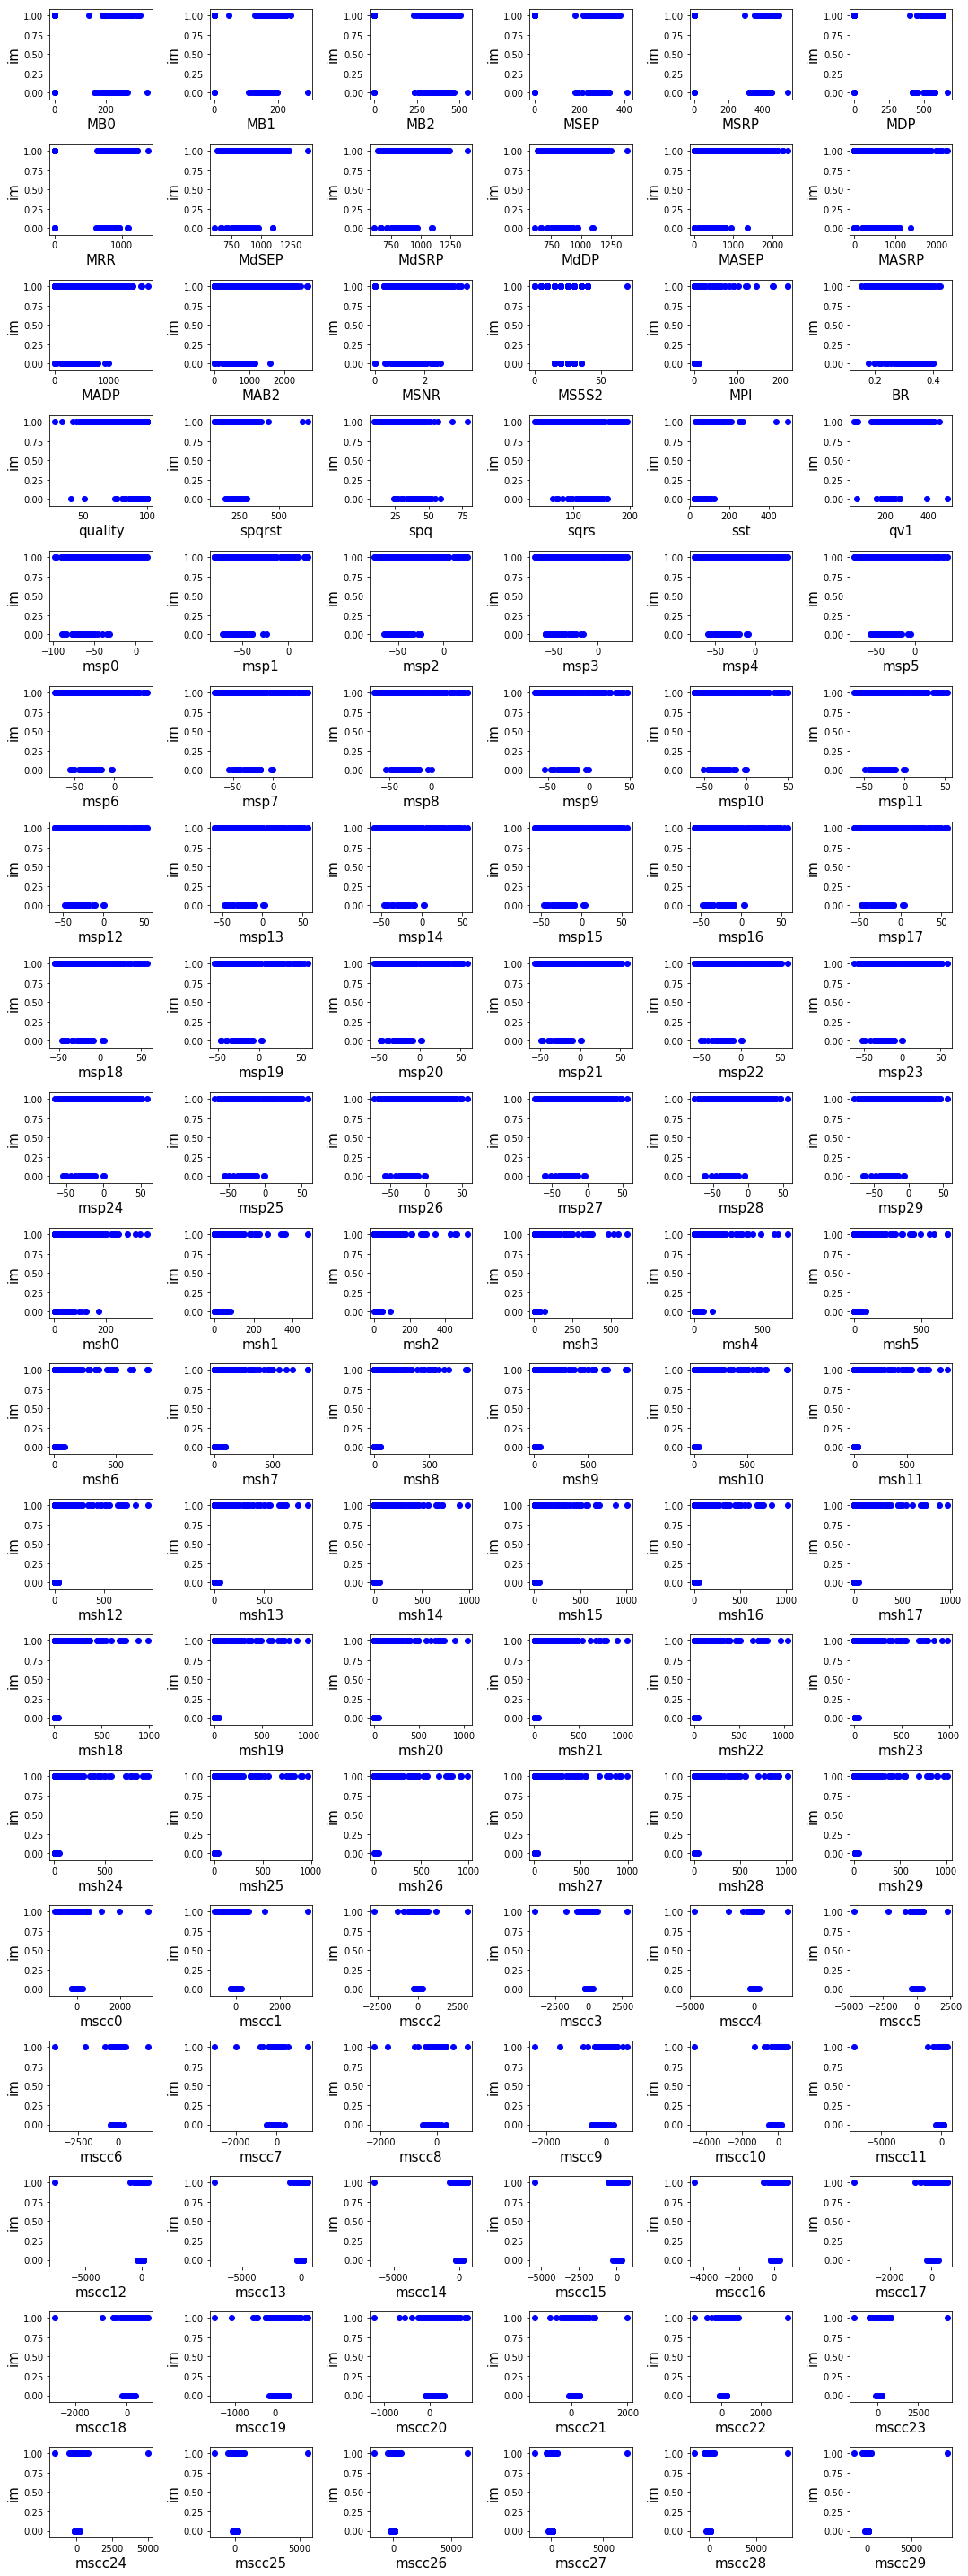

In [549]:
plots(X_train, y_train, figsize=(15, 40))

In [550]:
check_corrupted(X_train, 30)

MB0 corrupted: 0 -> 58
MB1 corrupted: 0 -> 58
MB1 corrupted: 173 -> 32
MB2 corrupted: -1 -> 58
MSEP corrupted: 0 -> 58
MSRP corrupted: 0 -> 58
MDP corrupted: 0 -> 58
MRR corrupted: 0 -> 58
MASEP corrupted: 0.0 -> 58
MASRP corrupted: 0.0 -> 58
MADP corrupted: 0.0 -> 58
MAB2 corrupted: 0.0 -> 58
MSNR corrupted: 0.0 -> 58
MS5S2 corrupted: 30 -> 331
MS5S2 corrupted: 35 -> 167
MS5S2 corrupted: 25 -> 109
MS5S2 corrupted: 20 -> 46
MPI corrupted: 0.0 -> 58
BR corrupted: 0.238889 -> 35
quality corrupted: 100 -> 153
quality corrupted: 99 -> 105
quality corrupted: 98 -> 55


In [551]:
X_train_nocor, X_train_cor, y_train_nocor, y_train_cor = split_corruption(X_train, y_train)
X_test_nocor, X_test_cor, y_test_nocor, y_test_cor = split_corruption(X_test, y_test)

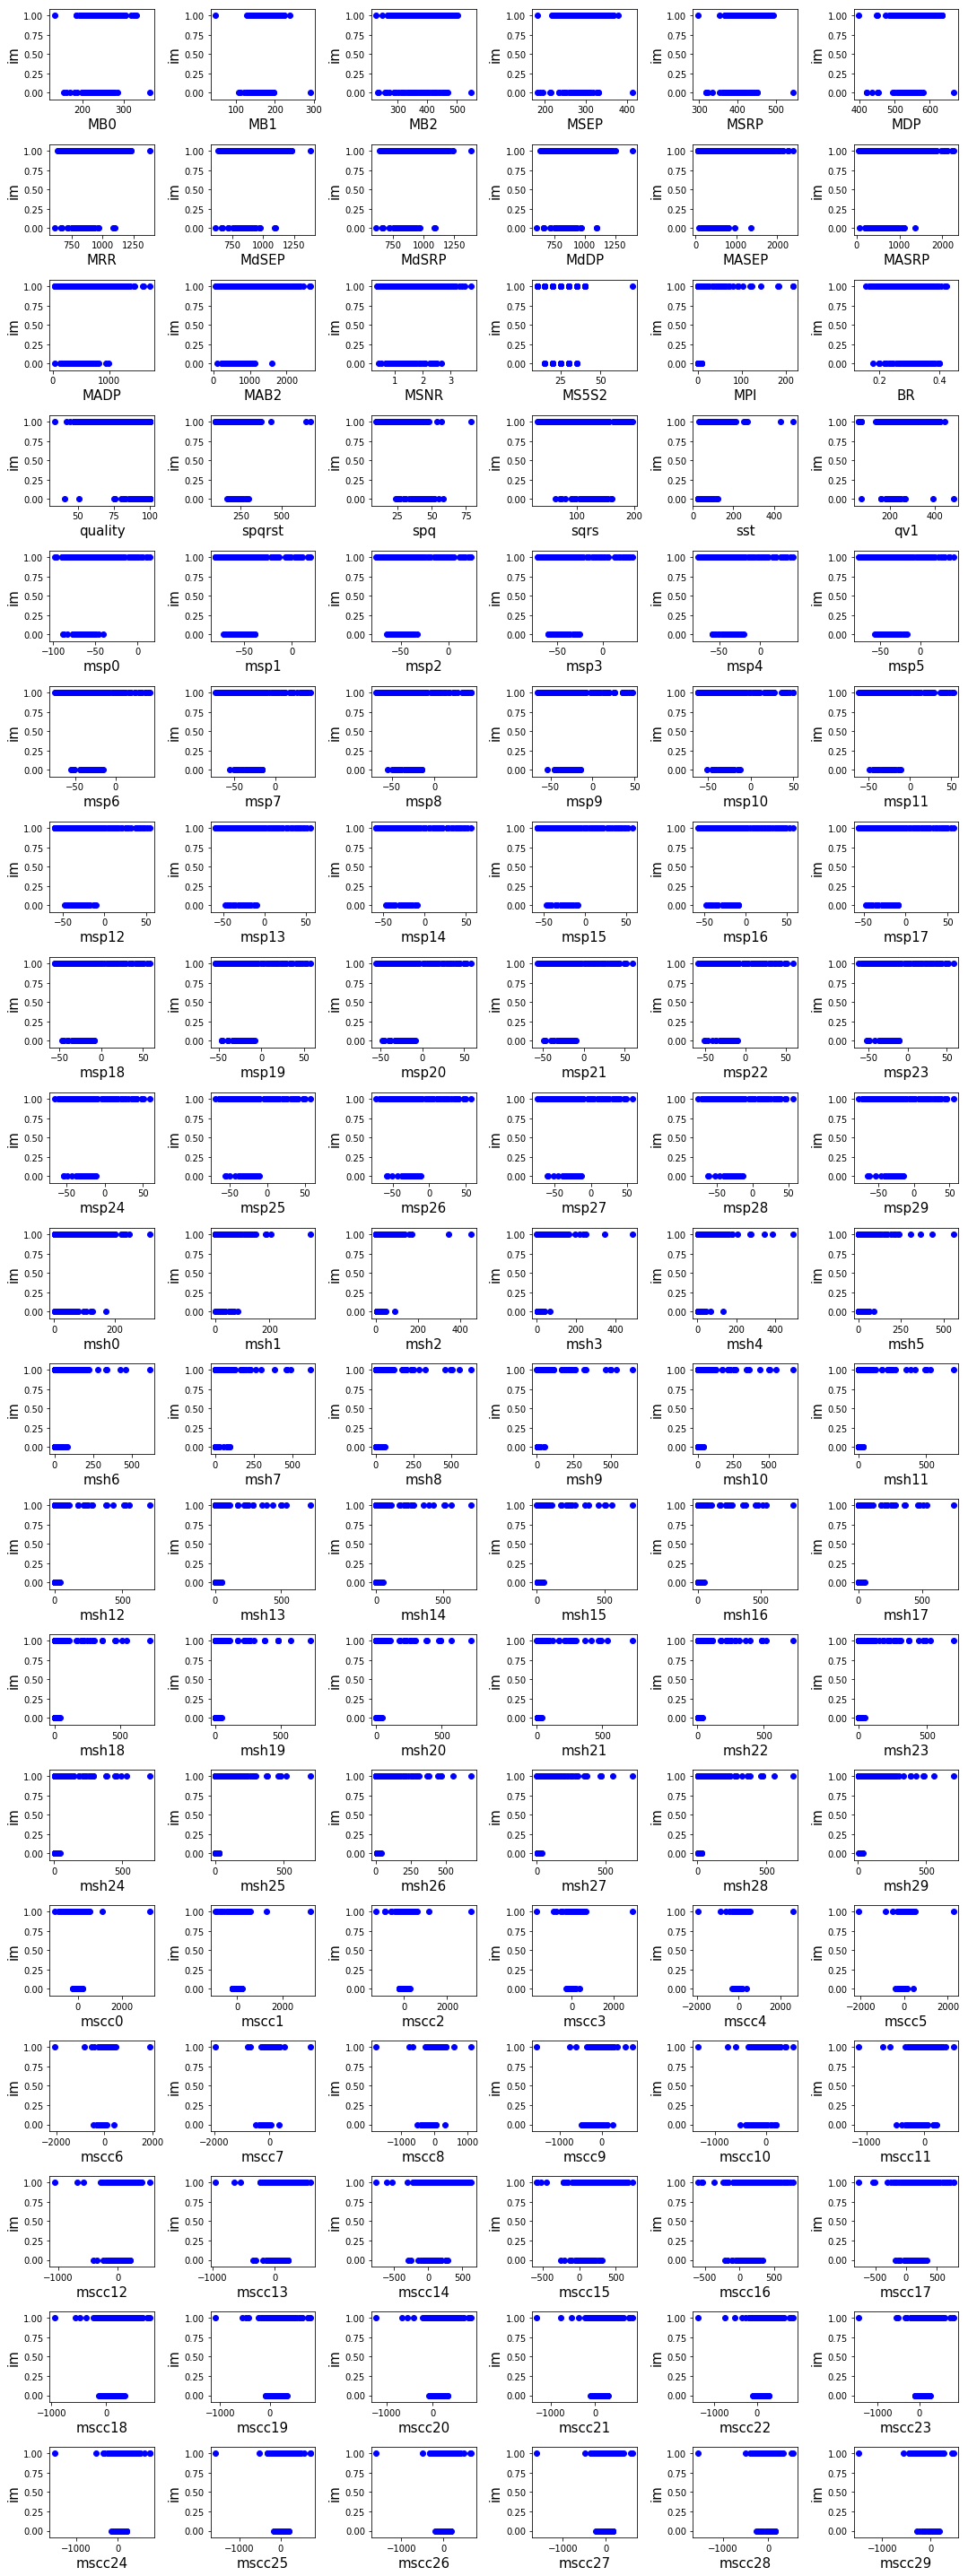

In [552]:
plots(X_train_nocor, y_train_nocor, figsize=(15, 40))

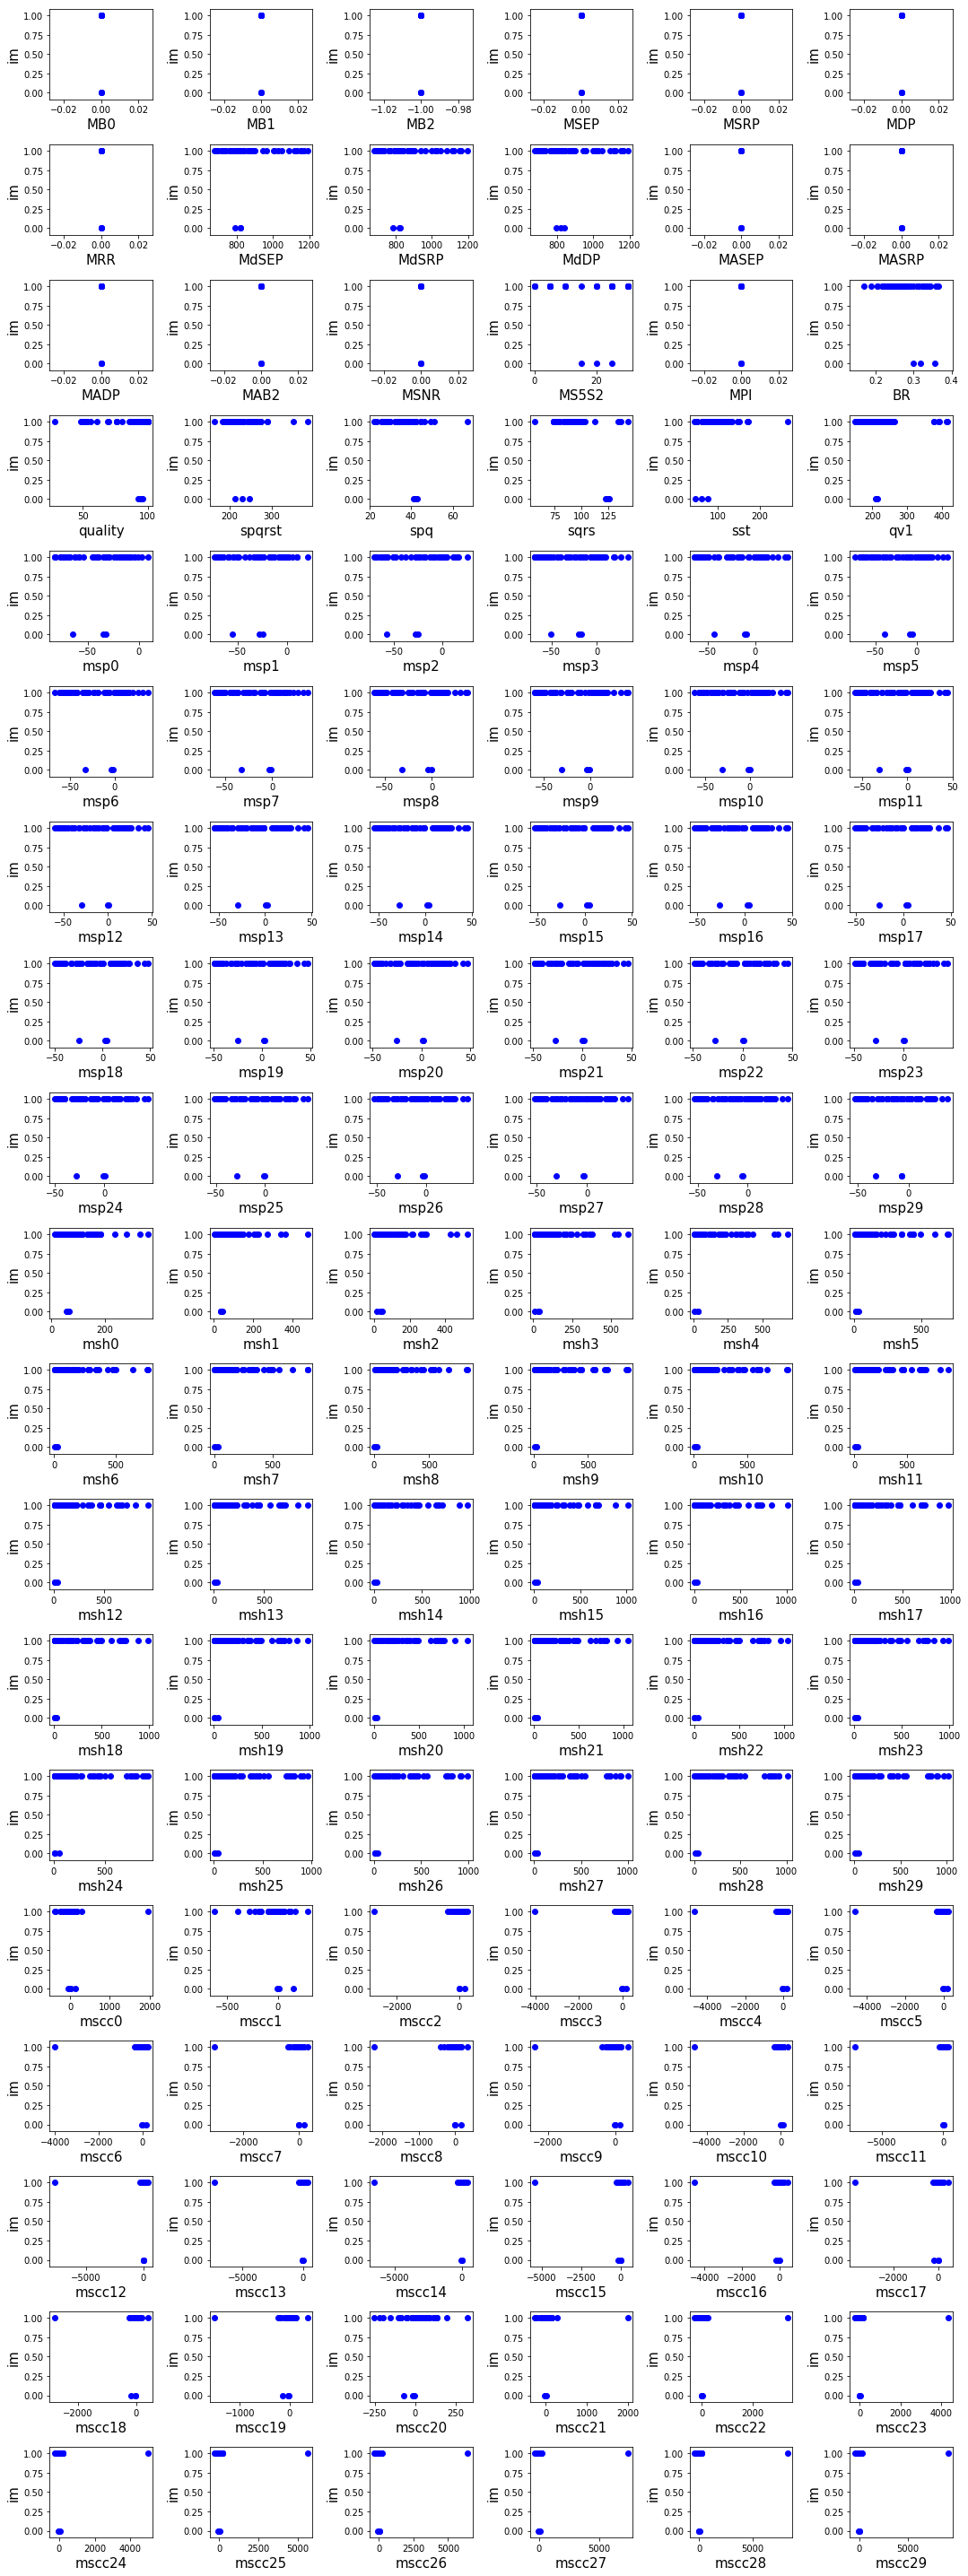

In [553]:
plots(X_train_cor, y_train_cor, figsize=(15, 40))

In [700]:
X_train_cur, X_test_cur, y_train_cur, y_test_cur = preprocess_data(X_train, X_test, y_train, y_test)

/home/nikolai.korolev/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [555]:
net_1 = single_net(X_train_cur, y_train_cur, iterations=40000)

Iteration 0: Loss: 0.591844916343689
Iteration 500: Loss: 0.08813907206058502
Iteration 1000: Loss: 0.08798833936452866
Iteration 1500: Loss: 0.08798806369304657
Iteration 2000: Loss: 0.08798807859420776
Iteration 2500: Loss: 0.08798807859420776
Iteration 3000: Loss: 0.08798806369304657
Iteration 3500: Loss: 0.08798804879188538
Iteration 4000: Loss: 0.08798804134130478
Iteration 4500: Loss: 0.0879879966378212
Iteration 5000: Loss: 0.08798788487911224
Iteration 5500: Loss: 0.08798614144325256
Iteration 6000: Loss: 0.011398850940167904
Iteration 6500: Loss: 0.011089821346104145
Iteration 7000: Loss: 0.01104320865124464
Iteration 7500: Loss: 0.011022672057151794
Iteration 8000: Loss: 0.01101077999919653
Iteration 8500: Loss: 0.011002360843122005
Iteration 9000: Loss: 0.010995958000421524
Iteration 9500: Loss: 0.010991153307259083
Iteration 10000: Loss: 0.010987711139023304
Iteration 10500: Loss: 0.01098538190126419
Iteration 11000: Loss: 0.01098384615033865
Iteration 11500: Loss: 0.010982

In [556]:
summary(net_1, X_train_cur, X_test_cur, y_train_cur, y_test_cur)

Train data:
	ROC AUC:	0.9574514991181657
	MSE:		0.008279972709715366
	Accuracy:	0.9916434540389972
	Correct:	712
	Incorrect:	6
Test data:
	ROC AUC:	0.7832332563510392
	MSE:		0.045444462448358536
	Accuracy:	0.9497816593886463
	Correct:	435
	Incorrect:	23


In [617]:
net_2 = multi_net(X_train_cur, y_train_cur,
                  nets=3,
                  iterations_single=10000,
                  iterations_ensemble=10000,
                  hidden_size_ensemble=3,
                  heterogeneity=1e-6)

Iteration 0: Loss: 0.28295519948005676
Iteration 500: Loss: 0.08799351751804352
Iteration 1000: Loss: 0.08798821270465851
Iteration 1500: Loss: 0.08798808604478836
Iteration 2000: Loss: 0.08798807859420776
Iteration 2500: Loss: 0.08798807859420776
Iteration 3000: Loss: 0.08798806369304657
Iteration 3500: Loss: 0.08798804134130478
Iteration 4000: Loss: 0.08798803389072418
Iteration 4500: Loss: 0.08798795193433762
Iteration 5000: Loss: 0.036128148436546326
Iteration 5500: Loss: 0.011163025163114071
Iteration 6000: Loss: 0.011024017818272114
Iteration 6500: Loss: 0.010999481193721294
Iteration 7000: Loss: 0.010990762151777744
Iteration 7500: Loss: 0.010986663401126862
Iteration 8000: Loss: 0.01098446175456047
Iteration 8500: Loss: 0.01098317839205265
Iteration 9000: Loss: 0.010982396081089973
Iteration 9500: Loss: 0.010981902480125427


Iteration 0: Loss: 0.2022113800048828
Iteration 500: Loss: 0.08791784942150116
Iteration 1000: Loss: 0.08790238201618195
Iteration 1500: Loss: 0.08786628395318985
Iteration 2000: Loss: 0.08777593076229095
Iteration 2500: Loss: 0.009935003705322742
Iteration 3000: Loss: 0.009166349656879902
Iteration 3500: Loss: 0.008693241514265537
Iteration 4000: Loss: 0.008107511326670647
Iteration 4500: Loss: 0.005915903020650148
Iteration 5000: Loss: 0.004393178038299084
Iteration 5500: Loss: 0.0022781952284276485
Iteration 6000: Loss: -0.00819106213748455
Iteration 6500: Loss: -0.012667657807469368
Iteration 7000: Loss: -0.017680715769529343
Iteration 7500: Loss: -0.02394442819058895
Iteration 8000: Loss: -0.03156043961644173
Iteration 8500: Loss: -0.04063952714204788
Iteration 9000: Loss: -0.05136040225625038
Iteration 9500: Loss: -0.06394729018211365


Iteration 0: Loss: 0.4233130216598511
Iteration 500: Loss: 0.06848747283220291
Iteration 1000: Loss: 0.06792621314525604
Iteration 1500: Loss: 0.06708940118551254
Iteration 2000: Loss: -0.007961221039295197
Iteration 2500: Loss: -0.011420357041060925
Iteration 3000: Loss: -0.014519861899316311
Iteration 3500: Loss: -0.016584152355790138
Iteration 4000: Loss: -0.020153075456619263
Iteration 4500: Loss: -0.022745463997125626
Iteration 5000: Loss: -0.02576836198568344
Iteration 5500: Loss: -0.029315192252397537
Iteration 6000: Loss: -0.03447839990258217
Iteration 6500: Loss: -0.038827329874038696
Iteration 7000: Loss: -0.04506312683224678
Iteration 7500: Loss: -0.054738953709602356
Iteration 8000: Loss: -0.06110822409391403
Iteration 8500: Loss: -0.0681084468960762
Iteration 9000: Loss: -0.07586051523685455
Iteration 9500: Loss: -0.08440570533275604


Iteration 0: Loss: 0.2900123596191406
Iteration 500: Loss: 0.0217145886272192
Iteration 1000: Loss: 0.0018748111324384809
Iteration 1500: Loss: 0.000665558036416769
Iteration 2000: Loss: 0.00034221174428239465
Iteration 2500: Loss: 0.00020532113558147103
Iteration 3000: Loss: 0.00013386004138737917
Iteration 3500: Loss: 9.182360372506082e-05
Iteration 4000: Loss: 6.5139181970153e-05
Iteration 4500: Loss: 4.729797365143895e-05
Iteration 5000: Loss: 3.4921416954603046e-05
Iteration 5500: Loss: 2.6101233743247576e-05
Iteration 6000: Loss: 1.968817741726525e-05
Iteration 6500: Loss: 1.4954148355172947e-05
Iteration 7000: Loss: 1.1418741451052483e-05
Iteration 7500: Loss: 8.75486421136884e-06
Iteration 8000: Loss: 6.7338351072976366e-06
Iteration 8500: Loss: 5.192326170799788e-06
Iteration 9000: Loss: 4.011470537079731e-06
Iteration 9500: Loss: 3.1039292025525356e-06


In [619]:
summary(net_2, X_train_cur, X_test_cur, y_train_cur, y_test_cur)

Train data:
	ROC AUC:	1.0
	MSE:		2.404694214419578e-06
	Accuracy:	1.0
	Correct:	718
	Incorrect:	0
Test data:
	ROC AUC:	0.7854272517321016
	MSE:		0.045586761087179184
	Accuracy:	0.9541484716157205
	Correct:	437
	Incorrect:	21


In [701]:
net_3 = multi_net(X_train_cur, y_train_cur,
                  nets=4,
                  iterations_single=10000,
                  iterations_ensemble=10000,
                  hidden_size_ensemble=3,
                  verbose_iterations=500,
                  heterogeneity=1e-6)

Iteration 0: Loss: 0.5477237105369568 MSE: 0.5477237105369568
Iteration 500: Loss: 0.08798819035291672 MSE: 0.08798819035291672
Iteration 1000: Loss: 0.08798818290233612 MSE: 0.08798818290233612
Iteration 1500: Loss: 0.08798817545175552 MSE: 0.08798817545175552
Iteration 2000: Loss: 0.08798809349536896 MSE: 0.08798809349536896
Iteration 2500: Loss: 0.08798795193433762 MSE: 0.08798795193433762
Iteration 3000: Loss: 0.08798782527446747 MSE: 0.08798782527446747
Iteration 3500: Loss: 0.08798635005950928 MSE: 0.08798635005950928
Iteration 4000: Loss: 0.012680931948125362 MSE: 0.012680931948125362
Iteration 4500: Loss: 0.011195696890354156 MSE: 0.011195696890354156
Iteration 5000: Loss: 0.011059149168431759 MSE: 0.011059149168431759
Iteration 5500: Loss: 0.011019001714885235 MSE: 0.011019001714885235
Iteration 6000: Loss: 0.011003217659890652 MSE: 0.011003217659890652
Iteration 6500: Loss: 0.01099596917629242 MSE: 0.01099596917629242
Iteration 7000: Loss: 0.010992145165801048 MSE: 0.01099214

Iteration 0: Loss: 0.3897605836391449 MSE: 0.3897978663444519
Iteration 500: Loss: 0.08798331022262573 MSE: 0.08802291750907898
Iteration 1000: Loss: 0.0879446417093277 MSE: 0.08798810094594955
Iteration 1500: Loss: 0.08793719857931137 MSE: 0.08798808604478836
Iteration 2000: Loss: 0.08792135864496231 MSE: 0.08798808604478836
Iteration 2500: Loss: 0.08787974715232849 MSE: 0.0879882201552391
Iteration 3000: Loss: 0.08776533603668213 MSE: 0.08798820525407791
Iteration 3500: Loss: 0.08750051259994507 MSE: 0.0879882201552391
Iteration 4000: Loss: 0.08697862178087234 MSE: 0.0879882276058197
Iteration 4500: Loss: 0.08606303483247757 MSE: 0.0879882350564003
Iteration 5000: Loss: 0.08460377156734467 MSE: 0.08798824995756149
Iteration 5500: Loss: 0.08246345818042755 MSE: 0.08798825740814209
Iteration 6000: Loss: 0.07949596643447876 MSE: 0.08798824995756149
Iteration 6500: Loss: 0.07549522817134857 MSE: 0.08798821270465851
Iteration 7000: Loss: 0.07018936425447464 MSE: 0.08798815310001373
Iterat

Iteration 0: Loss: 0.4195992946624756 MSE: 0.45918795466423035
Iteration 500: Loss: 0.047264836728572845 MSE: 0.08798825740814209
Iteration 1000: Loss: 0.04507915675640106 MSE: 0.08798828721046448
Iteration 1500: Loss: 0.041920337826013565 MSE: 0.08798836171627045
Iteration 2000: Loss: 0.03770134598016739 MSE: 0.0879882425069809
Iteration 2500: Loss: 0.032318051904439926 MSE: 0.08798753470182419
Iteration 3000: Loss: -0.04909485578536987 MSE: 0.013039464130997658
Iteration 3500: Loss: -0.06646627187728882 MSE: 0.003043971722945571
Iteration 4000: Loss: -0.07524853199720383 MSE: 0.00285010552033782
Iteration 4500: Loss: -0.08532293885946274 MSE: 0.0028111545834690332
Iteration 5000: Loss: -0.09690719097852707 MSE: 0.002796390326693654
Iteration 5500: Loss: -0.11010541766881943 MSE: 0.002789248013868928
Iteration 6000: Loss: -0.12500649690628052 MSE: 0.002785505261272192
Iteration 6500: Loss: -0.1416950225830078 MSE: 0.002783386502414942
Iteration 7000: Loss: -0.16025887429714203 MSE: 0.

Iteration 0: Loss: 0.3752371370792389 MSE: 0.45963162183761597
Iteration 500: Loss: 0.003480188548564911 MSE: 0.08806231617927551
Iteration 1000: Loss: 0.002971835434436798 MSE: 0.08798816800117493
Iteration 1500: Loss: 0.002251073718070984 MSE: 0.08798833191394806
Iteration 2000: Loss: 0.0011360496282577515 MSE: 0.08798836916685104
Iteration 2500: Loss: -0.0005113035440444946 MSE: 0.08798836916685104
Iteration 3000: Loss: -0.002849884331226349 MSE: 0.08798829466104507
Iteration 3500: Loss: -0.00605744868516922 MSE: 0.08798717707395554
Iteration 4000: Loss: -0.08794121444225311 MSE: 0.010193254798650742
Iteration 4500: Loss: -0.09464217722415924 MSE: 0.008434602059423923
Iteration 5000: Loss: -0.10080981999635696 MSE: 0.008332605473697186
Iteration 5500: Loss: -0.11323260515928268 MSE: 0.0030701286159455776
Iteration 6000: Loss: -0.1216016560792923 MSE: 0.002843915019184351
Iteration 6500: Loss: -0.13133586943149567 MSE: 0.0028118975460529327
Iteration 7000: Loss: -0.1427280455827713 M

Iteration 0: Loss: 0.2293033003807068 MSE: 0.2293033003807068
Iteration 500: Loss: 0.009555389173328876 MSE: 0.009555389173328876
Iteration 1000: Loss: 0.0038008892443031073 MSE: 0.0038008892443031073
Iteration 1500: Loss: 0.003190513700246811 MSE: 0.003190513700246811
Iteration 2000: Loss: 0.0029959608800709248 MSE: 0.0029959608800709248
Iteration 2500: Loss: 0.0029085101559758186 MSE: 0.0029085101559758186
Iteration 3000: Loss: 0.002861834829673171 MSE: 0.002861834829673171
Iteration 3500: Loss: 0.0028342530131340027 MSE: 0.0028342530131340027
Iteration 4000: Loss: 0.0028168335556983948 MSE: 0.0028168335556983948
Iteration 4500: Loss: 0.0028053163550794125 MSE: 0.0028053163550794125
Iteration 5000: Loss: 0.002797451801598072 MSE: 0.002797451801598072
Iteration 5500: Loss: 0.0027919579297304153 MSE: 0.0027919579297304153
Iteration 6000: Loss: 0.002788042649626732 MSE: 0.002788042649626732
Iteration 6500: Loss: 0.00278521073050797 MSE: 0.00278521073050797
Iteration 7000: Loss: 0.002783

In [702]:
summary(net_3, X_train_cur, X_test_cur, y_train_cur, y_test_cur)

Train data:
	ROC AUC:	0.9822861552028219
	MSE:		0.0027781676035374403
	Accuracy:	0.9972144846796658
	Correct:	716
	Incorrect:	2
Test data:
	ROC AUC:	0.86
	MSE:		0.040075428783893585
	Accuracy:	0.9585152838427947
	Correct:	439
	Incorrect:	19


### Попробуем на recog3, train3

In [703]:
X_train, X_test, y_train, y_test = read_data(3)

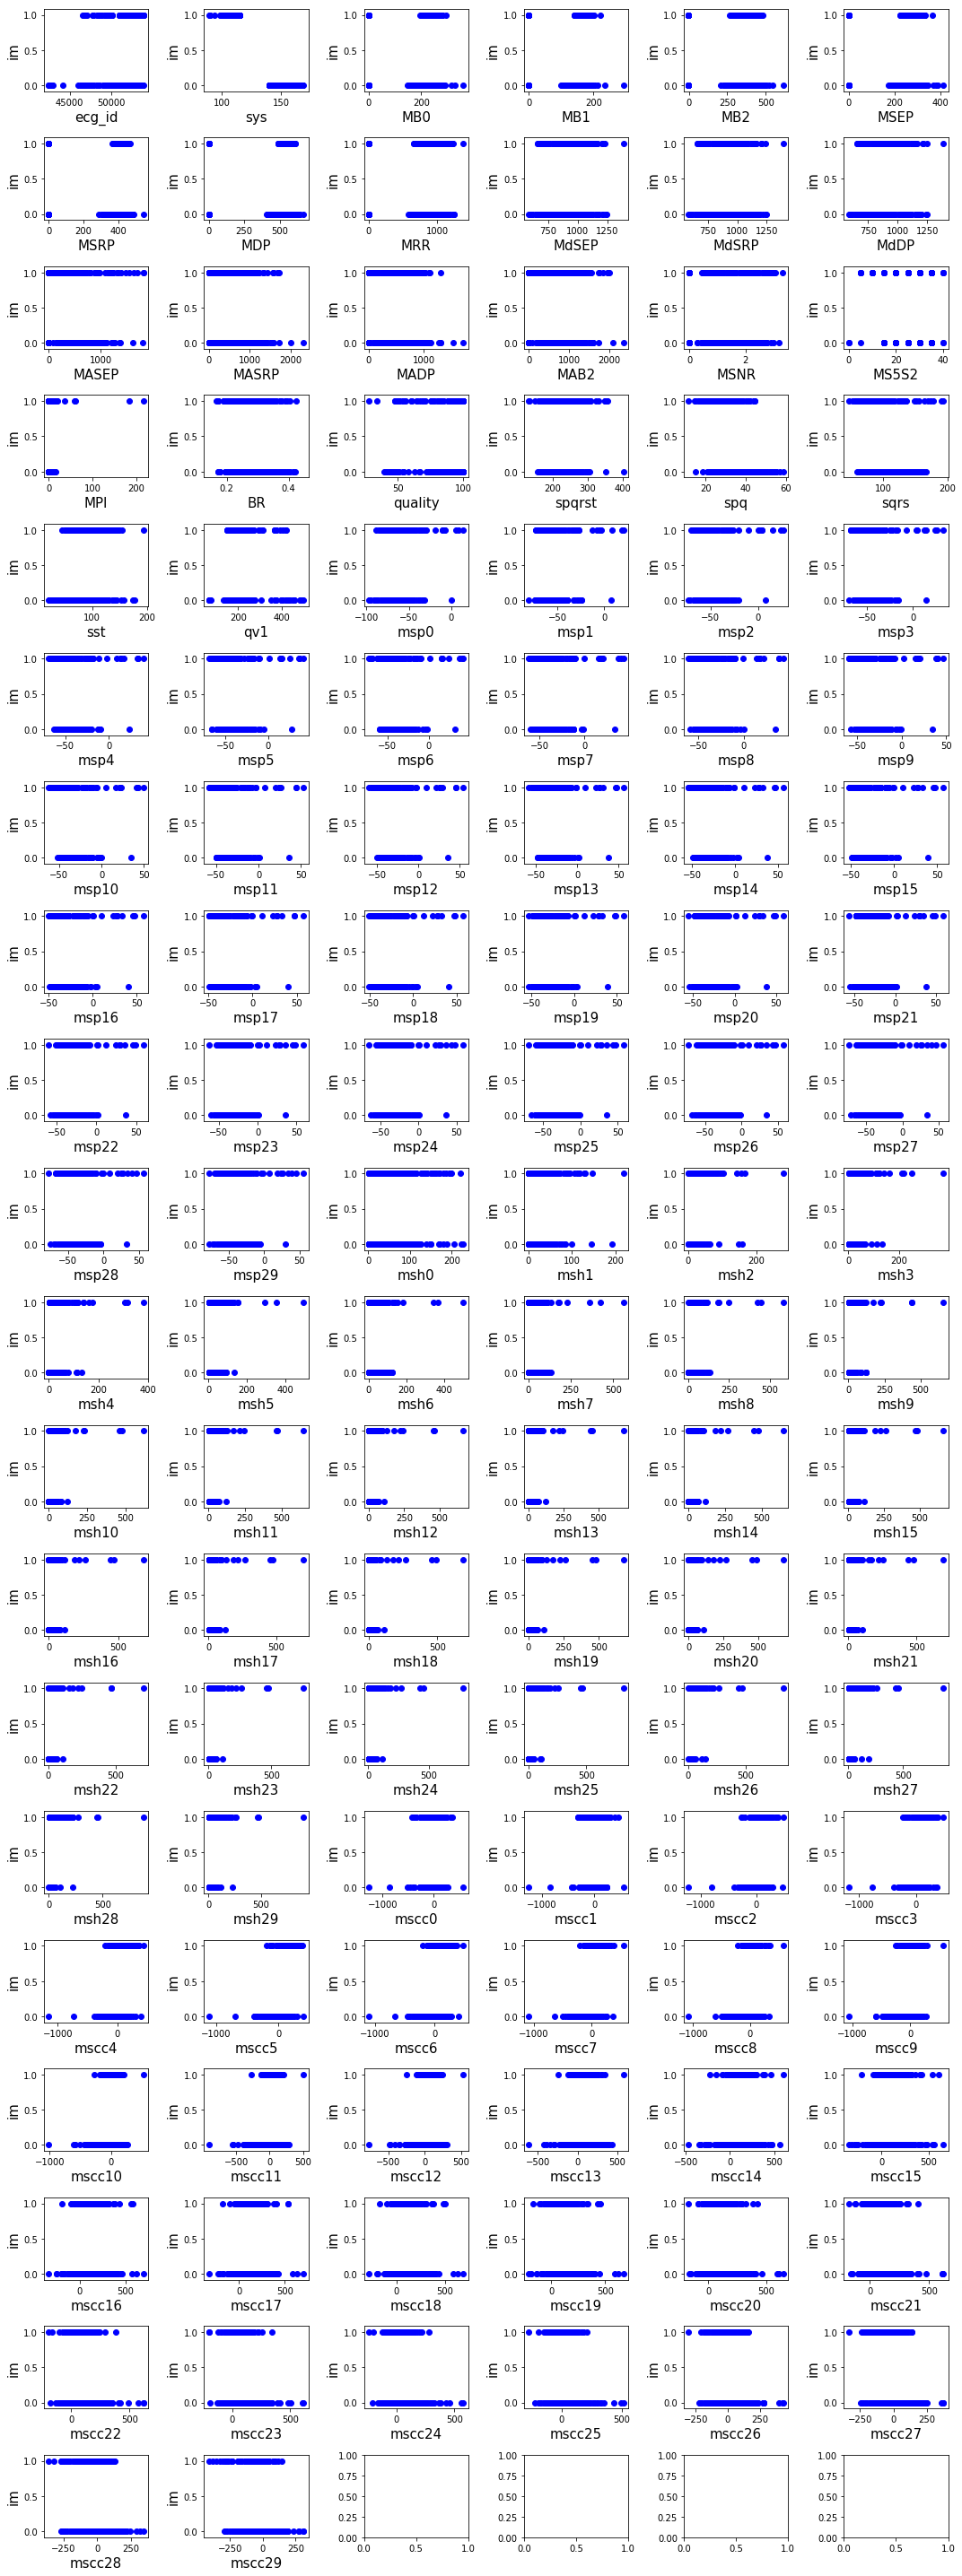

In [621]:
plots(X_train, y_train, figsize=(15, 40))

In [622]:
check_corrupted(X_train, 30)

sys corrupted: 140 -> 31
MS5S2 corrupted: 30 -> 168
MS5S2 corrupted: 25 -> 82
MS5S2 corrupted: 35 -> 52
MS5S2 corrupted: 20 -> 36
quality corrupted: 100 -> 81
quality corrupted: 99 -> 35


In [704]:
X_train.drop(['sys', 'ecg_id'], axis=1, inplace=True)
X_test.drop(['sys', 'ecg_id'], axis=1, inplace=True)

In [705]:
X_train_cur, X_test_cur, y_train_cur, y_test_cur = preprocess_data(X_train, X_test, y_train, y_test)

/home/nikolai.korolev/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [625]:
net_1 = single_net(X_train_cur, y_train_cur, iterations=40000)

Iteration 0: Loss: 0.33454903960227966 MSE: 0.33454903960227966
Iteration 500: Loss: 0.03960780054330826 MSE: 0.03960780054330826
Iteration 1000: Loss: 0.02706035226583481 MSE: 0.02706035226583481
Iteration 1500: Loss: 0.026048537343740463 MSE: 0.026048537343740463
Iteration 2000: Loss: 0.025784894824028015 MSE: 0.025784894824028015
Iteration 2500: Loss: 0.025686495006084442 MSE: 0.025686495006084442
Iteration 3000: Loss: 0.025642331689596176 MSE: 0.025642331689596176
Iteration 3500: Loss: 0.025616632774472237 MSE: 0.025616632774472237
Iteration 4000: Loss: 0.02559960074722767 MSE: 0.02559960074722767
Iteration 4500: Loss: 0.025587406009435654 MSE: 0.025587406009435654
Iteration 5000: Loss: 0.02557756006717682 MSE: 0.02557756006717682
Iteration 5500: Loss: 0.0255693718791008 MSE: 0.0255693718791008
Iteration 6000: Loss: 0.025563329458236694 MSE: 0.025563329458236694
Iteration 6500: Loss: 0.025558991357684135 MSE: 0.025558991357684135
Iteration 7000: Loss: 0.025555796921253204 MSE: 0.02

In [626]:
summary(net_1, X_train_cur, X_test_cur, y_train_cur, y_test_cur)

Train data:
	ROC AUC:	0.97296918767507
	MSE:		0.025546535849571228
	Accuracy:	0.9731903485254692
	Correct:	363
	Incorrect:	10
Test data:
	ROC AUC:	0.7936810856658185
	MSE:		0.20990988612174988
	Accuracy:	0.7692307692307693
	Correct:	170
	Incorrect:	51


In [628]:
net_2 = multi_net(X_train_cur, y_train_cur,
                  nets=3,
                  iterations_single=10000,
                  iterations_ensemble=10000,
                  hidden_size_ensemble=3,
                  heterogeneity=1e-6)

Iteration 0: Loss: 0.29897162318229675 MSE: 0.29897162318229675
Iteration 500: Loss: 0.04339269921183586 MSE: 0.04339269921183586
Iteration 1000: Loss: 0.031171683222055435 MSE: 0.031171683222055435
Iteration 1500: Loss: 0.030538711696863174 MSE: 0.030538711696863174
Iteration 2000: Loss: 0.0303873959928751 MSE: 0.0303873959928751
Iteration 2500: Loss: 0.030326714739203453 MSE: 0.030326714739203453
Iteration 3000: Loss: 0.030500508844852448 MSE: 0.030500508844852448
Iteration 3500: Loss: 0.03031914308667183 MSE: 0.03031914308667183
Iteration 4000: Loss: 0.030293766409158707 MSE: 0.030293766409158707
Iteration 4500: Loss: 0.02564326487481594 MSE: 0.02564326487481594
Iteration 5000: Loss: 0.02558295987546444 MSE: 0.02558295987546444
Iteration 5500: Loss: 0.02557314559817314 MSE: 0.02557314559817314
Iteration 6000: Loss: 0.020760808140039444 MSE: 0.020760808140039444
Iteration 6500: Loss: 0.020747678354382515 MSE: 0.020747678354382515
Iteration 7000: Loss: 0.0207402054220438 MSE: 0.020740

Iteration 0: Loss: 0.388677716255188 MSE: 0.3888390362262726
Iteration 500: Loss: 0.048325810581445694 MSE: 0.048575736582279205
Iteration 1000: Loss: 0.02369651384651661 MSE: 0.024068254977464676
Iteration 1500: Loss: 0.02275139093399048 MSE: 0.023351076990365982
Iteration 2000: Loss: 0.022216957062482834 MSE: 0.023236729204654694
Iteration 2500: Loss: 0.02147417515516281 MSE: 0.023196324706077576
Iteration 3000: Loss: 0.020374193787574768 MSE: 0.02317686378955841
Iteration 3500: Loss: 0.018825719133019447 MSE: 0.023166019469499588
Iteration 4000: Loss: 0.01676695980131626 MSE: 0.023159543052315712
Iteration 4500: Loss: 0.014146468602120876 MSE: 0.02315530739724636
Iteration 5000: Loss: 0.010913838632404804 MSE: 0.023152105510234833
Iteration 5500: Loss: 0.007021132856607437 MSE: 0.02315008081495762
Iteration 6000: Loss: 0.0024216044694185257 MSE: 0.023148823529481888
Iteration 6500: Loss: -0.0029272083193063736 MSE: 0.02314777299761772
Iteration 7000: Loss: -0.009071901440620422 MSE:

Iteration 0: Loss: 0.21988682448863983 MSE: 0.23780511319637299
Iteration 500: Loss: 0.007367270067334175 MSE: 0.02536635659635067
Iteration 1000: Loss: 0.005543367937207222 MSE: 0.023743130266666412
Iteration 1500: Loss: 0.004856083542108536 MSE: 0.023347944021224976
Iteration 2000: Loss: 0.004410546272993088 MSE: 0.023266907781362534
Iteration 2500: Loss: 0.00393214076757431 MSE: 0.023235835134983063
Iteration 3000: Loss: 0.003367772325873375 MSE: 0.023218458518385887
Iteration 3500: Loss: 0.0026851892471313477 MSE: 0.023205358535051346
Iteration 4000: Loss: 0.0018462222069501877 MSE: 0.023192914202809334
Iteration 4500: Loss: -0.0014929082244634628 MSE: 0.020566187798976898
Iteration 5000: Loss: -0.002293134108185768 MSE: 0.020548461005091667
Iteration 5500: Loss: -0.00327124260365963 MSE: 0.02054010145366192
Iteration 6000: Loss: -0.004465451464056969 MSE: 0.02053503505885601
Iteration 6500: Loss: -0.005905091762542725 MSE: 0.020531533285975456
Iteration 7000: Loss: -0.007613534107

Iteration 0: Loss: 0.23287086188793182 MSE: 0.23287086188793182
Iteration 500: Loss: 0.0008648900547996163 MSE: 0.0008648900547996163
Iteration 1000: Loss: 0.0002366187545703724 MSE: 0.0002366187545703724
Iteration 1500: Loss: 0.00011278912279522046 MSE: 0.00011278912279522046
Iteration 2000: Loss: 6.532680708914995e-05 MSE: 6.532680708914995e-05
Iteration 2500: Loss: 4.1776416765060276e-05 MSE: 4.1776416765060276e-05
Iteration 3000: Loss: 2.8336255127214827e-05 MSE: 2.8336255127214827e-05
Iteration 3500: Loss: 1.9967441403423436e-05 MSE: 1.9967441403423436e-05
Iteration 4000: Loss: 1.4442152860283386e-05 MSE: 1.4442152860283386e-05
Iteration 4500: Loss: 1.0640733307809569e-05 MSE: 1.0640733307809569e-05
Iteration 5000: Loss: 7.945905963424593e-06 MSE: 7.945905963424593e-06
Iteration 5500: Loss: 5.992749720462598e-06 MSE: 5.992749720462598e-06
Iteration 6000: Loss: 4.55356212114566e-06 MSE: 4.55356212114566e-06
Iteration 6500: Loss: 3.4795502870110795e-06 MSE: 3.4795502870110795e-06
It

In [629]:
summary(net_2, X_train_cur, X_test_cur, y_train_cur, y_test_cur)

Train data:
	ROC AUC:	1.0
	MSE:		5.723960043724219e-07
	Accuracy:	1.0
	Correct:	373
	Incorrect:	0
Test data:
	ROC AUC:	0.8323155216284988
	MSE:		0.24828766286373138
	Accuracy:	0.751131221719457
	Correct:	166
	Incorrect:	55


In [713]:
net_3 = multi_net(X_train_cur, y_train_cur,
                  nets=100,
                  iterations_single=501,
                  iterations_ensemble=10000,
                  hidden_size_ensemble=80,
                  verbose_iterations=100,
                  heterogeneity=1e-6)

Iteration 0: Loss: 0.23508590459823608 MSE: 0.23508590459823608
Iteration 100: Loss: 0.07187802344560623 MSE: 0.07187802344560623
Iteration 200: Loss: 0.04868504777550697 MSE: 0.04868504777550697
Iteration 300: Loss: 0.04184962436556816 MSE: 0.04184962436556816
Iteration 400: Loss: 0.03526303172111511 MSE: 0.03526303172111511
Iteration 500: Loss: 0.029987217858433723 MSE: 0.029987217858433723
End of learning. Best loss: 0.029987217858433723


Iteration 0: Loss: 0.29808706045150757 MSE: 0.2981063723564148
Iteration 100: Loss: 0.23091627657413483 MSE: 0.2309364378452301
Iteration 200: Loss: 0.23090963065624237 MSE: 0.23093068599700928
Iteration 300: Loss: 0.09776601195335388 MSE: 0.09780280292034149
Iteration 400: Loss: 0.048418428748846054 MSE: 0.048471178859472275
Iteration 500: Loss: 0.037477366626262665 MSE: 0.03753874823451042
End of learning. Best loss: 0.037477366626262665


Iteration 0: Loss: 0.23905299603939056 MSE: 0.23908188939094543
Iteration 100: Loss: 0.07129029184579849 MSE: 0.07132588326931
Iteration 200: Loss: 0.04876738041639328 MSE: 0.04880768060684204
Iteration 300: Loss: 0.039093244820833206 MSE: 0.039137233048677444
Iteration 400: Loss: 0.03198866546154022 MSE: 0.032035209238529205
Iteration 500: Loss: 0.029228709638118744 MSE: 0.029276367276906967
End of learning. Best loss: 0.029228709638118744


Iteration 0: Loss: 0.2748734652996063 MSE: 0.27489879727363586
Iteration 100: Loss: 0.21432429552078247 MSE: 0.21435293555259705
Iteration 200: Loss: 0.055272094905376434 MSE: 0.05531184375286102
Iteration 300: Loss: 0.03985137864947319 MSE: 0.03989824652671814
Iteration 400: Loss: 0.03470483422279358 MSE: 0.03475702181458473
Iteration 500: Loss: 0.03321344032883644 MSE: 0.03327057138085365
End of learning. Best loss: 0.03321344032883644


Iteration 0: Loss: 0.2519710063934326 MSE: 0.2519999146461487
Iteration 100: Loss: 0.08638066053390503 MSE: 0.08641302585601807
Iteration 200: Loss: 0.05223073810338974 MSE: 0.052270807325839996
Iteration 300: Loss: 0.04058988392353058 MSE: 0.040634702891111374
Iteration 400: Loss: 0.033599626272916794 MSE: 0.033647600561380386
Iteration 500: Loss: 0.02950010634958744 MSE: 0.029550835490226746
End of learning. Best loss: 0.02901569753885269


Iteration 0: Loss: 0.3427424132823944 MSE: 0.34277045726776123
Iteration 100: Loss: 0.23090767860412598 MSE: 0.2309367060661316
Iteration 200: Loss: 0.23090653121471405 MSE: 0.23093679547309875
Iteration 300: Loss: 0.23090432584285736 MSE: 0.23093673586845398
Iteration 400: Loss: 0.23090074956417084 MSE: 0.23093672096729279
Iteration 500: Loss: 0.2308947592973709 MSE: 0.23093660175800323
End of learning. Best loss: 0.2308947592973709


Iteration 0: Loss: 0.23119015991687775 MSE: 0.23121458292007446
Iteration 100: Loss: 0.06667203456163406 MSE: 0.0667031854391098
Iteration 200: Loss: 0.051048438996076584 MSE: 0.051083046942949295
Iteration 300: Loss: 0.04571017995476723 MSE: 0.04574781283736229
Iteration 400: Loss: 0.04271358251571655 MSE: 0.0427536815404892
Iteration 500: Loss: 0.039942625910043716 MSE: 0.03998451307415962
End of learning. Best loss: 0.039942625910043716


Iteration 0: Loss: 0.2854571044445038 MSE: 0.2854805588722229
Iteration 100: Loss: 0.230910524725914 MSE: 0.23093490302562714
Iteration 200: Loss: 0.23090820014476776 MSE: 0.23093272745609283
Iteration 300: Loss: 0.23090311884880066 MSE: 0.23092789947986603
Iteration 400: Loss: 0.23085980117321014 MSE: 0.2308850884437561
Iteration 500: Loss: 0.06355364620685577 MSE: 0.0635896623134613
End of learning. Best loss: 0.06355364620685577


Iteration 0: Loss: 0.2460167407989502 MSE: 0.24603848159313202
Iteration 100: Loss: 0.06989992409944534 MSE: 0.06992751359939575
Iteration 200: Loss: 0.04644843563437462 MSE: 0.04648217186331749
Iteration 300: Loss: 0.03405396267771721 MSE: 0.034091196954250336
Iteration 400: Loss: 0.029829295352101326 MSE: 0.029868649318814278
Iteration 500: Loss: 0.027759142220020294 MSE: 0.027800463140010834
End of learning. Best loss: 0.027759142220020294


Iteration 0: Loss: 0.30030739307403564 MSE: 0.30032894015312195
Iteration 100: Loss: 0.1623118817806244 MSE: 0.16234011948108673
Iteration 200: Loss: 0.05104438215494156 MSE: 0.051085859537124634
Iteration 300: Loss: 0.03892921283841133 MSE: 0.038980018347501755
Iteration 400: Loss: 0.03531419485807419 MSE: 0.0353722870349884
Iteration 500: Loss: 0.033741436898708344 MSE: 0.033805571496486664
End of learning. Best loss: 0.033741436898708344


Iteration 0: Loss: 0.2398931384086609 MSE: 0.23991741240024567
Iteration 100: Loss: 0.07312976568937302 MSE: 0.07315848767757416
Iteration 200: Loss: 0.045237764716148376 MSE: 0.04527266323566437
Iteration 300: Loss: 0.03780875355005264 MSE: 0.037847477942705154
Iteration 400: Loss: 0.032643359154462814 MSE: 0.0326838344335556
Iteration 500: Loss: 0.030929522588849068 MSE: 0.030972488224506378
End of learning. Best loss: 0.030929522588849068


Iteration 0: Loss: 0.23236212134361267 MSE: 0.23238620162010193
Iteration 100: Loss: 0.0676087886095047 MSE: 0.0676397979259491
Iteration 200: Loss: 0.051291678100824356 MSE: 0.051326628774404526
Iteration 300: Loss: 0.04722421616315842 MSE: 0.04726235568523407
Iteration 400: Loss: 0.06977681070566177 MSE: 0.06981781870126724
Iteration 500: Loss: 0.041242748498916626 MSE: 0.041286028921604156
End of learning. Best loss: 0.041242748498916626


Iteration 0: Loss: 0.30115777254104614 MSE: 0.30118146538734436
Iteration 100: Loss: 0.1803867369890213 MSE: 0.18041667342185974
Iteration 200: Loss: 0.06736509501934052 MSE: 0.06740514189004898
Iteration 300: Loss: 0.04509097337722778 MSE: 0.04514014720916748
Iteration 400: Loss: 0.03311323747038841 MSE: 0.033168260008096695
Iteration 500: Loss: 0.0286999698728323 MSE: 0.028760649263858795
End of learning. Best loss: 0.0286999698728323


Iteration 0: Loss: 0.2733112871646881 MSE: 0.2733359634876251
Iteration 100: Loss: 0.14839409291744232 MSE: 0.14842434227466583
Iteration 200: Loss: 0.06132429093122482 MSE: 0.06136314943432808
Iteration 300: Loss: 0.0404992438852787 MSE: 0.04054481163620949
Iteration 400: Loss: 0.032799236476421356 MSE: 0.03284754604101181
Iteration 500: Loss: 0.0273273978382349 MSE: 0.027380814775824547
End of learning. Best loss: 0.0273273978382349


Iteration 0: Loss: 0.23897022008895874 MSE: 0.23899522423744202
Iteration 100: Loss: 0.06939421594142914 MSE: 0.0694277435541153
Iteration 200: Loss: 0.040028177201747894 MSE: 0.04006769135594368
Iteration 300: Loss: 0.03001527488231659 MSE: 0.030057372525334358
Iteration 400: Loss: 0.026499269530177116 MSE: 0.026543686166405678
Iteration 500: Loss: 0.024853946641087532 MSE: 0.02490062639117241
End of learning. Best loss: 0.024853946641087532


Iteration 0: Loss: 0.24242906272411346 MSE: 0.2424537092447281
Iteration 100: Loss: 0.07231775671243668 MSE: 0.07234934717416763
Iteration 200: Loss: 0.04675368219614029 MSE: 0.04679298773407936
Iteration 300: Loss: 0.03590524196624756 MSE: 0.03594878315925598
Iteration 400: Loss: 0.03162353113293648 MSE: 0.031671471893787384
Iteration 500: Loss: 0.03425990045070648 MSE: 0.03431284800171852
End of learning. Best loss: 0.028146840631961823


Iteration 0: Loss: 0.2330733835697174 MSE: 0.23309853672981262
Iteration 100: Loss: 0.0674363523721695 MSE: 0.06746608018875122
Iteration 200: Loss: 0.04745566099882126 MSE: 0.04748920723795891
Iteration 300: Loss: 0.03990458697080612 MSE: 0.03994164988398552
Iteration 400: Loss: 0.03642556816339493 MSE: 0.03646472096443176
Iteration 500: Loss: 0.03094249777495861 MSE: 0.030982408672571182
End of learning. Best loss: 0.03094249777495861


Iteration 0: Loss: 0.2313852161169052 MSE: 0.23140990734100342
Iteration 100: Loss: 0.0669008195400238 MSE: 0.06693179905414581
Iteration 200: Loss: 0.0514778196811676 MSE: 0.05151235684752464
Iteration 300: Loss: 0.044603023678064346 MSE: 0.04464101418852806
Iteration 400: Loss: 0.04035058990120888 MSE: 0.0403921939432621
Iteration 500: Loss: 0.03891342878341675 MSE: 0.03895746171474457
End of learning. Best loss: 0.03891342878341675


Iteration 0: Loss: 0.2644636332988739 MSE: 0.2644880712032318
Iteration 100: Loss: 0.18951508402824402 MSE: 0.18954452872276306
Iteration 200: Loss: 0.04919404909014702 MSE: 0.049235597252845764
Iteration 300: Loss: 0.036752231419086456 MSE: 0.036801546812057495
Iteration 400: Loss: 0.034030113369226456 MSE: 0.03408420458436012
Iteration 500: Loss: 0.032829806208610535 MSE: 0.03288844972848892
End of learning. Best loss: 0.032829806208610535


Iteration 0: Loss: 0.23768047988414764 MSE: 0.23770582675933838
Iteration 100: Loss: 0.06641030311584473 MSE: 0.06644461303949356
Iteration 200: Loss: 0.04344248026609421 MSE: 0.04348288103938103
Iteration 300: Loss: 0.029727810993790627 MSE: 0.02977125719189644
Iteration 400: Loss: 0.027257168665528297 MSE: 0.02730272337794304
Iteration 500: Loss: 0.02599392645061016 MSE: 0.02604018896818161
End of learning. Best loss: 0.02599392645061016


Iteration 0: Loss: 0.23556135594844818 MSE: 0.23558637499809265
Iteration 100: Loss: 0.06899429857730865 MSE: 0.06902524828910828
Iteration 200: Loss: 0.04543978348374367 MSE: 0.04547661542892456
Iteration 300: Loss: 0.037897638976573944 MSE: 0.03793877735733986
Iteration 400: Loss: 0.033079393208026886 MSE: 0.03312356397509575
Iteration 500: Loss: 0.03111623227596283 MSE: 0.031161651015281677
End of learning. Best loss: 0.03111623227596283


Iteration 0: Loss: 0.23090480268001556 MSE: 0.23092970252037048
Iteration 100: Loss: 0.06526409089565277 MSE: 0.06529390066862106
Iteration 200: Loss: 0.049189068377017975 MSE: 0.049221932888031006
Iteration 300: Loss: 0.039059922099113464 MSE: 0.039095450192689896
Iteration 400: Loss: 0.035286325961351395 MSE: 0.03532344847917557
Iteration 500: Loss: 0.0311809740960598 MSE: 0.03121916577219963
End of learning. Best loss: 0.0311809740960598


Iteration 0: Loss: 0.2444898784160614 MSE: 0.2445143163204193
Iteration 100: Loss: 0.0722576379776001 MSE: 0.07228698581457138
Iteration 200: Loss: 0.04929749667644501 MSE: 0.049332115799188614
Iteration 300: Loss: 0.04162304848432541 MSE: 0.04166249558329582
Iteration 400: Loss: 0.03882354870438576 MSE: 0.03886672109365463
Iteration 500: Loss: 0.03364385664463043 MSE: 0.033689673990011215
End of learning. Best loss: 0.033462148159742355


Iteration 0: Loss: 0.2318248748779297 MSE: 0.2318492978811264
Iteration 100: Loss: 0.06813736259937286 MSE: 0.06816805899143219
Iteration 200: Loss: 0.05167330801486969 MSE: 0.05170813575387001
Iteration 300: Loss: 0.04577517881989479 MSE: 0.04581333324313164
Iteration 400: Loss: 0.04221302270889282 MSE: 0.04225407913327217
Iteration 500: Loss: 0.040833860635757446 MSE: 0.04087674990296364
End of learning. Best loss: 0.040833860635757446


Iteration 0: Loss: 0.2337428480386734 MSE: 0.2337670624256134
Iteration 100: Loss: 0.0696052685379982 MSE: 0.06963548809289932
Iteration 200: Loss: 0.048684846609830856 MSE: 0.04872029647231102
Iteration 300: Loss: 0.042813003063201904 MSE: 0.04285299405455589
Iteration 400: Loss: 0.03922564908862114 MSE: 0.03926960751414299
Iteration 500: Loss: 0.038343124091625214 MSE: 0.03838928043842316
End of learning. Best loss: 0.038343124091625214


Iteration 0: Loss: 0.24133197963237762 MSE: 0.24135617911815643
Iteration 100: Loss: 0.08586122840642929 MSE: 0.08589334040880203
Iteration 200: Loss: 0.04404091089963913 MSE: 0.04408001899719238
Iteration 300: Loss: 0.030738061293959618 MSE: 0.03078078292310238
Iteration 400: Loss: 0.027085015550255775 MSE: 0.02712990716099739
Iteration 500: Loss: 0.025458650663495064 MSE: 0.025505032390356064
End of learning. Best loss: 0.025458650663495064


Iteration 0: Loss: 0.3065348267555237 MSE: 0.30655887722969055
Iteration 100: Loss: 0.23091138899326324 MSE: 0.23093602061271667
Iteration 200: Loss: 0.23091073334217072 MSE: 0.2309354692697525
Iteration 300: Loss: 0.2299731820821762 MSE: 0.23000013828277588
Iteration 400: Loss: 0.058641694486141205 MSE: 0.058686938136816025
Iteration 500: Loss: 0.042007360607385635 MSE: 0.04206399247050285
End of learning. Best loss: 0.042007360607385635


Iteration 0: Loss: 0.2459125816822052 MSE: 0.24593715369701385
Iteration 100: Loss: 0.10212364047765732 MSE: 0.1021532341837883
Iteration 200: Loss: 0.047133807092905045 MSE: 0.04717192426323891
Iteration 300: Loss: 0.03632127121090889 MSE: 0.03636489436030388
Iteration 400: Loss: 0.03330263867974281 MSE: 0.03335109353065491
Iteration 500: Loss: 0.030275052413344383 MSE: 0.030326511710882187
End of learning. Best loss: 0.030275052413344383


Iteration 0: Loss: 0.23184961080551147 MSE: 0.23187442123889923
Iteration 100: Loss: 0.06644398719072342 MSE: 0.06647419184446335
Iteration 200: Loss: 0.05057109147310257 MSE: 0.050604790449142456
Iteration 300: Loss: 0.0433909147977829 MSE: 0.043427545577287674
Iteration 400: Loss: 0.043454479426145554 MSE: 0.04349369928240776
Iteration 500: Loss: 0.03796731308102608 MSE: 0.03800860419869423
End of learning. Best loss: 0.03796731308102608


Iteration 0: Loss: 0.330020934343338 MSE: 0.3300454914569855
Iteration 100: Loss: 0.23091459274291992 MSE: 0.23093968629837036
Iteration 200: Loss: 0.2309114784002304 MSE: 0.23093678057193756
Iteration 300: Loss: 0.23091106116771698 MSE: 0.2309367060661316
Iteration 400: Loss: 0.2309104949235916 MSE: 0.2309367060661316
Iteration 500: Loss: 0.23090946674346924 MSE: 0.230936661362648
End of learning. Best loss: 0.23090946674346924


Iteration 0: Loss: 0.25317490100860596 MSE: 0.2531987130641937
Iteration 100: Loss: 0.08437372744083405 MSE: 0.08440402895212173
Iteration 200: Loss: 0.04393022507429123 MSE: 0.04396670684218407
Iteration 300: Loss: 0.031026508659124374 MSE: 0.031066151335835457
Iteration 400: Loss: 0.02693147398531437 MSE: 0.026973959058523178
Iteration 500: Loss: 0.025370121002197266 MSE: 0.025414561852812767
End of learning. Best loss: 0.025370121002197266


Iteration 0: Loss: 0.2349729686975479 MSE: 0.23499664664268494
Iteration 100: Loss: 0.0765993520617485 MSE: 0.07662908732891083
Iteration 200: Loss: 0.04609254375100136 MSE: 0.0461287647485733
Iteration 300: Loss: 0.03593006730079651 MSE: 0.0359695740044117
Iteration 400: Loss: 0.026654452085494995 MSE: 0.02669704146683216
Iteration 500: Loss: 0.02462421916425228 MSE: 0.024669494479894638
End of learning. Best loss: 0.02462421916425228


Iteration 0: Loss: 0.3174538314342499 MSE: 0.31747740507125854
Iteration 100: Loss: 0.23091262578964233 MSE: 0.23093672096729279
Iteration 200: Loss: 0.23090890049934387 MSE: 0.23093309998512268
Iteration 300: Loss: 0.09770280122756958 MSE: 0.097748301923275
Iteration 400: Loss: 0.042725615203380585 MSE: 0.042788393795490265
Iteration 500: Loss: 0.03531087562441826 MSE: 0.035385798662900925
End of learning. Best loss: 0.03531087562441826


Iteration 0: Loss: 0.4166726768016815 MSE: 0.41669735312461853
Iteration 100: Loss: 0.23098017275333405 MSE: 0.23100559413433075
Iteration 200: Loss: 0.23091118037700653 MSE: 0.2309366762638092
Iteration 300: Loss: 0.2309110164642334 MSE: 0.23093661665916443
Iteration 400: Loss: 0.23091082274913788 MSE: 0.23093657195568085
Iteration 500: Loss: 0.23091058433055878 MSE: 0.23093654215335846
End of learning. Best loss: 0.23091058433055878


Iteration 0: Loss: 0.2314918041229248 MSE: 0.2315157949924469
Iteration 100: Loss: 0.06542880833148956 MSE: 0.06545949727296829
Iteration 200: Loss: 0.04981198534369469 MSE: 0.049846138805150986
Iteration 300: Loss: 0.043643057346343994 MSE: 0.04368013143539429
Iteration 400: Loss: 0.03912924602627754 MSE: 0.039168599992990494
Iteration 500: Loss: 0.03731721639633179 MSE: 0.03735806792974472
End of learning. Best loss: 0.03731721639633179


Iteration 0: Loss: 0.3424331843852997 MSE: 0.3424569368362427
Iteration 100: Loss: 0.2309117615222931 MSE: 0.2309359908103943
Iteration 200: Loss: 0.23091119527816772 MSE: 0.23093555867671967
Iteration 300: Loss: 0.23090948164463043 MSE: 0.23093409836292267
Iteration 400: Loss: 0.2308986634016037 MSE: 0.2309238314628601
Iteration 500: Loss: 0.09399332106113434 MSE: 0.09402897208929062
End of learning. Best loss: 0.09399332106113434


Iteration 0: Loss: 0.3276664614677429 MSE: 0.3276899456977844
Iteration 100: Loss: 0.2309122383594513 MSE: 0.23093606531620026
Iteration 200: Loss: 0.23090572655200958 MSE: 0.23092962801456451
Iteration 300: Loss: 0.09072279930114746 MSE: 0.0907672643661499
Iteration 400: Loss: 0.046509962528944016 MSE: 0.04656533524394035
Iteration 500: Loss: 0.039346419274806976 MSE: 0.03941211849451065
End of learning. Best loss: 0.039346419274806976


Iteration 0: Loss: 0.2506130337715149 MSE: 0.2506372630596161
Iteration 100: Loss: 0.23091010749340057 MSE: 0.2309352457523346
Iteration 200: Loss: 0.23090606927871704 MSE: 0.23093140125274658
Iteration 300: Loss: 0.11224130541086197 MSE: 0.11227397620677948
Iteration 400: Loss: 0.04227646812796593 MSE: 0.04231791943311691
Iteration 500: Loss: 0.03218759968876839 MSE: 0.03223302215337753
End of learning. Best loss: 0.03183550760149956


Iteration 0: Loss: 0.2311428189277649 MSE: 0.23116692900657654
Iteration 100: Loss: 0.06926417350769043 MSE: 0.06929554045200348
Iteration 200: Loss: 0.048440370708703995 MSE: 0.04847684130072594
Iteration 300: Loss: 0.04220803827047348 MSE: 0.04224766790866852
Iteration 400: Loss: 0.04555646702647209 MSE: 0.04559823125600815
Iteration 500: Loss: 0.03429524600505829 MSE: 0.03433878347277641
End of learning. Best loss: 0.03429524600505829


Iteration 0: Loss: 0.25880247354507446 MSE: 0.25882646441459656
Iteration 100: Loss: 0.09129384905099869 MSE: 0.0913228988647461
Iteration 200: Loss: 0.048582639545202255 MSE: 0.04861953482031822
Iteration 300: Loss: 0.037308044731616974 MSE: 0.037350524216890335
Iteration 400: Loss: 0.04204843193292618 MSE: 0.04209520295262337
Iteration 500: Loss: 0.031175531446933746 MSE: 0.031225048005580902
End of learning. Best loss: 0.031175531446933746


Iteration 0: Loss: 0.27385014295578003 MSE: 0.27387431263923645
Iteration 100: Loss: 0.13868467509746552 MSE: 0.1387135237455368
Iteration 200: Loss: 0.05027889832854271 MSE: 0.0503154993057251
Iteration 300: Loss: 0.03716042637825012 MSE: 0.0372033566236496
Iteration 400: Loss: 0.033706340938806534 MSE: 0.033753179013729095
Iteration 500: Loss: 0.03193521127104759 MSE: 0.03198555111885071
End of learning. Best loss: 0.0312502421438694


Iteration 0: Loss: 0.2538006901741028 MSE: 0.2538250684738159
Iteration 100: Loss: 0.23088164627552032 MSE: 0.23090685904026031
Iteration 200: Loss: 0.07781559973955154 MSE: 0.0778500959277153
Iteration 300: Loss: 0.04098230227828026 MSE: 0.04102493077516556
Iteration 400: Loss: 0.029056472703814507 MSE: 0.02910144068300724
Iteration 500: Loss: 0.025385692715644836 MSE: 0.02543329820036888
End of learning. Best loss: 0.025385692715644836


Iteration 0: Loss: 0.4168742597103119 MSE: 0.41689854860305786
Iteration 100: Loss: 0.2314685583114624 MSE: 0.2314937263727188
Iteration 200: Loss: 0.2309114784002304 MSE: 0.23093676567077637
Iteration 300: Loss: 0.23091132938861847 MSE: 0.23093678057193756
Iteration 400: Loss: 0.23091107606887817 MSE: 0.23093678057193756
Iteration 500: Loss: 0.23091071844100952 MSE: 0.23093678057193756
End of learning. Best loss: 0.23091071844100952


Iteration 0: Loss: 0.2937390208244324 MSE: 0.29376277327537537
Iteration 100: Loss: 0.23091182112693787 MSE: 0.23093591630458832
Iteration 200: Loss: 0.22884146869182587 MSE: 0.2288680076599121
Iteration 300: Loss: 0.05848080664873123 MSE: 0.058526791632175446
Iteration 400: Loss: 0.03976628929376602 MSE: 0.03982580825686455
Iteration 500: Loss: 0.03525525704026222 MSE: 0.03532496094703674
End of learning. Best loss: 0.03525525704026222


Iteration 0: Loss: 0.34296080470085144 MSE: 0.34298527240753174
Iteration 100: Loss: 0.23091182112693787 MSE: 0.23093676567077637
Iteration 200: Loss: 0.23091107606887817 MSE: 0.2309361696243286
Iteration 300: Loss: 0.2309105396270752 MSE: 0.23093591630458832
Iteration 400: Loss: 0.23090937733650208 MSE: 0.2309352606534958
Iteration 500: Loss: 0.23090705275535583 MSE: 0.23093387484550476
End of learning. Best loss: 0.23090705275535583


Iteration 0: Loss: 0.2538711428642273 MSE: 0.2538951337337494
Iteration 100: Loss: 0.08622356504201889 MSE: 0.08625275641679764
Iteration 200: Loss: 0.047763388603925705 MSE: 0.04780082777142525
Iteration 300: Loss: 0.036557458341121674 MSE: 0.036601677536964417
Iteration 400: Loss: 0.03376198559999466 MSE: 0.0338112972676754
Iteration 500: Loss: 0.032865382730960846 MSE: 0.032918281853199005
End of learning. Best loss: 0.032865382730960846


Iteration 0: Loss: 0.24748212099075317 MSE: 0.24750638008117676
Iteration 100: Loss: 0.23080115020275116 MSE: 0.23082557320594788
Iteration 200: Loss: 0.06092100590467453 MSE: 0.06095787137746811
Iteration 300: Loss: 0.0405300110578537 MSE: 0.04057667404413223
Iteration 400: Loss: 0.035307325422763824 MSE: 0.03536185622215271
Iteration 500: Loss: 0.03316270560026169 MSE: 0.03322406858205795
End of learning. Best loss: 0.03316270560026169


Iteration 0: Loss: 0.40344947576522827 MSE: 0.40347421169281006
Iteration 100: Loss: 0.23144356906414032 MSE: 0.23146916925907135
Iteration 200: Loss: 0.2309110015630722 MSE: 0.23093678057193756
Iteration 300: Loss: 0.23091067373752594 MSE: 0.23093673586845398
Iteration 400: Loss: 0.23091024160385132 MSE: 0.23093676567077637
Iteration 500: Loss: 0.23090951144695282 MSE: 0.23093673586845398
End of learning. Best loss: 0.23090951144695282


Iteration 0: Loss: 0.2759096324443817 MSE: 0.2759339213371277
Iteration 100: Loss: 0.23073714971542358 MSE: 0.23076172173023224
Iteration 200: Loss: 0.06610413640737534 MSE: 0.06614392250776291
Iteration 300: Loss: 0.041872281581163406 MSE: 0.04192238673567772
Iteration 400: Loss: 0.035372987389564514 MSE: 0.0354311540722847
Iteration 500: Loss: 0.03364964947104454 MSE: 0.03371402248740196
End of learning. Best loss: 0.03364964947104454


Iteration 0: Loss: 0.2313077300786972 MSE: 0.23133252561092377
Iteration 100: Loss: 0.0659923180937767 MSE: 0.06602326780557632
Iteration 200: Loss: 0.050475429743528366 MSE: 0.050509653985500336
Iteration 300: Loss: 0.05250062420964241 MSE: 0.05253757908940315
Iteration 400: Loss: 0.04023890942335129 MSE: 0.04027802497148514
Iteration 500: Loss: 0.037039533257484436 MSE: 0.037080585956573486
End of learning. Best loss: 0.037039533257484436


Iteration 0: Loss: 0.3561570942401886 MSE: 0.35618171095848083
Iteration 100: Loss: 0.23091062903404236 MSE: 0.23093575239181519
Iteration 200: Loss: 0.2309098094701767 MSE: 0.23093511164188385
Iteration 300: Loss: 0.23090773820877075 MSE: 0.23093338310718536
Iteration 400: Loss: 0.2309018075466156 MSE: 0.23092810809612274
Iteration 500: Loss: 0.23038014769554138 MSE: 0.2304086834192276
End of learning. Best loss: 0.23038014769554138


Iteration 0: Loss: 0.23110082745552063 MSE: 0.23112505674362183
Iteration 100: Loss: 0.0671243965625763 MSE: 0.06715483218431473
Iteration 200: Loss: 0.05034402385354042 MSE: 0.05037808418273926
Iteration 300: Loss: 0.04522562399506569 MSE: 0.045262936502695084
Iteration 400: Loss: 0.042052607983350754 MSE: 0.042092788964509964
Iteration 500: Loss: 0.04099881276488304 MSE: 0.041040774434804916
End of learning. Best loss: 0.04099881276488304


Iteration 0: Loss: 0.25637951493263245 MSE: 0.2564036548137665
Iteration 100: Loss: 0.08173836022615433 MSE: 0.08176656067371368
Iteration 200: Loss: 0.045937731862068176 MSE: 0.04597324877977371
Iteration 300: Loss: 0.03625038266181946 MSE: 0.03629133105278015
Iteration 400: Loss: 0.03325611352920532 MSE: 0.03330118581652641
Iteration 500: Loss: 0.030362406745553017 MSE: 0.03041074611246586
End of learning. Best loss: 0.030362406745553017


Iteration 0: Loss: 0.2770986258983612 MSE: 0.2771229147911072
Iteration 100: Loss: 0.08481268584728241 MSE: 0.08484089374542236
Iteration 200: Loss: 0.04843275621533394 MSE: 0.048468217253685
Iteration 300: Loss: 0.037527602165937424 MSE: 0.03756788745522499
Iteration 400: Loss: 0.03179916366934776 MSE: 0.031842466443777084
Iteration 500: Loss: 0.02879272773861885 MSE: 0.028839290142059326
End of learning. Best loss: 0.02879272773861885


Iteration 0: Loss: 0.2509289085865021 MSE: 0.2509532570838928
Iteration 100: Loss: 0.2309112846851349 MSE: 0.23093585669994354
Iteration 200: Loss: 0.08808237314224243 MSE: 0.08811361342668533
Iteration 300: Loss: 0.04375820606946945 MSE: 0.043799255043268204
Iteration 400: Loss: 0.03530367836356163 MSE: 0.03534821420907974
Iteration 500: Loss: 0.032061029225587845 MSE: 0.03210895135998726
End of learning. Best loss: 0.032030727714300156


Iteration 0: Loss: 0.2392682433128357 MSE: 0.23929272592067719
Iteration 100: Loss: 0.06988093256950378 MSE: 0.06991136074066162
Iteration 200: Loss: 0.04667938873171806 MSE: 0.046716783195734024
Iteration 300: Loss: 0.037532683461904526 MSE: 0.03757435455918312
Iteration 400: Loss: 0.03584832325577736 MSE: 0.03589346259832382
Iteration 500: Loss: 0.031786367297172546 MSE: 0.03183514624834061
End of learning. Best loss: 0.031088748946785927


Iteration 0: Loss: 0.23950135707855225 MSE: 0.2395259290933609
Iteration 100: Loss: 0.06916821002960205 MSE: 0.06919827312231064
Iteration 200: Loss: 0.04851801320910454 MSE: 0.048552777618169785
Iteration 300: Loss: 0.042878132313489914 MSE: 0.04291673004627228
Iteration 400: Loss: 0.039467014372348785 MSE: 0.039509065449237823
Iteration 500: Loss: 0.03803209215402603 MSE: 0.0380760133266449
End of learning. Best loss: 0.03803209215402603


Iteration 0: Loss: 0.2425527721643448 MSE: 0.24257731437683105
Iteration 100: Loss: 0.13304772973060608 MSE: 0.1330791860818863
Iteration 200: Loss: 0.04146447405219078 MSE: 0.041504696011543274
Iteration 300: Loss: 0.029643382877111435 MSE: 0.029687168076634407
Iteration 400: Loss: 0.025446884334087372 MSE: 0.025493746623396873
Iteration 500: Loss: 0.02421356551349163 MSE: 0.0242630448192358
End of learning. Best loss: 0.02421356551349163


Iteration 0: Loss: 0.4376216232776642 MSE: 0.43764612078666687
Iteration 100: Loss: 0.23091644048690796 MSE: 0.23094162344932556
Iteration 200: Loss: 0.23091064393520355 MSE: 0.23093588650226593
Iteration 300: Loss: 0.23091010749340057 MSE: 0.2309354543685913
Iteration 400: Loss: 0.23090912401676178 MSE: 0.23093464970588684
Iteration 500: Loss: 0.2309075891971588 MSE: 0.23093341290950775
End of learning. Best loss: 0.2309075891971588


Iteration 0: Loss: 0.30273860692977905 MSE: 0.3027627170085907
Iteration 100: Loss: 0.23091264069080353 MSE: 0.23093703389167786
Iteration 200: Loss: 0.23091156780719757 MSE: 0.23093605041503906
Iteration 300: Loss: 0.23091070353984833 MSE: 0.23093530535697937
Iteration 400: Loss: 0.21873292326927185 MSE: 0.2187654823064804
Iteration 500: Loss: 0.049583569169044495 MSE: 0.04963785409927368
End of learning. Best loss: 0.049583569169044495


Iteration 0: Loss: 0.3400045931339264 MSE: 0.3400289714336395
Iteration 100: Loss: 0.23091161251068115 MSE: 0.23093637824058533
Iteration 200: Loss: 0.23091085255146027 MSE: 0.230935737490654
Iteration 300: Loss: 0.23091000318527222 MSE: 0.23093512654304504
Iteration 400: Loss: 0.2309083491563797 MSE: 0.23093387484550476
Iteration 500: Loss: 0.23090213537216187 MSE: 0.230928435921669
End of learning. Best loss: 0.23090213537216187


Iteration 0: Loss: 0.2312849462032318 MSE: 0.2313089668750763
Iteration 100: Loss: 0.06756370514631271 MSE: 0.06759435683488846
Iteration 200: Loss: 0.05123916268348694 MSE: 0.05127347260713577
Iteration 300: Loss: 0.05822034552693367 MSE: 0.0582578219473362
Iteration 400: Loss: 0.042479488998651505 MSE: 0.04251929745078087
Iteration 500: Loss: 0.039530299603939056 MSE: 0.03957199677824974
End of learning. Best loss: 0.039530299603939056


Iteration 0: Loss: 0.296412855386734 MSE: 0.29643675684928894
Iteration 100: Loss: 0.21405313909053802 MSE: 0.2140790969133377
Iteration 200: Loss: 0.05851052328944206 MSE: 0.0585494190454483
Iteration 300: Loss: 0.040516067296266556 MSE: 0.040565259754657745
Iteration 400: Loss: 0.035732682794332504 MSE: 0.03578999638557434
Iteration 500: Loss: 0.03368929401040077 MSE: 0.033753715455532074
End of learning. Best loss: 0.03368929401040077


Iteration 0: Loss: 0.23061932623386383 MSE: 0.23064367473125458
Iteration 100: Loss: 0.06642112880945206 MSE: 0.06645065546035767
Iteration 200: Loss: 0.051275935024023056 MSE: 0.051308292895555496
Iteration 300: Loss: 0.04769578576087952 MSE: 0.04773104563355446
Iteration 400: Loss: 0.04119051992893219 MSE: 0.04122807830572128
Iteration 500: Loss: 0.03942391276359558 MSE: 0.03946363553404808
End of learning. Best loss: 0.03942391276359558


Iteration 0: Loss: 0.23169663548469543 MSE: 0.23172086477279663
Iteration 100: Loss: 0.06828488409519196 MSE: 0.06831569224596024
Iteration 200: Loss: 0.05295086279511452 MSE: 0.0529857873916626
Iteration 300: Loss: 0.047605887055397034 MSE: 0.04764391854405403
Iteration 400: Loss: 0.04532668739557266 MSE: 0.04536747187376022
Iteration 500: Loss: 0.04131161794066429 MSE: 0.04135424271225929
End of learning. Best loss: 0.04131161794066429


Iteration 0: Loss: 0.23254936933517456 MSE: 0.2325735241174698
Iteration 100: Loss: 0.06894151866436005 MSE: 0.06897415220737457
Iteration 200: Loss: 0.04810018837451935 MSE: 0.04813811928033829
Iteration 300: Loss: 0.04057885333895683 MSE: 0.04062028229236603
Iteration 400: Loss: 0.033987678587436676 MSE: 0.03403143584728241
Iteration 500: Loss: 0.03146098554134369 MSE: 0.031506311148405075
End of learning. Best loss: 0.029924698173999786


Iteration 0: Loss: 0.2802138924598694 MSE: 0.28023797273635864
Iteration 100: Loss: 0.13809449970722198 MSE: 0.13812501728534698
Iteration 200: Loss: 0.054584186524152756 MSE: 0.054625023156404495
Iteration 300: Loss: 0.04322078824043274 MSE: 0.043267883360385895
Iteration 400: Loss: 0.0407399907708168 MSE: 0.04079046472907066
Iteration 500: Loss: 0.040014125406742096 MSE: 0.0400669127702713
End of learning. Best loss: 0.03800979256629944


Iteration 0: Loss: 0.3683731257915497 MSE: 0.3683973252773285
Iteration 100: Loss: 0.23091119527816772 MSE: 0.23093584179878235
Iteration 200: Loss: 0.23091046512126923 MSE: 0.23093518614768982
Iteration 300: Loss: 0.2309093028306961 MSE: 0.23093414306640625
Iteration 400: Loss: 0.23090477287769318 MSE: 0.2309298813343048
Iteration 500: Loss: 0.20411378145217896 MSE: 0.2041405886411667
End of learning. Best loss: 0.20411378145217896


Iteration 0: Loss: 0.23264236748218536 MSE: 0.2326662540435791
Iteration 100: Loss: 0.06571663916110992 MSE: 0.06574610620737076
Iteration 200: Loss: 0.04883892461657524 MSE: 0.048872243613004684
Iteration 300: Loss: 0.04113949090242386 MSE: 0.0411757156252861
Iteration 400: Loss: 0.03619213402271271 MSE: 0.036230165511369705
Iteration 500: Loss: 0.03282807394862175 MSE: 0.03286753222346306
End of learning. Best loss: 0.03282807394862175


Iteration 0: Loss: 0.23150087893009186 MSE: 0.23152469098567963
Iteration 100: Loss: 0.06463397294282913 MSE: 0.06466380506753922
Iteration 200: Loss: 0.04879980534315109 MSE: 0.048833124339580536
Iteration 300: Loss: 0.03965041786432266 MSE: 0.039686419069767
Iteration 400: Loss: 0.07564134895801544 MSE: 0.07567919790744781
Iteration 500: Loss: 0.031448543071746826 MSE: 0.03148765489459038
End of learning. Best loss: 0.031448543071746826


Iteration 0: Loss: 0.33399760723114014 MSE: 0.33402130007743835
Iteration 100: Loss: 0.1917106658220291 MSE: 0.19173693656921387
Iteration 200: Loss: 0.05956467241048813 MSE: 0.059602200984954834
Iteration 300: Loss: 0.042198631912469864 MSE: 0.04224538803100586
Iteration 400: Loss: 0.037025898694992065 MSE: 0.0370798222720623
Iteration 500: Loss: 0.03252203017473221 MSE: 0.03258053585886955
End of learning. Best loss: 0.03252203017473221


Iteration 0: Loss: 0.4740200340747833 MSE: 0.4740440249443054
Iteration 100: Loss: 0.2312609702348709 MSE: 0.23128581047058105
Iteration 200: Loss: 0.23091179132461548 MSE: 0.2309366762638092
Iteration 300: Loss: 0.2309117615222931 MSE: 0.2309367060661316
Iteration 400: Loss: 0.23091164231300354 MSE: 0.2309366762638092
Iteration 500: Loss: 0.2309115082025528 MSE: 0.230936661362648
End of learning. Best loss: 0.2309115082025528


Iteration 0: Loss: 0.2615939676761627 MSE: 0.26161763072013855
Iteration 100: Loss: 0.08030229806900024 MSE: 0.08032970875501633
Iteration 200: Loss: 0.04862538352608681 MSE: 0.048659615218639374
Iteration 300: Loss: 0.0409126803278923 MSE: 0.04095163196325302
Iteration 400: Loss: 0.03589749336242676 MSE: 0.03593980893492699
Iteration 500: Loss: 0.032161060720682144 MSE: 0.032204560935497284
End of learning. Best loss: 0.032161060720682144


Iteration 0: Loss: 0.24949228763580322 MSE: 0.24951595067977905
Iteration 100: Loss: 0.12739942967891693 MSE: 0.127427339553833
Iteration 200: Loss: 0.047187045216560364 MSE: 0.04722430184483528
Iteration 300: Loss: 0.03759995847940445 MSE: 0.03764292225241661
Iteration 400: Loss: 0.033853624016046524 MSE: 0.033902108669281006
Iteration 500: Loss: 0.0320584774017334 MSE: 0.03211196884512901
End of learning. Best loss: 0.0320584774017334


Iteration 0: Loss: 0.23088891804218292 MSE: 0.23091280460357666
Iteration 100: Loss: 0.06795784831047058 MSE: 0.06798770278692245
Iteration 200: Loss: 0.05122426524758339 MSE: 0.05125754326581955
Iteration 300: Loss: 0.04592167213559151 MSE: 0.04595817252993584
Iteration 400: Loss: 0.04266216605901718 MSE: 0.04270138964056969
Iteration 500: Loss: 0.03957052901387215 MSE: 0.039611585438251495
End of learning. Best loss: 0.03957052901387215


Iteration 0: Loss: 0.2833787500858307 MSE: 0.28340256214141846
Iteration 100: Loss: 0.23065049946308136 MSE: 0.23067443072795868
Iteration 200: Loss: 0.07414872944355011 MSE: 0.07418426871299744
Iteration 300: Loss: 0.03995291516184807 MSE: 0.0399991050362587
Iteration 400: Loss: 0.03222071751952171 MSE: 0.03227278217673302
Iteration 500: Loss: 0.027435632422566414 MSE: 0.027492443099617958
End of learning. Best loss: 0.027435632422566414


Iteration 0: Loss: 0.23196527361869812 MSE: 0.231989324092865
Iteration 100: Loss: 0.06667070835828781 MSE: 0.06670096516609192
Iteration 200: Loss: 0.05134933441877365 MSE: 0.05138322710990906
Iteration 300: Loss: 0.04478605464100838 MSE: 0.04482331499457359
Iteration 400: Loss: 0.04272077977657318 MSE: 0.04276155307888985
Iteration 500: Loss: 0.03968404233455658 MSE: 0.039726704359054565
End of learning. Best loss: 0.03968404233455658


Iteration 0: Loss: 0.23124423623085022 MSE: 0.2312682569026947
Iteration 100: Loss: 0.06789432466030121 MSE: 0.06792470067739487
Iteration 200: Loss: 0.05518849566578865 MSE: 0.05522279441356659
Iteration 300: Loss: 0.04575949162244797 MSE: 0.045796867460012436
Iteration 400: Loss: 0.04373588785529137 MSE: 0.04377642273902893
Iteration 500: Loss: 0.04103463143110275 MSE: 0.041077226400375366
End of learning. Best loss: 0.04103463143110275


Iteration 0: Loss: 0.23378072679042816 MSE: 0.23380470275878906
Iteration 100: Loss: 0.06885600835084915 MSE: 0.06888504326343536
Iteration 200: Loss: 0.05081921070814133 MSE: 0.05085218325257301
Iteration 300: Loss: 0.04415585845708847 MSE: 0.04419222101569176
Iteration 400: Loss: 0.04104552045464516 MSE: 0.041085343807935715
Iteration 500: Loss: 0.03860004246234894 MSE: 0.038642823696136475
End of learning. Best loss: 0.03860004246234894


Iteration 0: Loss: 0.34502530097961426 MSE: 0.3450492322444916
Iteration 100: Loss: 0.23091471195220947 MSE: 0.230939120054245
Iteration 200: Loss: 0.23091204464435577 MSE: 0.23093660175800323
Iteration 300: Loss: 0.23091170191764832 MSE: 0.23093654215335846
Iteration 400: Loss: 0.23091121017932892 MSE: 0.23093651235103607
Iteration 500: Loss: 0.23091043531894684 MSE: 0.23093649744987488
End of learning. Best loss: 0.23091043531894684


Iteration 0: Loss: 0.24680688977241516 MSE: 0.24683056771755219
Iteration 100: Loss: 0.0731813907623291 MSE: 0.07320906221866608
Iteration 200: Loss: 0.04842912778258324 MSE: 0.048462875187397
Iteration 300: Loss: 0.03544677793979645 MSE: 0.03548499196767807
Iteration 400: Loss: 0.029464520514011383 MSE: 0.029505522921681404
Iteration 500: Loss: 0.03081248141825199 MSE: 0.03085704706609249
End of learning. Best loss: 0.026958690956234932


Iteration 0: Loss: 0.31341370940208435 MSE: 0.31343740224838257
Iteration 100: Loss: 0.23091235756874084 MSE: 0.2309364676475525
Iteration 200: Loss: 0.23091208934783936 MSE: 0.2309364527463913
Iteration 300: Loss: 0.23091158270835876 MSE: 0.23093637824058533
Iteration 400: Loss: 0.23091056942939758 MSE: 0.23093612492084503
Iteration 500: Loss: 0.23090843856334686 MSE: 0.23093542456626892
End of learning. Best loss: 0.23090843856334686


Iteration 0: Loss: 0.25168147683143616 MSE: 0.2517049014568329
Iteration 100: Loss: 0.12470974028110504 MSE: 0.12473684549331665
Iteration 200: Loss: 0.047652363777160645 MSE: 0.047686487436294556
Iteration 300: Loss: 0.03581312298774719 MSE: 0.03585148602724075
Iteration 400: Loss: 0.029287319630384445 MSE: 0.029328124597668648
Iteration 500: Loss: 0.025538867339491844 MSE: 0.025583501905202866
End of learning. Best loss: 0.025538867339491844


Iteration 0: Loss: 0.24565108120441437 MSE: 0.24567453563213348
Iteration 100: Loss: 0.07135102897882462 MSE: 0.07137913256883621
Iteration 200: Loss: 0.048602018505334854 MSE: 0.04863590747117996
Iteration 300: Loss: 0.04135706275701523 MSE: 0.0413956493139267
Iteration 400: Loss: 0.03784127160906792 MSE: 0.03788352385163307
Iteration 500: Loss: 0.034545160830020905 MSE: 0.03458988666534424
End of learning. Best loss: 0.034545160830020905


Iteration 0: Loss: 0.342136412858963 MSE: 0.34215986728668213
Iteration 100: Loss: 0.23090983927249908 MSE: 0.2309335470199585
Iteration 200: Loss: 0.23090623319149017 MSE: 0.2309299111366272
Iteration 300: Loss: 0.20176221430301666 MSE: 0.20179426670074463
Iteration 400: Loss: 0.05108168348670006 MSE: 0.05113489180803299
Iteration 500: Loss: 0.03846055641770363 MSE: 0.03852667659521103
End of learning. Best loss: 0.03846055641770363


Iteration 0: Loss: 0.2311912178993225 MSE: 0.23121504485607147
Iteration 100: Loss: 0.06673067808151245 MSE: 0.06676102429628372
Iteration 200: Loss: 0.050968918949365616 MSE: 0.05100284144282341
Iteration 300: Loss: 0.04320578649640083 MSE: 0.04324246197938919
Iteration 400: Loss: 0.03922279179096222 MSE: 0.03926178067922592
Iteration 500: Loss: 0.03413577377796173 MSE: 0.03417621925473213
End of learning. Best loss: 0.03413577377796173


Iteration 0: Loss: 0.23567910492420197 MSE: 0.23570284247398376
Iteration 100: Loss: 0.06830229610204697 MSE: 0.06833186745643616
Iteration 200: Loss: 0.04609321430325508 MSE: 0.0461280420422554
Iteration 300: Loss: 0.04014934226870537 MSE: 0.040188632905483246
Iteration 400: Loss: 0.037550196051597595 MSE: 0.037591151893138885
Iteration 500: Loss: 0.03585874289274216 MSE: 0.03590146079659462
End of learning. Best loss: 0.03585874289274216


Iteration 0: Loss: 0.2390771508216858 MSE: 0.2391008883714676
Iteration 100: Loss: 0.07000280171632767 MSE: 0.07003162056207657
Iteration 200: Loss: 0.047641150653362274 MSE: 0.047675181180238724
Iteration 300: Loss: 0.038031626492738724 MSE: 0.03806973248720169
Iteration 400: Loss: 0.031724266707897186 MSE: 0.031764447689056396
Iteration 500: Loss: 0.029794471338391304 MSE: 0.029835514724254608
End of learning. Best loss: 0.029794471338391304


Iteration 0: Loss: 0.2818193733692169 MSE: 0.28184306621551514
Iteration 100: Loss: 0.23091360926628113 MSE: 0.2309381365776062
Iteration 200: Loss: 0.23091214895248413 MSE: 0.2309367060661316
Iteration 300: Loss: 0.23091208934783936 MSE: 0.2309367060661316
Iteration 400: Loss: 0.2309119552373886 MSE: 0.230936661362648
Iteration 500: Loss: 0.23091180622577667 MSE: 0.23093660175800323
End of learning. Best loss: 0.23091180622577667


Iteration 0: Loss: 0.44094446301460266 MSE: 0.4409678876399994
Iteration 100: Loss: 0.2309168577194214 MSE: 0.23094122111797333
Iteration 200: Loss: 0.23091214895248413 MSE: 0.23093663156032562
Iteration 300: Loss: 0.23091210424900055 MSE: 0.23093676567077637
Iteration 400: Loss: 0.23091180622577667 MSE: 0.23093673586845398
Iteration 500: Loss: 0.23091140389442444 MSE: 0.23093672096729279
End of learning. Best loss: 0.23091140389442444


Iteration 0: Loss: 0.23089198768138885 MSE: 0.2309151589870453
Iteration 100: Loss: 0.06850779056549072 MSE: 0.06853679567575455
Iteration 200: Loss: 0.052840813994407654 MSE: 0.05287320166826248
Iteration 300: Loss: 0.04628334194421768 MSE: 0.04631873592734337
Iteration 400: Loss: 0.042867451906204224 MSE: 0.042905766516923904
Iteration 500: Loss: 0.04140518605709076 MSE: 0.04144557565450668
End of learning. Best loss: 0.04140518605709076


Iteration 0: Loss: 0.3514706790447235 MSE: 0.35149380564689636
Iteration 100: Loss: 0.23091387748718262 MSE: 0.23093751072883606
Iteration 200: Loss: 0.23091256618499756 MSE: 0.23093634843826294
Iteration 300: Loss: 0.2309122383594513 MSE: 0.23093628883361816
Iteration 400: Loss: 0.23091159760951996 MSE: 0.23093611001968384
Iteration 500: Loss: 0.23091037571430206 MSE: 0.2309356927871704
End of learning. Best loss: 0.23091037571430206


Iteration 0: Loss: 0.29162657260894775 MSE: 0.2916494607925415
Iteration 100: Loss: 0.23091401159763336 MSE: 0.23093710839748383
Iteration 200: Loss: 0.230912446975708 MSE: 0.23093555867671967
Iteration 300: Loss: 0.09740690886974335 MSE: 0.09744308888912201
Iteration 400: Loss: 0.04416603595018387 MSE: 0.04421362653374672
Iteration 500: Loss: 0.0354941189289093 MSE: 0.03554951027035713
End of learning. Best loss: 0.0354941189289093


Iteration 0: Loss: 0.23116375505924225 MSE: 0.2311868965625763
Iteration 100: Loss: 0.06637993454933167 MSE: 0.06640870124101639
Iteration 200: Loss: 0.04993682727217674 MSE: 0.049968648701906204
Iteration 300: Loss: 0.04263654723763466 MSE: 0.04267143830657005
Iteration 400: Loss: 0.037010308355093 MSE: 0.03704744949936867
Iteration 500: Loss: 0.03180864825844765 MSE: 0.031847093254327774
End of learning. Best loss: 0.03176356479525566


Iteration 0: Loss: 0.3103349208831787 MSE: 0.3103579878807068
Iteration 100: Loss: 0.23091261088848114 MSE: 0.2309359610080719
Iteration 200: Loss: 0.22965207695960999 MSE: 0.22967572510242462
Iteration 300: Loss: 0.06340128928422928 MSE: 0.06344544887542725
Iteration 400: Loss: 0.04182123765349388 MSE: 0.04187801107764244
Iteration 500: Loss: 0.03482934087514877 MSE: 0.034896496683359146
End of learning. Best loss: 0.03482934087514877


Iteration 0: Loss: 0.23174160718917847 MSE: 0.2317649871110916
Iteration 100: Loss: 0.06901401281356812 MSE: 0.06904599070549011
Iteration 200: Loss: 0.049255020916461945 MSE: 0.049291953444480896
Iteration 300: Loss: 0.0411740206182003 MSE: 0.041214894503355026
Iteration 400: Loss: 0.03348742052912712 MSE: 0.03353040665388107
Iteration 500: Loss: 0.0298316590487957 MSE: 0.02987561747431755
End of learning. Best loss: 0.0298316590487957


Iteration 0: Loss: 0.2406853586435318 MSE: 0.24070867896080017
Iteration 100: Loss: 0.07194893807172775 MSE: 0.0719769224524498
Iteration 200: Loss: 0.048060279339551926 MSE: 0.04809509962797165
Iteration 300: Loss: 0.03994271159172058 MSE: 0.039982590824365616
Iteration 400: Loss: 0.03672788292169571 MSE: 0.03677188605070114
Iteration 500: Loss: 0.03117559850215912 MSE: 0.03122168965637684
End of learning. Best loss: 0.03117559850215912


Iteration 0: Loss: 0.2531607449054718 MSE: 0.25318410992622375
Iteration 100: Loss: 0.1130760982632637 MSE: 0.11310486495494843
Iteration 200: Loss: 0.047784578055143356 MSE: 0.04782251641154289
Iteration 300: Loss: 0.03839948773384094 MSE: 0.03844170272350311
Iteration 400: Loss: 0.03538662940263748 MSE: 0.03543402627110481
Iteration 500: Loss: 0.029670383781194687 MSE: 0.02971796691417694
End of learning. Best loss: 0.029670383781194687


Iteration 0: Loss: 0.34753942489624023 MSE: 0.3475628197193146
Iteration 100: Loss: 0.23091255128383636 MSE: 0.23093627393245697
Iteration 200: Loss: 0.23091216385364532 MSE: 0.2309359908103943
Iteration 300: Loss: 0.23091156780719757 MSE: 0.23093555867671967
Iteration 400: Loss: 0.23091034591197968 MSE: 0.23093464970588684
Iteration 500: Loss: 0.23090775310993195 MSE: 0.23093262314796448
End of learning. Best loss: 0.23090775310993195


Iteration 0: Loss: 0.3020878732204437 MSE: 0.30211105942726135
Iteration 100: Loss: 0.23091302812099457 MSE: 0.23093673586845398
Iteration 200: Loss: 0.23091258108615875 MSE: 0.2309366762638092
Iteration 300: Loss: 0.23091189563274384 MSE: 0.2309367060661316
Iteration 400: Loss: 0.2309105545282364 MSE: 0.2309367060661316
Iteration 500: Loss: 0.23090790212154388 MSE: 0.230936661362648
End of learning. Best loss: 0.23090790212154388


Iteration 0: Loss: 0.24040934443473816 MSE: 0.24040934443473816
Iteration 100: Loss: 0.04411374032497406 MSE: 0.04411374032497406
Iteration 200: Loss: 0.028754133731126785 MSE: 0.028754133731126785
Iteration 300: Loss: 0.02556094154715538 MSE: 0.02556094154715538
Iteration 400: Loss: 0.024414915591478348 MSE: 0.024414915591478348
Iteration 500: Loss: 0.023889625445008278 MSE: 0.023889625445008278
Iteration 600: Loss: 0.023612847551703453 MSE: 0.023612847551703453
Iteration 700: Loss: 0.023453323170542717 MSE: 0.023453323170542717
Iteration 800: Loss: 0.02335541322827339 MSE: 0.02335541322827339
Iteration 900: Loss: 0.023292498663067818 MSE: 0.023292498663067818
Iteration 1000: Loss: 0.023250579833984375 MSE: 0.023250579833984375
Iteration 1100: Loss: 0.023221874609589577 MSE: 0.023221874609589577
Iteration 1200: Loss: 0.02320171147584915 MSE: 0.02320171147584915
Iteration 1300: Loss: 0.023187313228845596 MSE: 0.023187313228845596
Iteration 1400: Loss: 0.023176835849881172 MSE: 0.023176

In [714]:
summary(net_3, X_train_cur, X_test_cur, y_train_cur, y_test_cur)

Train data:
	ROC AUC:	0.9786570183629006
	MSE:		0.023144330829381943
	Accuracy:	0.9758713136729222
	Correct:	364
	Incorrect:	9
Test data:
	ROC AUC:	0.8307039864291772
	MSE:		0.20219355821609497
	Accuracy:	0.7873303167420814
	Correct:	174
	Incorrect:	47


In [715]:
net_4 = multi_net(X_train_cur, y_train_cur,
                  nets=100,
                  iterations_single=501,
                  iterations_ensemble=10000,
                  hidden_size_ensemble=80,
                  verbose_iterations=100,
                  heterogeneity=1e-4)

Iteration 0: Loss: 0.25860631465911865 MSE: 0.25860631465911865
Iteration 100: Loss: 0.09051255881786346 MSE: 0.09051255881786346
Iteration 200: Loss: 0.048778384923934937 MSE: 0.048778384923934937
Iteration 300: Loss: 0.04069880023598671 MSE: 0.04069880023598671
Iteration 400: Loss: 0.035017166286706924 MSE: 0.035017166286706924
Iteration 500: Loss: 0.03344978019595146 MSE: 0.03344978019595146
End of learning. Best loss: 0.03344978019595146


Iteration 0: Loss: 0.23685982823371887 MSE: 0.23981483280658722
Iteration 100: Loss: 0.06870328634977341 MSE: 0.07302257418632507
Iteration 200: Loss: 0.044571660459041595 MSE: 0.050319112837314606
Iteration 300: Loss: 0.0336424820125103 MSE: 0.041365694254636765
Iteration 400: Loss: 0.028396878391504288 MSE: 0.038756854832172394
Iteration 500: Loss: 0.0224076546728611 MSE: 0.03649536147713661
End of learning. Best loss: 0.0224076546728611


Iteration 0: Loss: 0.22608280181884766 MSE: 0.23092027008533478
Iteration 100: Loss: 0.06215403601527214 MSE: 0.06786581873893738
Iteration 200: Loss: 0.04328441992402077 MSE: 0.04978005960583687
Iteration 300: Loss: 0.03672876954078674 MSE: 0.04421031475067139
Iteration 400: Loss: 0.03161567077040672 MSE: 0.04011321812868118
Iteration 500: Loss: 0.02902158349752426 MSE: 0.038672588765621185
End of learning. Best loss: 0.02902158349752426


Iteration 0: Loss: 0.2270859181880951 MSE: 0.23151414096355438
Iteration 100: Loss: 0.06000388786196709 MSE: 0.0650734156370163
Iteration 200: Loss: 0.043479569256305695 MSE: 0.04912548139691353
Iteration 300: Loss: 0.03808281570672989 MSE: 0.044454481452703476
Iteration 400: Loss: 0.032884400337934494 MSE: 0.040159475058317184
Iteration 500: Loss: 0.02944803424179554 MSE: 0.03796256706118584
End of learning. Best loss: 0.02944803424179554


Iteration 0: Loss: 0.23557034134864807 MSE: 0.23979325592517853
Iteration 100: Loss: 0.22498579323291779 MSE: 0.2309315800666809
Iteration 200: Loss: 0.061941251158714294 MSE: 0.07653822749853134
Iteration 300: Loss: -0.0012871026992797852 MSE: 0.030725739896297455
Iteration 400: Loss: -0.040489815175533295 MSE: 0.0236667450517416
Iteration 500: Loss: -0.0920759066939354 MSE: 0.0214394498616457
End of learning. Best loss: -0.0920759066939354


Iteration 0: Loss: 0.2462468147277832 MSE: 0.26989269256591797
Iteration 100: Loss: 0.10284847021102905 MSE: 0.12954849004745483
Iteration 200: Loss: 0.01625969633460045 MSE: 0.04850168153643608
Iteration 300: Loss: -0.004449576139450073 MSE: 0.036089975386857986
Iteration 400: Loss: -0.019762225449085236 MSE: 0.03371557965874672
Iteration 500: Loss: -0.040651027113199234 MSE: 0.032011475414037704
End of learning. Best loss: -0.040651027113199234


Iteration 0: Loss: 0.20862093567848206 MSE: 0.2343432903289795
Iteration 100: Loss: 0.04114868491888046 MSE: 0.06758055090904236
Iteration 200: Loss: 0.021166041493415833 MSE: 0.048255302011966705
Iteration 300: Loss: 0.00941319391131401 MSE: 0.037229232490062714
Iteration 400: Loss: 0.0027112625539302826 MSE: 0.03132035583257675
Iteration 500: Loss: 0.000683104619383812 MSE: 0.029967106878757477
End of learning. Best loss: 0.000683104619383812


Iteration 0: Loss: 0.20938640832901 MSE: 0.23184743523597717
Iteration 100: Loss: 0.04565349221229553 MSE: 0.06891639530658722
Iteration 200: Loss: 0.02787802554666996 MSE: 0.051810216158628464
Iteration 300: Loss: 0.021586135029792786 MSE: 0.04646278917789459
Iteration 400: Loss: 0.014521785080432892 MSE: 0.04070395976305008
Iteration 500: Loss: 0.010600123554468155 MSE: 0.038741614669561386
End of learning. Best loss: 0.010600123554468155


Iteration 0: Loss: 0.2109900414943695 MSE: 0.2312796711921692
Iteration 100: Loss: 0.04500178247690201 MSE: 0.06601022928953171
Iteration 200: Loss: 0.02774839848279953 MSE: 0.049276672303676605
Iteration 300: Loss: 0.01723610796034336 MSE: 0.039303719997406006
Iteration 400: Loss: 0.01258026622235775 MSE: 0.03524782508611679
Iteration 500: Loss: 0.009746601805090904 MSE: 0.032990388572216034
End of learning. Best loss: 0.009208107367157936


Iteration 0: Loss: 0.2183995395898819 MSE: 0.23671260476112366
Iteration 100: Loss: 0.04968862235546112 MSE: 0.06886908411979675
Iteration 200: Loss: 0.02604079619050026 MSE: 0.046377427875995636
Iteration 300: Loss: 0.017003843560814857 MSE: 0.03909788653254509
Iteration 400: Loss: 0.009341906756162643 MSE: 0.03411313146352768
Iteration 500: Loss: 0.0033294614404439926 MSE: 0.0318334586918354
End of learning. Best loss: 0.0033294614404439926


Iteration 0: Loss: 0.23060882091522217 MSE: 0.24800042808055878
Iteration 100: Loss: 0.0704360157251358 MSE: 0.0887148454785347
Iteration 200: Loss: 0.024120450019836426 MSE: 0.043824680149555206
Iteration 300: Loss: 0.007912395521998405 MSE: 0.030237607657909393
Iteration 400: Loss: -0.002226719632744789 MSE: 0.02557206153869629
Iteration 500: Loss: -0.013836460188031197 MSE: 0.02419513650238514
End of learning. Best loss: -0.013836460188031197


Iteration 0: Loss: 0.2924307882785797 MSE: 0.3099305331707001
Iteration 100: Loss: 0.21087168157100677 MSE: 0.2309364676475525
Iteration 200: Loss: 0.19966889917850494 MSE: 0.23093628883361816
Iteration 300: Loss: 0.175205260515213 MSE: 0.23093634843826294
Iteration 400: Loss: 0.13267198204994202 MSE: 0.2309364378452301
Iteration 500: Loss: 0.06722265481948853 MSE: 0.23093663156032562
End of learning. Best loss: 0.06722265481948853


Iteration 0: Loss: 0.2429848164319992 MSE: 0.2704320251941681
Iteration 100: Loss: 0.20109426975250244 MSE: 0.23091362416744232
Iteration 200: Loss: 0.03903817757964134 MSE: 0.0773569643497467
Iteration 300: Loss: -0.010756425559520721 MSE: 0.0410594679415226
Iteration 400: Loss: -0.04110470786690712 MSE: 0.03247211501002312
Iteration 500: Loss: -0.0786827951669693 MSE: 0.027881141752004623
End of learning. Best loss: -0.0786827951669693


Iteration 0: Loss: 0.26102447509765625 MSE: 0.2917366325855255
Iteration 100: Loss: 0.1671374887228012 MSE: 0.19873283803462982
Iteration 200: Loss: 0.022814065217971802 MSE: 0.05743030831217766
Iteration 300: Loss: 7.207319140434265e-05 MSE: 0.04041314125061035
Iteration 400: Loss: -0.014792554080486298 MSE: 0.035606130957603455
Iteration 500: Loss: -0.03233315050601959 MSE: 0.03348416090011597
End of learning. Best loss: -0.03233315050601959


Iteration 0: Loss: 0.33368974924087524 MSE: 0.36466333270072937
Iteration 100: Loss: 0.1988963633775711 MSE: 0.23093858361244202
Iteration 200: Loss: 0.19346289336681366 MSE: 0.2309395968914032
Iteration 300: Loss: 0.18038509786128998 MSE: 0.23093995451927185
Iteration 400: Loss: 0.15876823663711548 MSE: 0.23093974590301514
Iteration 500: Loss: 0.12868276238441467 MSE: 0.23093940317630768
End of learning. Best loss: 0.12868276238441467


Iteration 0: Loss: 0.2046552449464798 MSE: 0.23792651295661926
Iteration 100: Loss: 0.03690063953399658 MSE: 0.07132624089717865
Iteration 200: Loss: 0.0015311427414417267 MSE: 0.03843175992369652
Iteration 300: Loss: -0.013313503935933113 MSE: 0.02938036061823368
Iteration 400: Loss: -0.028285088017582893 MSE: 0.026045991107821465
Iteration 500: Loss: -0.0482834167778492 MSE: 0.024630840867757797
End of learning. Best loss: -0.0482834167778492


Iteration 0: Loss: 0.23504430055618286 MSE: 0.26861417293548584
Iteration 100: Loss: 0.17787231504917145 MSE: 0.21264757215976715
Iteration 200: Loss: 0.013021420687437057 MSE: 0.05146026611328125
Iteration 300: Loss: -0.008501589298248291 MSE: 0.03683691471815109
Iteration 400: Loss: -0.0233842134475708 MSE: 0.033664070069789886
Iteration 500: Loss: -0.04306385666131973 MSE: 0.03181876242160797
End of learning. Best loss: -0.04306385666131973


Iteration 0: Loss: 0.31070131063461304 MSE: 0.3445814549922943
Iteration 100: Loss: 0.19548815488815308 MSE: 0.23093676567077637
Iteration 200: Loss: 0.18789024651050568 MSE: 0.23093655705451965
Iteration 300: Loss: 0.17188799381256104 MSE: 0.23093628883361816
Iteration 400: Loss: 0.1470145732164383 MSE: 0.23093582689762115
Iteration 500: Loss: 0.1126929223537445 MSE: 0.23093299567699432
End of learning. Best loss: 0.1126929223537445


Iteration 0: Loss: 0.22601906955242157 MSE: 0.26246532797813416
Iteration 100: Loss: 0.12171581387519836 MSE: 0.15980513393878937
Iteration 200: Loss: 0.009362760931253433 MSE: 0.051429085433483124
Iteration 300: Loss: -0.01096794381737709 MSE: 0.03907287120819092
Iteration 400: Loss: -0.029254358261823654 MSE: 0.034403737634420395
Iteration 500: Loss: -0.051585979759693146 MSE: 0.03316990286111832
End of learning. Best loss: -0.051585979759693146


Iteration 0: Loss: 0.24179555475711823 MSE: 0.27873221039772034
Iteration 100: Loss: 0.1920938938856125 MSE: 0.230936661362648
Iteration 200: Loss: 0.18196725845336914 MSE: 0.23075774312019348
Iteration 300: Loss: -0.008243583142757416 MSE: 0.061659254133701324
Iteration 400: Loss: -0.06431616842746735 MSE: 0.040062956511974335
Iteration 500: Loss: -0.12764564156532288 MSE: 0.029331522062420845
End of learning. Best loss: -0.12764564156532288


Iteration 0: Loss: 0.19021448493003845 MSE: 0.23103991150856018
Iteration 100: Loss: 0.0247621051967144 MSE: 0.06625174731016159
Iteration 200: Loss: 0.008001614362001419 MSE: 0.05010112375020981
Iteration 300: Loss: 0.0018913783133029938 MSE: 0.04500347003340721
Iteration 400: Loss: -0.0035044848918914795 MSE: 0.04098457098007202
Iteration 500: Loss: -0.007442455738782883 MSE: 0.03888486698269844
End of learning. Best loss: -0.007442455738782883


Iteration 0: Loss: 0.28888118267059326 MSE: 0.32800960540771484
Iteration 100: Loss: 0.19082079827785492 MSE: 0.23093640804290771
Iteration 200: Loss: 0.185215562582016 MSE: 0.23093371093273163
Iteration 300: Loss: 0.1714380830526352 MSE: 0.23092864453792572
Iteration 400: Loss: 0.1485336720943451 MSE: 0.23089979588985443
Iteration 500: Loss: -0.01137002557516098 MSE: 0.1024269089102745
End of learning. Best loss: -0.01137002557516098


Iteration 0: Loss: 0.21014976501464844 MSE: 0.25070270895957947
Iteration 100: Loss: 0.032713089138269424 MSE: 0.07399256527423859
Iteration 200: Loss: 0.004139505326747894 MSE: 0.04658401757478714
Iteration 300: Loss: -0.004960041493177414 MSE: 0.0392548032104969
Iteration 400: Loss: -0.014142662286758423 MSE: 0.03325572982430458
Iteration 500: Loss: -0.0212637297809124 MSE: 0.031066738069057465
End of learning. Best loss: -0.0212637297809124


Iteration 0: Loss: 0.19316625595092773 MSE: 0.23245222866535187
Iteration 100: Loss: 0.027484044432640076 MSE: 0.06743030250072479
Iteration 200: Loss: 0.010665494948625565 MSE: 0.05109693855047226
Iteration 300: Loss: 0.00599747896194458 MSE: 0.04696492478251457
Iteration 400: Loss: 0.0025919824838638306 MSE: 0.04417415335774422
Iteration 500: Loss: -0.0007764548063278198 MSE: 0.04133079946041107
End of learning. Best loss: -0.0007764548063278198


Iteration 0: Loss: 0.42119213938713074 MSE: 0.4589572846889496
Iteration 100: Loss: 0.19356301426887512 MSE: 0.23188501596450806
Iteration 200: Loss: 0.18892011046409607 MSE: 0.23093712329864502
Iteration 300: Loss: 0.17845189571380615 MSE: 0.2309371680021286
Iteration 400: Loss: 0.15944579243659973 MSE: 0.23093710839748383
Iteration 500: Loss: 0.13150560855865479 MSE: 0.2309369444847107
End of learning. Best loss: 0.13150560855865479


Iteration 0: Loss: 0.19634458422660828 MSE: 0.23497246205806732
Iteration 100: Loss: 0.030988365411758423 MSE: 0.07060454785823822
Iteration 200: Loss: 0.007309585809707642 MSE: 0.048637405037879944
Iteration 300: Loss: -0.001782383769750595 MSE: 0.042384881526231766
Iteration 400: Loss: -0.008672073483467102 MSE: 0.03981351852416992
Iteration 500: Loss: -0.01697748899459839 MSE: 0.037964966148138046
End of learning. Best loss: -0.01697748899459839


Iteration 0: Loss: 0.19398003816604614 MSE: 0.23173412680625916
Iteration 100: Loss: 0.03317994251847267 MSE: 0.07185768336057663
Iteration 200: Loss: 0.011488396674394608 MSE: 0.052020054310560226
Iteration 300: Loss: 0.003065090626478195 MSE: 0.0471702516078949
Iteration 400: Loss: -0.007108572870492935 MSE: 0.042401187121868134
Iteration 500: Loss: -0.016095396131277084 MSE: 0.04076455906033516
End of learning. Best loss: -0.016095396131277084


Iteration 0: Loss: 0.19878266751766205 MSE: 0.2358311116695404
Iteration 100: Loss: 0.03047727793455124 MSE: 0.06841404736042023
Iteration 200: Loss: 0.005755852907896042 MSE: 0.04483887553215027
Iteration 300: Loss: -0.008946429938077927 MSE: 0.031980667263269424
Iteration 400: Loss: -0.01658150926232338 MSE: 0.02767200395464897
Iteration 500: Loss: -0.023067442700266838 MSE: 0.02560560591518879
End of learning. Best loss: -0.023067442700266838


Iteration 0: Loss: 0.2220328003168106 MSE: 0.25816068053245544
Iteration 100: Loss: 0.1928682029247284 MSE: 0.2309364527463913
Iteration 200: Loss: 0.10353027284145355 MSE: 0.15333446860313416
Iteration 300: Loss: -0.02229243516921997 MSE: 0.05256868153810501
Iteration 400: Loss: -0.08265705406665802 MSE: 0.03632890805602074
Iteration 500: Loss: -0.15421107411384583 MSE: 0.03094862960278988
End of learning. Best loss: -0.15421107411384583


Iteration 0: Loss: 0.1996205449104309 MSE: 0.23949776589870453
Iteration 100: Loss: 0.031970441341400146 MSE: 0.07250247150659561
Iteration 200: Loss: 0.0058836862444877625 MSE: 0.047203995287418365
Iteration 300: Loss: -0.0020700767636299133 MSE: 0.0400996059179306
Iteration 400: Loss: -0.005409356206655502 MSE: 0.03796521574258804
Iteration 500: Loss: -0.012981753796339035 MSE: 0.0318295955657959
End of learning. Best loss: -0.012981753796339035


Iteration 0: Loss: 0.2119247168302536 MSE: 0.2506335377693176
Iteration 100: Loss: 0.04235181212425232 MSE: 0.08188094198703766
Iteration 200: Loss: 0.006879184395074844 MSE: 0.047784555703401566
Iteration 300: Loss: -0.0038848072290420532 MSE: 0.039108991622924805
Iteration 400: Loss: -0.009654659777879715 MSE: 0.0373413972556591
Iteration 500: Loss: -0.014212183654308319 MSE: 0.03946094587445259
End of learning. Best loss: -0.01911270245909691


Iteration 0: Loss: 0.2260737419128418 MSE: 0.26398515701293945
Iteration 100: Loss: 0.06375165283679962 MSE: 0.10238949954509735
Iteration 200: Loss: 0.00919802114367485 MSE: 0.049278270453214645
Iteration 300: Loss: -0.0022309646010398865 MSE: 0.040401965379714966
Iteration 400: Loss: -0.009605254977941513 MSE: 0.03810076043009758
Iteration 500: Loss: -0.02349976822733879 MSE: 0.03265778720378876
End of learning. Best loss: -0.02349976822733879


Iteration 0: Loss: 0.1952083706855774 MSE: 0.23249077796936035
Iteration 100: Loss: 0.027263887226581573 MSE: 0.06519754976034164
Iteration 200: Loss: 0.017941366881132126 MSE: 0.056327491998672485
Iteration 300: Loss: 0.005124881863594055 MSE: 0.043989986181259155
Iteration 400: Loss: -0.00019752606749534607 MSE: 0.039164431393146515
Iteration 500: Loss: -0.0036255791783332825 MSE: 0.036244843155145645
End of learning. Best loss: -0.0036255791783332825


Iteration 0: Loss: 0.19807808101177216 MSE: 0.23430727422237396
Iteration 100: Loss: 0.03387270122766495 MSE: 0.07077709585428238
Iteration 200: Loss: 0.010361455380916595 MSE: 0.04793335869908333
Iteration 300: Loss: 0.0007145106792449951 MSE: 0.038932278752326965
Iteration 400: Loss: -0.002104487270116806 MSE: 0.036775875836610794
Iteration 500: Loss: -0.004035085439682007 MSE: 0.035780761390924454
End of learning. Best loss: -0.004035085439682007


Iteration 0: Loss: 0.20754064619541168 MSE: 0.24280788004398346
Iteration 100: Loss: 0.03480587154626846 MSE: 0.07070625573396683
Iteration 200: Loss: 0.012907668948173523 MSE: 0.049525611102581024
Iteration 300: Loss: 0.0074101462960243225 MSE: 0.04500199481844902
Iteration 400: Loss: 0.0005525872111320496 MSE: 0.03946950286626816
Iteration 500: Loss: -0.0024325810372829437 MSE: 0.0384160540997982
End of learning. Best loss: -0.0024325810372829437


Iteration 0: Loss: 0.2445126622915268 MSE: 0.27893146872520447
Iteration 100: Loss: 0.19510194659233093 MSE: 0.23005500435829163
Iteration 200: Loss: 0.019255340099334717 MSE: 0.057143356651067734
Iteration 300: Loss: -0.005568809807300568 MSE: 0.03785475343465805
Iteration 400: Loss: -0.01976446807384491 MSE: 0.03409768268465996
Iteration 500: Loss: -0.038107361644506454 MSE: 0.032322000712156296
End of learning. Best loss: -0.038107361644506454


Iteration 0: Loss: 0.275565505027771 MSE: 0.3100148141384125
Iteration 100: Loss: 0.19544249773025513 MSE: 0.2309388667345047
Iteration 200: Loss: 0.18873409926891327 MSE: 0.23093841969966888
Iteration 300: Loss: 0.1727832555770874 MSE: 0.23093797266483307
Iteration 400: Loss: 0.14694663882255554 MSE: 0.23093725740909576
Iteration 500: Loss: 0.11050409078598022 MSE: 0.23093655705451965
End of learning. Best loss: 0.11050409078598022


Iteration 0: Loss: 0.23620855808258057 MSE: 0.2719704210758209
Iteration 100: Loss: 0.19399333000183105 MSE: 0.23051698505878448
Iteration 200: Loss: 0.01729295402765274 MSE: 0.05791085958480835
Iteration 300: Loss: -0.008860033005475998 MSE: 0.03953634947538376
Iteration 400: Loss: -0.02760659158229828 MSE: 0.03394390270113945
Iteration 500: Loss: -0.04973338916897774 MSE: 0.0319385789334774
End of learning. Best loss: -0.04973338916897774


Iteration 0: Loss: 0.2212766855955124 MSE: 0.25728335976600647
Iteration 100: Loss: 0.08294086158275604 MSE: 0.11977115273475647
Iteration 200: Loss: 0.01996489241719246 MSE: 0.058958057314157486
Iteration 300: Loss: 0.005963224917650223 MSE: 0.04969930648803711
Iteration 400: Loss: -0.007926128804683685 MSE: 0.04260474815964699
Iteration 500: Loss: -0.019792914390563965 MSE: 0.04116390645503998
End of learning. Best loss: -0.019792914390563965


Iteration 0: Loss: 0.19700343906879425 MSE: 0.23271992802619934
Iteration 100: Loss: 0.03520156443119049 MSE: 0.07167419046163559
Iteration 200: Loss: 0.012815907597541809 MSE: 0.04995104670524597
Iteration 300: Loss: 0.004620049148797989 MSE: 0.04242735356092453
Iteration 400: Loss: -0.0034098289906978607 MSE: 0.03519367426633835
Iteration 500: Loss: -0.005823127925395966 MSE: 0.03384837508201599
End of learning. Best loss: -0.005823127925395966


Iteration 0: Loss: 0.31945356726646423 MSE: 0.35437121987342834
Iteration 100: Loss: 0.1952417492866516 MSE: 0.23094072937965393
Iteration 200: Loss: 0.18992987275123596 MSE: 0.2309381663799286
Iteration 300: Loss: 0.17648456990718842 MSE: 0.23093871772289276
Iteration 400: Loss: 0.15387462079524994 MSE: 0.23093871772289276
Iteration 500: Loss: 0.12189331650733948 MSE: 0.23093855381011963
End of learning. Best loss: 0.12189331650733948


Iteration 0: Loss: 0.23690418899059296 MSE: 0.2727188766002655
Iteration 100: Loss: 0.1351601779460907 MSE: 0.1719505935907364
Iteration 200: Loss: 0.012101687490940094 MSE: 0.05154575780034065
Iteration 300: Loss: -0.005351375788450241 MSE: 0.03958936408162117
Iteration 400: Loss: -0.020890194922685623 MSE: 0.0342026986181736
Iteration 500: Loss: -0.039100658148527145 MSE: 0.03220360353589058
End of learning. Best loss: -0.039100658148527145


Iteration 0: Loss: 0.2082461416721344 MSE: 0.24404554069042206
Iteration 100: Loss: 0.04001196101307869 MSE: 0.07652423530817032
Iteration 200: Loss: 0.00897928699851036 MSE: 0.04658496379852295
Iteration 300: Loss: 0.0008086487650871277 MSE: 0.04006854072213173
Iteration 400: Loss: -0.007290743291378021 MSE: 0.03487012907862663
Iteration 500: Loss: -0.013369139283895493 MSE: 0.0335332453250885
End of learning. Best loss: -0.013369139283895493


Iteration 0: Loss: 0.19595742225646973 MSE: 0.23117822408676147
Iteration 100: Loss: 0.03228585422039032 MSE: 0.0681888684630394
Iteration 200: Loss: 0.015505492687225342 MSE: 0.05191727355122566
Iteration 300: Loss: 0.011521942913532257 MSE: 0.048499900847673416
Iteration 400: Loss: 0.006441045552492142 MSE: 0.044079914689064026
Iteration 500: Loss: 0.002084355801343918 MSE: 0.0406247042119503
End of learning. Best loss: 0.002084355801343918


Iteration 0: Loss: 0.21632175147533417 MSE: 0.25081729888916016
Iteration 100: Loss: 0.033363889902830124 MSE: 0.06856262683868408
Iteration 200: Loss: 0.007088843733072281 MSE: 0.043064720928668976
Iteration 300: Loss: -0.005962245166301727 MSE: 0.03101148083806038
Iteration 400: Loss: -0.012227039784193039 MSE: 0.02626299113035202
Iteration 500: Loss: -0.016667962074279785 MSE: 0.0246490016579628
End of learning. Best loss: -0.016667962074279785


Iteration 0: Loss: 0.24033889174461365 MSE: 0.27421388030052185
Iteration 100: Loss: 0.09855762124061584 MSE: 0.13364550471305847
Iteration 200: Loss: 0.01996714621782303 MSE: 0.059141237288713455
Iteration 300: Loss: -0.001627400517463684 MSE: 0.045541297644376755
Iteration 400: Loss: -0.01851210743188858 MSE: 0.042099785059690475
Iteration 500: Loss: -0.04044121131300926 MSE: 0.04084925726056099
End of learning. Best loss: -0.04044121131300926


Iteration 0: Loss: 0.2161744236946106 MSE: 0.25031962990760803
Iteration 100: Loss: 0.1106162965297699 MSE: 0.14534343779087067
Iteration 200: Loss: 0.015132956206798553 MSE: 0.051367487758398056
Iteration 300: Loss: 0.002570059150457382 MSE: 0.04097054526209831
Iteration 400: Loss: -0.009425278753042221 MSE: 0.031757064163684845
Iteration 500: Loss: -0.015331998467445374 MSE: 0.02936859428882599
End of learning. Best loss: -0.015331998467445374


Iteration 0: Loss: 0.2157847285270691 MSE: 0.249425008893013
Iteration 100: Loss: 0.03687784820795059 MSE: 0.07111477851867676
Iteration 200: Loss: 0.012949172407388687 MSE: 0.04797300323843956
Iteration 300: Loss: 0.0034909769892692566 MSE: 0.03944573551416397
Iteration 400: Loss: -0.00508861243724823 MSE: 0.032050251960754395
Iteration 500: Loss: -0.00970584899187088 MSE: 0.02890753373503685
End of learning. Best loss: -0.010032594203948975


Iteration 0: Loss: 0.19785846769809723 MSE: 0.23090286552906036
Iteration 100: Loss: 0.032417092472314835 MSE: 0.06618588417768478
Iteration 200: Loss: 0.016559764742851257 MSE: 0.05084766820073128
Iteration 300: Loss: 0.013748809695243835 MSE: 0.04864227771759033
Iteration 400: Loss: 0.006380986422300339 MSE: 0.04194866865873337
Iteration 500: Loss: 0.0042297616600990295 MSE: 0.04065664857625961
End of learning. Best loss: 0.0042297616600990295


Iteration 0: Loss: 0.19997668266296387 MSE: 0.23241397738456726
Iteration 100: Loss: 0.03737262636423111 MSE: 0.07065373659133911
Iteration 200: Loss: 0.013389084488153458 MSE: 0.04743734002113342
Iteration 300: Loss: 0.005607329308986664 MSE: 0.04039657860994339
Iteration 400: Loss: 0.0005048662424087524 MSE: 0.03613728657364845
Iteration 500: Loss: -0.006903115659952164 MSE: 0.029861874878406525
End of learning. Best loss: -0.006903115659952164


Iteration 0: Loss: 0.23506826162338257 MSE: 0.2669410705566406
Iteration 100: Loss: 0.12648239731788635 MSE: 0.15940536558628082
Iteration 200: Loss: 0.015690937638282776 MSE: 0.05127234384417534
Iteration 300: Loss: -0.001598011702299118 MSE: 0.039454832673072815
Iteration 400: Loss: -0.016458135098218918 MSE: 0.034563396126031876
Iteration 500: Loss: -0.033462043851614 MSE: 0.03338652476668358
End of learning. Best loss: -0.033462043851614


Iteration 0: Loss: 0.2734319865703583 MSE: 0.3053674101829529
Iteration 100: Loss: 0.19787240028381348 MSE: 0.2309381067752838
Iteration 200: Loss: 0.19060440361499786 MSE: 0.23093758523464203
Iteration 300: Loss: 0.17392496764659882 MSE: 0.23093722760677338
Iteration 400: Loss: 0.14741753041744232 MSE: 0.2309368997812271
Iteration 500: Loss: 0.1102166622877121 MSE: 0.23093649744987488
End of learning. Best loss: 0.1102166622877121


Iteration 0: Loss: 0.3222942352294922 MSE: 0.3552790880203247
Iteration 100: Loss: 0.19681304693222046 MSE: 0.23093891143798828
Iteration 200: Loss: 0.1897449493408203 MSE: 0.23093605041503906
Iteration 300: Loss: 0.1739695966243744 MSE: 0.23093558847904205
Iteration 400: Loss: 0.14876896142959595 MSE: 0.2309349626302719
Iteration 500: Loss: 0.11373494565486908 MSE: 0.23093371093273163
End of learning. Best loss: 0.11373494565486908


Iteration 0: Loss: 0.22343163192272186 MSE: 0.2573501765727997
Iteration 100: Loss: 0.19634263217449188 MSE: 0.23084501922130585
Iteration 200: Loss: 0.05513666570186615 MSE: 0.0932503491640091
Iteration 300: Loss: 0.0027270205318927765 MSE: 0.047637760639190674
Iteration 400: Loss: -0.01734631508588791 MSE: 0.03877605125308037
Iteration 500: Loss: -0.040845826268196106 MSE: 0.0324392169713974
End of learning. Best loss: -0.040845826268196106


Iteration 0: Loss: 0.19686691462993622 MSE: 0.23087762296199799
Iteration 100: Loss: 0.032216500490903854 MSE: 0.06687010824680328
Iteration 200: Loss: 0.016651909798383713 MSE: 0.05174749344587326
Iteration 300: Loss: 0.009630825370550156 MSE: 0.04523341357707977
Iteration 400: Loss: 0.004135433584451675 MSE: 0.040428973734378815
Iteration 500: Loss: 0.0016534365713596344 MSE: 0.0387234203517437
End of learning. Best loss: 0.0016534365713596344


Iteration 0: Loss: 0.3324389159679413 MSE: 0.365884929895401
Iteration 100: Loss: 0.19685374200344086 MSE: 0.23093898594379425
Iteration 200: Loss: 0.19178929924964905 MSE: 0.23093409836292267
Iteration 300: Loss: 0.1785994917154312 MSE: 0.23093181848526
Iteration 400: Loss: 0.15663808584213257 MSE: 0.23092767596244812
Iteration 500: Loss: 0.12599241733551025 MSE: 0.230912446975708
End of learning. Best loss: 0.12599241733551025


Iteration 0: Loss: 0.2139621376991272 MSE: 0.24806305766105652
Iteration 100: Loss: 0.05406371131539345 MSE: 0.08910621702671051
Iteration 200: Loss: 0.006465543061494827 MSE: 0.04379766806960106
Iteration 300: Loss: -0.009491611272096634 MSE: 0.033098168671131134
Iteration 400: Loss: -0.022463073953986168 MSE: 0.030542010441422462
Iteration 500: Loss: -0.04227633774280548 MSE: 0.027238309383392334
End of learning. Best loss: -0.04227633774280548


Iteration 0: Loss: 0.21319913864135742 MSE: 0.24731965363025665
Iteration 100: Loss: 0.0696301981806755 MSE: 0.10442256182432175
Iteration 200: Loss: 0.018164105713367462 MSE: 0.054283469915390015
Iteration 300: Loss: 0.006596218794584274 MSE: 0.04490786790847778
Iteration 400: Loss: -0.0022305473685264587 MSE: 0.040020812302827835
Iteration 500: Loss: -0.0101286880671978 MSE: 0.03855106607079506
End of learning. Best loss: -0.0101286880671978


Iteration 0: Loss: 0.28664615750312805 MSE: 0.32042554020881653
Iteration 100: Loss: 0.19596993923187256 MSE: 0.23093925416469574
Iteration 200: Loss: 0.18845918774604797 MSE: 0.2309359908103943
Iteration 300: Loss: 0.17182748019695282 MSE: 0.2309347540140152
Iteration 400: Loss: 0.1456100344657898 MSE: 0.23092536628246307
Iteration 500: Loss: -0.035591550171375275 MSE: 0.08592425286769867
End of learning. Best loss: -0.035591550171375275


Iteration 0: Loss: 0.2244105190038681 MSE: 0.25907620787620544
Iteration 100: Loss: 0.19537264108657837 MSE: 0.2305150330066681
Iteration 200: Loss: 0.037507567554712296 MSE: 0.07553291320800781
Iteration 300: Loss: -0.0005906186997890472 MSE: 0.042705751955509186
Iteration 400: Loss: -0.017647739499807358 MSE: 0.03419424593448639
Iteration 500: Loss: -0.0337851382791996 MSE: 0.03193427249789238
End of learning. Best loss: -0.0337851382791996


Iteration 0: Loss: 0.23784007132053375 MSE: 0.2724381983280182
Iteration 100: Loss: 0.196168452501297 MSE: 0.23093608021736145
Iteration 200: Loss: 0.1953493058681488 MSE: 0.23093506693840027
Iteration 300: Loss: 0.1916312724351883 MSE: 0.23093336820602417
Iteration 400: Loss: 0.18113160133361816 MSE: 0.2309292107820511
Iteration 500: Loss: 0.14814242720603943 MSE: 0.2196667343378067
End of learning. Best loss: 0.14814242720603943


Iteration 0: Loss: 0.19629083573818207 MSE: 0.23091310262680054
Iteration 100: Loss: 0.03319267928600311 MSE: 0.06847205758094788
Iteration 200: Loss: 0.016271773725748062 MSE: 0.05206884816288948
Iteration 300: Loss: 0.008664991706609726 MSE: 0.045018069446086884
Iteration 400: Loss: 0.005149155855178833 MSE: 0.04208020493388176
Iteration 500: Loss: 0.0033856146037578583 MSE: 0.040913209319114685
End of learning. Best loss: 0.0033856146037578583


Iteration 0: Loss: 0.22958309948444366 MSE: 0.2636944651603699
Iteration 100: Loss: 0.07257193326950073 MSE: 0.10755239427089691
Iteration 200: Loss: 0.008410751819610596 MSE: 0.045364148914813995
Iteration 300: Loss: -0.005179017782211304 MSE: 0.03586389869451523
Iteration 400: Loss: -0.015425190329551697 MSE: 0.033538512885570526
Iteration 500: Loss: -0.030252300202846527 MSE: 0.031983934342861176
End of learning. Best loss: -0.030252300202846527


Iteration 0: Loss: 0.38062232732772827 MSE: 0.4146379828453064
Iteration 100: Loss: 0.19636915624141693 MSE: 0.23093798756599426
Iteration 200: Loss: 0.19194170832633972 MSE: 0.23093706369400024
Iteration 300: Loss: 0.17947621643543243 MSE: 0.23093706369400024
Iteration 400: Loss: 0.1577659249305725 MSE: 0.23093706369400024
Iteration 500: Loss: 0.12666407227516174 MSE: 0.23093698918819427
End of learning. Best loss: 0.12666407227516174


Iteration 0: Loss: 0.2149285078048706 MSE: 0.249491348862648
Iteration 100: Loss: 0.03490227460861206 MSE: 0.07011542469263077
Iteration 200: Loss: 0.009091317653656006 MSE: 0.04516616836190224
Iteration 300: Loss: -0.0005008317530155182 MSE: 0.036638788878917694
Iteration 400: Loss: -0.006488513201475143 MSE: 0.03239535912871361
Iteration 500: Loss: -0.011633865535259247 MSE: 0.03049725666642189
End of learning. Best loss: -0.011633865535259247


Iteration 0: Loss: 0.27529585361480713 MSE: 0.30944064259529114
Iteration 100: Loss: 0.19494444131851196 MSE: 0.22970783710479736
Iteration 200: Loss: 0.032250914722681046 MSE: 0.07098865509033203
Iteration 300: Loss: -0.006326548755168915 MSE: 0.04020186886191368
Iteration 400: Loss: -0.025549892336130142 MSE: 0.034727614372968674
Iteration 500: Loss: -0.04854921996593475 MSE: 0.032342180609703064
End of learning. Best loss: -0.04854921996593475


Iteration 0: Loss: 0.23036114871501923 MSE: 0.26469364762306213
Iteration 100: Loss: 0.10636931657791138 MSE: 0.1415281444787979
Iteration 200: Loss: 0.01070057600736618 MSE: 0.04783288389444351
Iteration 300: Loss: -0.004389088600873947 MSE: 0.036788128316402435
Iteration 400: Loss: -0.01548328623175621 MSE: 0.03360487520694733
Iteration 500: Loss: -0.03041232004761696 MSE: 0.03183684125542641
End of learning. Best loss: -0.03041232004761696


Iteration 0: Loss: 0.3615652918815613 MSE: 0.39580094814300537
Iteration 100: Loss: 0.1961870789527893 MSE: 0.23120522499084473
Iteration 200: Loss: 0.1903955489397049 MSE: 0.23093722760677338
Iteration 300: Loss: 0.1765015423297882 MSE: 0.2309374213218689
Iteration 400: Loss: 0.15354053676128387 MSE: 0.23093745112419128
Iteration 500: Loss: 0.12140163779258728 MSE: 0.2309373915195465
End of learning. Best loss: 0.12140163779258728


Iteration 0: Loss: 0.21771517395973206 MSE: 0.2525315582752228
Iteration 100: Loss: 0.06965018808841705 MSE: 0.10542700439691544
Iteration 200: Loss: 0.007083244621753693 MSE: 0.04580088332295418
Iteration 300: Loss: -0.009935896843671799 MSE: 0.03568144887685776
Iteration 400: Loss: -0.028289273381233215 MSE: 0.030721019953489304
Iteration 500: Loss: -0.05383669584989548 MSE: 0.02766267955303192
End of learning. Best loss: -0.05383669584989548


Iteration 0: Loss: 0.19636084139347076 MSE: 0.23134452104568481
Iteration 100: Loss: 0.031530532985925674 MSE: 0.06722508370876312
Iteration 200: Loss: 0.01483529806137085 MSE: 0.051065996289253235
Iteration 300: Loss: 0.010094024240970612 MSE: 0.04691937193274498
Iteration 400: Loss: 0.0038910992443561554 MSE: 0.041487451642751694
Iteration 500: Loss: 0.0007151775062084198 MSE: 0.039345692843198776
End of learning. Best loss: 0.0007151775062084198


Iteration 0: Loss: 0.20100490748882294 MSE: 0.2355419546365738
Iteration 100: Loss: 0.031759701669216156 MSE: 0.0670497864484787
Iteration 200: Loss: 0.011107143014669418 MSE: 0.04763792082667351
Iteration 300: Loss: 0.004722990095615387 MSE: 0.04349420219659805
Iteration 400: Loss: -0.004462055861949921 MSE: 0.03774261847138405
Iteration 500: Loss: -0.011155620217323303 MSE: 0.036165568977594376
End of learning. Best loss: -0.011155620217323303


Iteration 0: Loss: 0.27046066522598267 MSE: 0.3046911954879761
Iteration 100: Loss: 0.19606827199459076 MSE: 0.23093469440937042
Iteration 200: Loss: 0.19054429233074188 MSE: 0.23066744208335876
Iteration 300: Loss: 0.02618137001991272 MSE: 0.07693709433078766
Iteration 400: Loss: -0.02362903580069542 MSE: 0.04210304841399193
Iteration 500: Loss: -0.05262741073966026 MSE: 0.0350000374019146
End of learning. Best loss: -0.05262741073966026


Iteration 0: Loss: 0.21950441598892212 MSE: 0.25399014353752136
Iteration 100: Loss: 0.044587478041648865 MSE: 0.07970266044139862
Iteration 200: Loss: 0.010429132729768753 MSE: 0.04671318084001541
Iteration 300: Loss: 0.00026193633675575256 MSE: 0.03847765550017357
Iteration 400: Loss: -0.009010303765535355 MSE: 0.03266031667590141
Iteration 500: Loss: -0.017955521121621132 MSE: 0.02945530228316784
End of learning. Best loss: -0.017955521121621132


Iteration 0: Loss: 0.31988048553466797 MSE: 0.3540711998939514
Iteration 100: Loss: 0.19544333219528198 MSE: 0.23094074428081512
Iteration 200: Loss: 0.18778908252716064 MSE: 0.23093704879283905
Iteration 300: Loss: 0.17129342257976532 MSE: 0.23093722760677338
Iteration 400: Loss: 0.1451253890991211 MSE: 0.2309371531009674
Iteration 500: Loss: 0.10787327587604523 MSE: 0.23093709349632263
End of learning. Best loss: 0.10787327587604523


Iteration 0: Loss: 0.30330008268356323 MSE: 0.3382084369659424
Iteration 100: Loss: 0.19470277428627014 MSE: 0.2309373915195465
Iteration 200: Loss: 0.18654996156692505 MSE: 0.23093514144420624
Iteration 300: Loss: 0.16899582743644714 MSE: 0.23093447089195251
Iteration 400: Loss: 0.1408666968345642 MSE: 0.23093348741531372
Iteration 500: Loss: 0.10026149451732635 MSE: 0.2309320718050003
End of learning. Best loss: 0.10026149451732635


Iteration 0: Loss: 0.3185310661792755 MSE: 0.3542367219924927
Iteration 100: Loss: 0.19454984366893768 MSE: 0.23093529045581818
Iteration 200: Loss: 0.18905001878738403 MSE: 0.23093269765377045
Iteration 300: Loss: 0.17516911029815674 MSE: 0.2309274822473526
Iteration 400: Loss: 0.15259280800819397 MSE: 0.23091159760951996
Iteration 500: Loss: 0.09837636351585388 MSE: 0.2076805830001831
End of learning. Best loss: 0.09837636351585388


Iteration 0: Loss: 0.19472059607505798 MSE: 0.23091048002243042
Iteration 100: Loss: 0.029619868844747543 MSE: 0.06647244840860367
Iteration 200: Loss: 0.015343014150857925 MSE: 0.052656885236501694
Iteration 300: Loss: 0.009492244571447372 MSE: 0.04730027914047241
Iteration 400: Loss: 0.005051974207162857 MSE: 0.043408576399087906
Iteration 500: Loss: 0.002351433038711548 MSE: 0.041157133877277374
End of learning. Best loss: 0.002351433038711548


Iteration 0: Loss: 0.2028466761112213 MSE: 0.2386004775762558
Iteration 100: Loss: 0.030898317694664 MSE: 0.06730356067419052
Iteration 200: Loss: 0.011781193315982819 MSE: 0.048772431910037994
Iteration 300: Loss: 0.00320342555642128 MSE: 0.040829695761203766
Iteration 400: Loss: -0.0006166510283946991 MSE: 0.03766639903187752
Iteration 500: Loss: -0.0070682093501091 MSE: 0.03192388638854027
End of learning. Best loss: -0.0070682093501091


Iteration 0: Loss: 0.20005962252616882 MSE: 0.23539716005325317
Iteration 100: Loss: 0.035969533026218414 MSE: 0.0721876472234726
Iteration 200: Loss: 0.009789463132619858 MSE: 0.04740390181541443
Iteration 300: Loss: 0.001203298568725586 MSE: 0.04113337770104408
Iteration 400: Loss: -0.007264766842126846 MSE: 0.036389850080013275
Iteration 500: Loss: -0.014983590692281723 MSE: 0.034535158425569534
End of learning. Best loss: -0.014983590692281723


Iteration 0: Loss: 0.25930261611938477 MSE: 0.2943718135356903
Iteration 100: Loss: 0.19399729371070862 MSE: 0.2309335470199585
Iteration 200: Loss: 0.05502598360180855 MSE: 0.1025683730840683
Iteration 300: Loss: -0.023551061749458313 MSE: 0.045107096433639526
Iteration 400: Loss: -0.07402483373880386 MSE: 0.03280407935380936
Iteration 500: Loss: -0.13974706828594208 MSE: 0.026736458763480186
End of learning. Best loss: -0.13974706828594208


Iteration 0: Loss: 0.20440559089183807 MSE: 0.24065908789634705
Iteration 100: Loss: 0.031607963144779205 MSE: 0.06861691176891327
Iteration 200: Loss: 0.004185639321804047 MSE: 0.04202708601951599
Iteration 300: Loss: -0.007991364225745201 MSE: 0.030965106561779976
Iteration 400: Loss: -0.014298368245363235 MSE: 0.026686180382966995
Iteration 500: Loss: -0.018855715170502663 MSE: 0.025254374369978905
End of learning. Best loss: -0.018855715170502663


Iteration 0: Loss: 0.3174331784248352 MSE: 0.3533349633216858
Iteration 100: Loss: 0.194458469748497 MSE: 0.23093634843826294
Iteration 200: Loss: 0.18941842019557953 MSE: 0.23092789947986603
Iteration 300: Loss: 0.17610861361026764 MSE: 0.23085978627204895
Iteration 400: Loss: 0.017079941928386688 MSE: 0.09267779439687729
Iteration 500: Loss: -0.05369780585169792 MSE: 0.04766104742884636
End of learning. Best loss: -0.05369780585169792


Iteration 0: Loss: 0.2037627249956131 MSE: 0.2400159239768982
Iteration 100: Loss: 0.03693082928657532 MSE: 0.07388745248317719
Iteration 200: Loss: 0.012810926884412766 MSE: 0.05061233788728714
Iteration 300: Loss: 0.0031708553433418274 MSE: 0.04254145920276642
Iteration 400: Loss: -0.003561120480298996 MSE: 0.038636066019535065
Iteration 500: Loss: -0.009150397032499313 MSE: 0.03778419271111488
End of learning. Best loss: -0.009150397032499313


Iteration 0: Loss: 0.2012518048286438 MSE: 0.23719695210456848
Iteration 100: Loss: 0.038142215460538864 MSE: 0.07522410154342651
Iteration 200: Loss: 0.0015949830412864685 MSE: 0.041302066296339035
Iteration 300: Loss: -0.017871350049972534 MSE: 0.02850208804011345
Iteration 400: Loss: -0.03368522971868515 MSE: 0.02527039125561714
Iteration 500: Loss: -0.054074790328741074 MSE: 0.024204101413488388
End of learning. Best loss: -0.054074790328741074


Iteration 0: Loss: 0.24317145347595215 MSE: 0.2791883945465088
Iteration 100: Loss: 0.19192089140415192 MSE: 0.22887003421783447
Iteration 200: Loss: 0.018989060074090958 MSE: 0.06004773825407028
Iteration 300: Loss: -0.006056100130081177 MSE: 0.043162014335393906
Iteration 400: Loss: -0.026736538857221603 MSE: 0.035467877984046936
Iteration 500: Loss: -0.04889572411775589 MSE: 0.03328489512205124
End of learning. Best loss: -0.04889572411775589


Iteration 0: Loss: 0.20492523908615112 MSE: 0.24105851352214813
Iteration 100: Loss: 0.045916493982076645 MSE: 0.08291490375995636
Iteration 200: Loss: 0.008020587265491486 MSE: 0.04697180539369583
Iteration 300: Loss: -0.004820972681045532 MSE: 0.03798055648803711
Iteration 400: Loss: -0.01579941064119339 MSE: 0.03469906747341156
Iteration 500: Loss: -0.029997095465660095 MSE: 0.033455707132816315
End of learning. Best loss: -0.029997095465660095


Iteration 0: Loss: 0.19496741890907288 MSE: 0.23099611699581146
Iteration 100: Loss: 0.031854208558797836 MSE: 0.0685727596282959
Iteration 200: Loss: 0.0148385688662529 MSE: 0.05206109210848808
Iteration 300: Loss: 0.00812341645359993 MSE: 0.04590094834566116
Iteration 400: Loss: 0.0018822886049747467 MSE: 0.04042860493063927
Iteration 500: Loss: -0.00047286227345466614 MSE: 0.03883091360330582
End of learning. Best loss: -0.00047286227345466614


Iteration 0: Loss: 0.1954401135444641 MSE: 0.23109251260757446
Iteration 100: Loss: 0.03042321652173996 MSE: 0.06676574051380157
Iteration 200: Loss: 0.014296956360340118 MSE: 0.051093488931655884
Iteration 300: Loss: 0.00798039510846138 MSE: 0.04530298709869385
Iteration 400: Loss: 0.0043969303369522095 MSE: 0.042280200868844986
Iteration 500: Loss: 0.0022734403610229492 MSE: 0.040788061916828156
End of learning. Best loss: 0.0022734403610229492


Iteration 0: Loss: 0.2775093913078308 MSE: 0.3127896785736084
Iteration 100: Loss: 0.1951499730348587 MSE: 0.2309054434299469
Iteration 200: Loss: 0.056158147752285004 MSE: 0.09528369456529617
Iteration 300: Loss: 0.0006823651492595673 MSE: 0.044921211898326874
Iteration 400: Loss: -0.014816604554653168 MSE: 0.037597205489873886
Iteration 500: Loss: -0.0313708670437336 MSE: 0.033595357090234756
End of learning. Best loss: -0.0313708670437336


Iteration 0: Loss: 0.23204094171524048 MSE: 0.2672562003135681
Iteration 100: Loss: 0.05940113961696625 MSE: 0.09543409198522568
Iteration 200: Loss: 0.009314578026533127 MSE: 0.04702404886484146
Iteration 300: Loss: -0.006329800933599472 MSE: 0.03461495414376259
Iteration 400: Loss: -0.015948671847581863 MSE: 0.031562671065330505
Iteration 500: Loss: -0.02797670289874077 MSE: 0.030839715152978897
End of learning. Best loss: -0.02797670289874077


Iteration 0: Loss: 0.2085411101579666 MSE: 0.24363194406032562
Iteration 100: Loss: 0.0832858681678772 MSE: 0.12047014385461807
Iteration 200: Loss: -0.003453623503446579 MSE: 0.045946165919303894
Iteration 300: Loss: -0.044740188866853714 MSE: 0.03512539342045784
Iteration 400: Loss: -0.10227563232183456 MSE: 0.028583355247974396
Iteration 500: Loss: -0.17736665904521942 MSE: 0.024959411472082138
End of learning. Best loss: -0.17736665904521942


Iteration 0: Loss: 0.35619813203811646 MSE: 0.39271897077560425
Iteration 100: Loss: 0.19392725825309753 MSE: 0.23097814619541168
Iteration 200: Loss: 0.18984141945838928 MSE: 0.2309371531009674
Iteration 300: Loss: 0.17844519019126892 MSE: 0.2309373915195465
Iteration 400: Loss: 0.1583310067653656 MSE: 0.2309374362230301
Iteration 500: Loss: 0.12943971157073975 MSE: 0.2309373915195465
End of learning. Best loss: 0.12943971157073975


Iteration 0: Loss: 0.19420483708381653 MSE: 0.2310224026441574
Iteration 100: Loss: 0.028211142867803574 MSE: 0.0656476840376854
Iteration 200: Loss: 0.011697497218847275 MSE: 0.04953515902161598
Iteration 300: Loss: 0.004864171147346497 MSE: 0.04315005987882614
Iteration 400: Loss: -0.0005491487681865692 MSE: 0.03814948722720146
Iteration 500: Loss: -0.004803508520126343 MSE: 0.034442637115716934
End of learning. Best loss: -0.004803508520126343


Iteration 0: Loss: 0.25158894062042236 MSE: 0.28803667426109314
Iteration 100: Loss: 0.19321222603321075 MSE: 0.2303316593170166
Iteration 200: Loss: 0.039384130388498306 MSE: 0.08047181367874146
Iteration 300: Loss: -0.0024674125015735626 MSE: 0.04734411463141441
Iteration 400: Loss: -0.024863984435796738 MSE: 0.039162877947092056
Iteration 500: Loss: -0.049872878938913345 MSE: 0.036065999418497086
End of learning. Best loss: -0.049872878938913345


Iteration 0: Loss: 0.19560140371322632 MSE: 0.2321826070547104
Iteration 100: Loss: 0.031801752746105194 MSE: 0.06913059204816818
Iteration 200: Loss: 0.012025650590658188 MSE: 0.05002601072192192
Iteration 300: Loss: 0.005180388689041138 MSE: 0.043992843478918076
Iteration 400: Loss: -0.0007747039198875427 MSE: 0.03887485712766647
Iteration 500: Loss: -0.0022630058228969574 MSE: 0.038103118538856506
End of learning. Best loss: -0.0022630058228969574


Iteration 0: Loss: 0.22713573276996613 MSE: 0.2633723020553589
Iteration 100: Loss: 0.1886870265007019 MSE: 0.22548067569732666
Iteration 200: Loss: 0.012421000748872757 MSE: 0.05205737426877022
Iteration 300: Loss: -0.008699655532836914 MSE: 0.03657747805118561
Iteration 400: Loss: -0.023430582135915756 MSE: 0.03298678621649742
Iteration 500: Loss: -0.04284241423010826 MSE: 0.031370777636766434
End of learning. Best loss: -0.04284241423010826


Iteration 0: Loss: 0.19543981552124023 MSE: 0.23169401288032532
Iteration 100: Loss: 0.03272896260023117 MSE: 0.06974631547927856
Iteration 200: Loss: 0.011174425482749939 MSE: 0.048966266214847565
Iteration 300: Loss: 0.002523917704820633 MSE: 0.04149682819843292
Iteration 400: Loss: -0.005314689129590988 MSE: 0.03521395102143288
Iteration 500: Loss: -0.008256610482931137 MSE: 0.03402097150683403
End of learning. Best loss: -0.008256610482931137


Iteration 0: Loss: 0.19566932320594788 MSE: 0.23161068558692932
Iteration 100: Loss: 0.030364513397216797 MSE: 0.06699292361736298
Iteration 200: Loss: 0.014165334403514862 MSE: 0.05129854008555412
Iteration 300: Loss: 0.008723143488168716 MSE: 0.04641173407435417
Iteration 400: Loss: 0.0053565725684165955 MSE: 0.04362478479743004
Iteration 500: Loss: -0.00026827678084373474 MSE: 0.03869493305683136
End of learning. Best loss: -0.00026827678084373474


Iteration 0: Loss: 0.3011827766895294 MSE: 0.33678823709487915
Iteration 100: Loss: 0.19441409409046173 MSE: 0.23027431964874268
Iteration 200: Loss: 0.051156021654605865 MSE: 0.08991202712059021
Iteration 300: Loss: -0.0007128193974494934 MSE: 0.04385680705308914
Iteration 400: Loss: -0.018469251692295074 MSE: 0.036442264914512634
Iteration 500: Loss: -0.03722822666168213 MSE: 0.034105271100997925
End of learning. Best loss: -0.03722822666168213


Iteration 0: Loss: 0.2756159007549286 MSE: 0.3112238645553589
Iteration 100: Loss: 0.19494402408599854 MSE: 0.23093432188034058
Iteration 200: Loss: 0.1906348317861557 MSE: 0.2301322966814041
Iteration 300: Loss: 0.023535583168268204 MSE: 0.07004254311323166
Iteration 400: Loss: -0.018518637865781784 MSE: 0.03896566852927208
Iteration 500: Loss: -0.03981128707528114 MSE: 0.03398009017109871
End of learning. Best loss: -0.03981128707528114


Iteration 0: Loss: 0.23877783119678497 MSE: 0.23877783119678497
Iteration 100: Loss: 0.038007017225027084 MSE: 0.038007017225027084
Iteration 200: Loss: 0.027341391891241074 MSE: 0.027341391891241074
Iteration 300: Loss: 0.02501923218369484 MSE: 0.02501923218369484
Iteration 400: Loss: 0.024158945307135582 MSE: 0.024158945307135582
Iteration 500: Loss: 0.02375589869916439 MSE: 0.02375589869916439
Iteration 600: Loss: 0.023539533838629723 MSE: 0.023539533838629723
Iteration 700: Loss: 0.023412523791193962 MSE: 0.023412523791193962
Iteration 800: Loss: 0.023333050310611725 MSE: 0.023333050310611725
Iteration 900: Loss: 0.023280926048755646 MSE: 0.023280926048755646
Iteration 1000: Loss: 0.02324535883963108 MSE: 0.02324535883963108
Iteration 1100: Loss: 0.023220382630825043 MSE: 0.023220382630825043
Iteration 1200: Loss: 0.02320241741836071 MSE: 0.02320241741836071
Iteration 1300: Loss: 0.02318921685218811 MSE: 0.02318921685218811
Iteration 1400: Loss: 0.023179326206445694 MSE: 0.02317932

In [716]:
summary(net_4, X_train_cur, X_test_cur, y_train_cur, y_test_cur)

Train data:
	ROC AUC:	0.9847727980080921
	MSE:		0.020504452288150787
	Accuracy:	0.9785522788203753
	Correct:	365
	Incorrect:	8
Test data:
	ROC AUC:	0.7951229855810009
	MSE:		0.23042304813861847
	Accuracy:	0.755656108597285
	Correct:	167
	Incorrect:	54


In [717]:
net_5 = multi_net(X_train_cur, y_train_cur,
                  nets=100,
                  iterations_single=501,
                  iterations_ensemble=10000,
                  hidden_size_ensemble=80,
                  verbose_iterations=100,
                  heterogeneity=1e-5)

Iteration 0: Loss: 0.3511824905872345 MSE: 0.3511824905872345
Iteration 100: Loss: 0.23096223175525665 MSE: 0.23096223175525665
Iteration 200: Loss: 0.23093673586845398 MSE: 0.23093673586845398
Iteration 300: Loss: 0.23093678057193756 MSE: 0.23093678057193756
Iteration 400: Loss: 0.23093678057193756 MSE: 0.23093678057193756
Iteration 500: Loss: 0.23093678057193756 MSE: 0.23093678057193756
End of learning. Best loss: 0.23093661665916443


Iteration 0: Loss: 0.3647577464580536 MSE: 0.364766389131546
Iteration 100: Loss: 0.23092104494571686 MSE: 0.23093678057193756
Iteration 200: Loss: 0.23090539872646332 MSE: 0.23093608021736145
Iteration 300: Loss: 0.2308165729045868 MSE: 0.23093535006046295
Iteration 400: Loss: 0.23049776256084442 MSE: 0.23093189299106598
Iteration 500: Loss: 0.22973310947418213 MSE: 0.2309143990278244
End of learning. Best loss: 0.22973310947418213


Iteration 0: Loss: 0.23178359866142273 MSE: 0.2323600798845291
Iteration 100: Loss: 0.06805294752120972 MSE: 0.06870546191930771
Iteration 200: Loss: 0.04658777266740799 MSE: 0.04730652645230293
Iteration 300: Loss: 0.03964325413107872 MSE: 0.040414948016405106
Iteration 400: Loss: 0.03565816581249237 MSE: 0.03648433834314346
Iteration 500: Loss: 0.03387782350182533 MSE: 0.034776829183101654
End of learning. Best loss: 0.03387782350182533


Iteration 0: Loss: 0.26618483662605286 MSE: 0.2666599452495575
Iteration 100: Loss: 0.1908390074968338 MSE: 0.19134894013404846
Iteration 200: Loss: 0.05678389221429825 MSE: 0.05739450454711914
Iteration 300: Loss: 0.033240459859371185 MSE: 0.03392995148897171
Iteration 400: Loss: 0.030391646549105644 MSE: 0.031149670481681824
Iteration 500: Loss: 0.026041997596621513 MSE: 0.02685823291540146
End of learning. Best loss: 0.026041997596621513


Iteration 0: Loss: 0.3054886758327484 MSE: 0.30590498447418213
Iteration 100: Loss: 0.23048213124275208 MSE: 0.23093567788600922
Iteration 200: Loss: 0.22979280352592468 MSE: 0.23036395013332367
Iteration 300: Loss: 0.05308226868510246 MSE: 0.05392700061202049
Iteration 400: Loss: 0.03802963346242905 MSE: 0.039054784923791885
Iteration 500: Loss: 0.03334403038024902 MSE: 0.03457983210682869
End of learning. Best loss: 0.03334403038024902


Iteration 0: Loss: 0.29008781909942627 MSE: 0.29054978489875793
Iteration 100: Loss: 0.1441192626953125 MSE: 0.14462706446647644
Iteration 200: Loss: 0.04970036819577217 MSE: 0.0503159798681736
Iteration 300: Loss: 0.0380999818444252 MSE: 0.038802620023489
Iteration 400: Loss: 0.03437107056379318 MSE: 0.03515715152025223
Iteration 500: Loss: 0.030717751011252403 MSE: 0.031583044677972794
End of learning. Best loss: 0.030717751011252403


Iteration 0: Loss: 0.24847935140132904 MSE: 0.2489418238401413
Iteration 100: Loss: 0.07293418794870377 MSE: 0.07351299375295639
Iteration 200: Loss: 0.038138486444950104 MSE: 0.038798488676548004
Iteration 300: Loss: 0.02785186842083931 MSE: 0.02855611778795719
Iteration 400: Loss: 0.024674419313669205 MSE: 0.025420520454645157
Iteration 500: Loss: 0.0235496386885643 MSE: 0.02434311993420124
End of learning. Best loss: 0.0235496386885643


Iteration 0: Loss: 0.27006638050079346 MSE: 0.27050015330314636
Iteration 100: Loss: 0.1770464926958084 MSE: 0.17751926183700562
Iteration 200: Loss: 0.04856906458735466 MSE: 0.04914698377251625
Iteration 300: Loss: 0.035361021757125854 MSE: 0.03599852696061134
Iteration 400: Loss: 0.0304145235568285 MSE: 0.031120168045163155
Iteration 500: Loss: 0.02751293033361435 MSE: 0.028268245980143547
End of learning. Best loss: 0.02751293033361435


Iteration 0: Loss: 0.37289074063301086 MSE: 0.3733169436454773
Iteration 100: Loss: 0.23043617606163025 MSE: 0.23093624413013458
Iteration 200: Loss: 0.23014861345291138 MSE: 0.23093420267105103
Iteration 300: Loss: 0.21583110094070435 MSE: 0.2174168974161148
Iteration 400: Loss: 0.0548577606678009 MSE: 0.0574796162545681
Iteration 500: Loss: 0.03858216851949692 MSE: 0.04273029416799545
End of learning. Best loss: 0.03754989057779312


Iteration 0: Loss: 0.2647201418876648 MSE: 0.26545390486717224
Iteration 100: Loss: 0.20519240200519562 MSE: 0.20595930516719818
Iteration 200: Loss: 0.06659625470638275 MSE: 0.06746041774749756
Iteration 300: Loss: 0.044246409088373184 MSE: 0.045207418501377106
Iteration 400: Loss: 0.031414009630680084 MSE: 0.03243350237607956
Iteration 500: Loss: 0.027777230367064476 MSE: 0.028864474967122078
End of learning. Best loss: 0.027311595156788826


Iteration 0: Loss: 0.24005384743213654 MSE: 0.2407466322183609
Iteration 100: Loss: 0.06696869432926178 MSE: 0.06773196160793304
Iteration 200: Loss: 0.04028211534023285 MSE: 0.04110037535429001
Iteration 300: Loss: 0.02964845485985279 MSE: 0.03049653023481369
Iteration 400: Loss: 0.025286857038736343 MSE: 0.02616656757891178
Iteration 500: Loss: 0.023784011602401733 MSE: 0.02469516545534134
End of learning. Best loss: 0.023784011602401733


Iteration 0: Loss: 0.24288755655288696 MSE: 0.24353709816932678
Iteration 100: Loss: 0.07238982617855072 MSE: 0.07311416417360306
Iteration 200: Loss: 0.04824960604310036 MSE: 0.049034856259822845
Iteration 300: Loss: 0.04225916787981987 MSE: 0.04308781027793884
Iteration 400: Loss: 0.03652278333902359 MSE: 0.03740812465548515
Iteration 500: Loss: 0.03361908718943596 MSE: 0.034547533839941025
End of learning. Best loss: 0.03178787976503372


Iteration 0: Loss: 0.2304842174053192 MSE: 0.23110231757164001
Iteration 100: Loss: 0.06593093276023865 MSE: 0.06661419570446014
Iteration 200: Loss: 0.05131778493523598 MSE: 0.05203865468502045
Iteration 300: Loss: 0.045128233730793 MSE: 0.04587732255458832
Iteration 400: Loss: 0.04203804209828377 MSE: 0.04281451925635338
Iteration 500: Loss: 0.0404796376824379 MSE: 0.04128240421414375
End of learning. Best loss: 0.0404796376824379


Iteration 0: Loss: 0.23510362207889557 MSE: 0.23568850755691528
Iteration 100: Loss: 0.06832309812307358 MSE: 0.06896941363811493
Iteration 200: Loss: 0.04751259461045265 MSE: 0.048206862062215805
Iteration 300: Loss: 0.03899083659052849 MSE: 0.03972833976149559
Iteration 400: Loss: 0.034365214407444 MSE: 0.03512910380959511
Iteration 500: Loss: 0.031515467911958694 MSE: 0.03229378163814545
End of learning. Best loss: 0.031515467911958694


Iteration 0: Loss: 0.23172371089458466 MSE: 0.2322806864976883
Iteration 100: Loss: 0.06493683904409409 MSE: 0.06555657833814621
Iteration 200: Loss: 0.049137383699417114 MSE: 0.04979487881064415
Iteration 300: Loss: 0.044062551110982895 MSE: 0.04475545138120651
Iteration 400: Loss: 0.040630143135786057 MSE: 0.041348084807395935
Iteration 500: Loss: 0.037274304777383804 MSE: 0.038011904805898666
End of learning. Best loss: 0.037274304777383804


Iteration 0: Loss: 0.29858049750328064 MSE: 0.29911306500434875
Iteration 100: Loss: 0.22845804691314697 MSE: 0.22903043031692505
Iteration 200: Loss: 0.06931478530168533 MSE: 0.0700967013835907
Iteration 300: Loss: 0.04327099397778511 MSE: 0.044216495007276535
Iteration 400: Loss: 0.03521454334259033 MSE: 0.03635825216770172
Iteration 500: Loss: 0.032568711787462234 MSE: 0.03399631008505821
End of learning. Best loss: 0.032568711787462234


Iteration 0: Loss: 0.2667994499206543 MSE: 0.26735344529151917
Iteration 100: Loss: 0.23036880791187286 MSE: 0.23093584179878235
Iteration 200: Loss: 0.11638142913579941 MSE: 0.1170661449432373
Iteration 300: Loss: 0.04663700982928276 MSE: 0.047460805624723434
Iteration 400: Loss: 0.03463539108633995 MSE: 0.03556852787733078
Iteration 500: Loss: 0.031501755118370056 MSE: 0.0325796939432621
End of learning. Best loss: 0.031501755118370056


Iteration 0: Loss: 0.3028692603111267 MSE: 0.3034217059612274
Iteration 100: Loss: 0.16198624670505524 MSE: 0.16259686648845673
Iteration 200: Loss: 0.05151025578379631 MSE: 0.052241746336221695
Iteration 300: Loss: 0.038714610040187836 MSE: 0.03953700140118599
Iteration 400: Loss: 0.034647565335035324 MSE: 0.03556060418486595
Iteration 500: Loss: 0.03277507424354553 MSE: 0.0337919145822525
End of learning. Best loss: 0.03277507424354553


Iteration 0: Loss: 0.3659084439277649 MSE: 0.3664591312408447
Iteration 100: Loss: 0.23037289083003998 MSE: 0.2309381365776062
Iteration 200: Loss: 0.23032303154468536 MSE: 0.2309371531009674
Iteration 300: Loss: 0.23013511300086975 MSE: 0.23093783855438232
Iteration 400: Loss: 0.22962599992752075 MSE: 0.23093833029270172
Iteration 500: Loss: 0.22861965000629425 MSE: 0.23093846440315247
End of learning. Best loss: 0.22861965000629425


Iteration 0: Loss: 0.41316816210746765 MSE: 0.41377291083335876
Iteration 100: Loss: 0.23032182455062866 MSE: 0.23094230890274048
Iteration 200: Loss: 0.23026299476623535 MSE: 0.23093678057193756
Iteration 300: Loss: 0.23003223538398743 MSE: 0.2309369295835495
Iteration 400: Loss: 0.2293936163187027 MSE: 0.23093703389167786
Iteration 500: Loss: 0.2281290739774704 MSE: 0.23093706369400024
End of learning. Best loss: 0.2281290739774704


Iteration 0: Loss: 0.2425258755683899 MSE: 0.24320392310619354
Iteration 100: Loss: 0.07606915384531021 MSE: 0.07682748883962631
Iteration 200: Loss: 0.0467684231698513 MSE: 0.0476146899163723
Iteration 300: Loss: 0.041230276226997375 MSE: 0.04212768375873566
Iteration 400: Loss: 0.03759241849184036 MSE: 0.03853202611207962
Iteration 500: Loss: 0.03673535957932472 MSE: 0.03773900493979454
End of learning. Best loss: 0.03673535957932472


Iteration 0: Loss: 0.23024185001850128 MSE: 0.23090393841266632
Iteration 100: Loss: 0.06732887774705887 MSE: 0.06805426627397537
Iteration 200: Loss: 0.05097544565796852 MSE: 0.051738303154706955
Iteration 300: Loss: 0.04521510750055313 MSE: 0.04600713029503822
Iteration 400: Loss: 0.0419544018805027 MSE: 0.042776405811309814
Iteration 500: Loss: 0.03937477245926857 MSE: 0.04021402820944786
End of learning. Best loss: 0.03937477245926857


Iteration 0: Loss: 0.2306877076625824 MSE: 0.23132814466953278
Iteration 100: Loss: 0.06728121638298035 MSE: 0.06798429042100906
Iteration 200: Loss: 0.05003996193408966 MSE: 0.050778575241565704
Iteration 300: Loss: 0.043748222291469574 MSE: 0.044520217925310135
Iteration 400: Loss: 0.038304876536130905 MSE: 0.039101965725421906
Iteration 500: Loss: 0.03240435943007469 MSE: 0.03322163224220276
End of learning. Best loss: 0.03240435943007469


Iteration 0: Loss: 0.3117928206920624 MSE: 0.3124128580093384
Iteration 100: Loss: 0.23030923306941986 MSE: 0.23093914985656738
Iteration 200: Loss: 0.2302722930908203 MSE: 0.2309356927871704
Iteration 300: Loss: 0.22992634773254395 MSE: 0.23076660931110382
Iteration 400: Loss: 0.06411905586719513 MSE: 0.06532780826091766
Iteration 500: Loss: 0.03686489164829254 MSE: 0.03838352859020233
End of learning. Best loss: 0.03686489164829254


Iteration 0: Loss: 0.4051399528980255 MSE: 0.40577083826065063
Iteration 100: Loss: 0.23029811680316925 MSE: 0.2309364378452301
Iteration 200: Loss: 0.2302892804145813 MSE: 0.23093602061271667
Iteration 300: Loss: 0.23025201261043549 MSE: 0.2309352606534958
Iteration 400: Loss: 0.2301260381937027 MSE: 0.2309340387582779
Iteration 500: Loss: 0.2298164665699005 MSE: 0.23093228042125702
End of learning. Best loss: 0.2298164665699005


Iteration 0: Loss: 0.23084813356399536 MSE: 0.23147186636924744
Iteration 100: Loss: 0.0651208832859993 MSE: 0.06580766290426254
Iteration 200: Loss: 0.049781862646341324 MSE: 0.050503186881542206
Iteration 300: Loss: 0.045341528952121735 MSE: 0.04608863964676857
Iteration 400: Loss: 0.04199972748756409 MSE: 0.042774710804224014
Iteration 500: Loss: 0.03893016651272774 MSE: 0.03972296416759491
End of learning. Best loss: 0.03893016651272774


Iteration 0: Loss: 0.2789287865161896 MSE: 0.27953532338142395
Iteration 100: Loss: 0.0958036482334137 MSE: 0.09648039191961288
Iteration 200: Loss: 0.04790722578763962 MSE: 0.04867645353078842
Iteration 300: Loss: 0.037519652396440506 MSE: 0.03836439922451973
Iteration 400: Loss: 0.031953662633895874 MSE: 0.03284985572099686
Iteration 500: Loss: 0.02936834655702114 MSE: 0.030307777225971222
End of learning. Best loss: 0.02936834655702114


Iteration 0: Loss: 0.2883039712905884 MSE: 0.28890153765678406
Iteration 100: Loss: 0.14081506431102753 MSE: 0.1414874941110611
Iteration 200: Loss: 0.04840579628944397 MSE: 0.04919419437646866
Iteration 300: Loss: 0.03698832169175148 MSE: 0.037873800843954086
Iteration 400: Loss: 0.03340976685285568 MSE: 0.03438274562358856
Iteration 500: Loss: 0.031601808965206146 MSE: 0.03266873583197594
End of learning. Best loss: 0.031601808965206146


Iteration 0: Loss: 0.23284375667572021 MSE: 0.23343823850154877
Iteration 100: Loss: 0.06500432640314102 MSE: 0.06565753370523453
Iteration 200: Loss: 0.048668064177036285 MSE: 0.04936046525835991
Iteration 300: Loss: 0.04277719184756279 MSE: 0.04350562021136284
Iteration 400: Loss: 0.037436388432979584 MSE: 0.0381903201341629
Iteration 500: Loss: 0.03133166581392288 MSE: 0.03209688141942024
End of learning. Best loss: 0.03133166581392288


Iteration 0: Loss: 0.3053336441516876 MSE: 0.3059138059616089
Iteration 100: Loss: 0.17922241985797882 MSE: 0.1798652857542038
Iteration 200: Loss: 0.0542428195476532 MSE: 0.05499499663710594
Iteration 300: Loss: 0.04284921661019325 MSE: 0.04367731139063835
Iteration 400: Loss: 0.037781972438097 MSE: 0.03865906596183777
Iteration 500: Loss: 0.048791900277137756 MSE: 0.04970303550362587
End of learning. Best loss: 0.030797598883509636


Iteration 0: Loss: 0.35350343585014343 MSE: 0.3540754020214081
Iteration 100: Loss: 0.23035316169261932 MSE: 0.23093944787979126
Iteration 200: Loss: 0.2302834540605545 MSE: 0.23093709349632263
Iteration 300: Loss: 0.22997289896011353 MSE: 0.23093736171722412
Iteration 400: Loss: 0.22915640473365784 MSE: 0.23093754053115845
Iteration 500: Loss: 0.22766457498073578 MSE: 0.23093758523464203
End of learning. Best loss: 0.22766457498073578


Iteration 0: Loss: 0.23083031177520752 MSE: 0.23146666586399078
Iteration 100: Loss: 0.06745363771915436 MSE: 0.0681605115532875
Iteration 200: Loss: 0.05003511905670166 MSE: 0.05078665912151337
Iteration 300: Loss: 0.0567050538957119 MSE: 0.05749635398387909
Iteration 400: Loss: 0.04289385676383972 MSE: 0.0437137670814991
Iteration 500: Loss: 0.040336187928915024 MSE: 0.04118005186319351
End of learning. Best loss: 0.040336187928915024


Iteration 0: Loss: 0.23826995491981506 MSE: 0.23889318108558655
Iteration 100: Loss: 0.06620191782712936 MSE: 0.06688308715820312
Iteration 200: Loss: 0.04337884113192558 MSE: 0.04411863908171654
Iteration 300: Loss: 0.03431342542171478 MSE: 0.03509322926402092
Iteration 400: Loss: 0.029577141627669334 MSE: 0.030371151864528656
Iteration 500: Loss: 0.027869468554854393 MSE: 0.028683992102742195
End of learning. Best loss: 0.027869468554854393


Iteration 0: Loss: 0.23123395442962646 MSE: 0.2318444401025772
Iteration 100: Loss: 0.06541357934474945 MSE: 0.0660838931798935
Iteration 200: Loss: 0.050635360181331635 MSE: 0.0513392835855484
Iteration 300: Loss: 0.04524936154484749 MSE: 0.04597824439406395
Iteration 400: Loss: 0.042398639023303986 MSE: 0.04315480589866638
Iteration 500: Loss: 0.04039070010185242 MSE: 0.04117065668106079
End of learning. Best loss: 0.04039070010185242


Iteration 0: Loss: 0.34284529089927673 MSE: 0.3434429466724396
Iteration 100: Loss: 0.23032912611961365 MSE: 0.23093748092651367
Iteration 200: Loss: 0.23028598725795746 MSE: 0.23093640804290771
Iteration 300: Loss: 0.23007068037986755 MSE: 0.23093627393245697
Iteration 400: Loss: 0.2294437736272812 MSE: 0.2309359908103943
Iteration 500: Loss: 0.22819235920906067 MSE: 0.23093536496162415
End of learning. Best loss: 0.22819235920906067


Iteration 0: Loss: 0.3765588402748108 MSE: 0.37719854712486267
Iteration 100: Loss: 0.23029005527496338 MSE: 0.23093827068805695
Iteration 200: Loss: 0.23027250170707703 MSE: 0.23093661665916443
Iteration 300: Loss: 0.23019082844257355 MSE: 0.23093657195568085
Iteration 400: Loss: 0.22992314398288727 MSE: 0.23093628883361816
Iteration 500: Loss: 0.22931814193725586 MSE: 0.2309359461069107
End of learning. Best loss: 0.22931814193725586


Iteration 0: Loss: 0.23088784515857697 MSE: 0.23153594136238098
Iteration 100: Loss: 0.06511387228965759 MSE: 0.0658256933093071
Iteration 200: Loss: 0.049563128501176834 MSE: 0.05030899867415428
Iteration 300: Loss: 0.04442455619573593 MSE: 0.04519963636994362
Iteration 400: Loss: 0.03896922990679741 MSE: 0.039765309542417526
Iteration 500: Loss: 0.033912256360054016 MSE: 0.034732967615127563
End of learning. Best loss: 0.033912256360054016


Iteration 0: Loss: 0.2566757798194885 MSE: 0.25731101632118225
Iteration 100: Loss: 0.10308397561311722 MSE: 0.10378293693065643
Iteration 200: Loss: 0.0490652471780777 MSE: 0.049860015511512756
Iteration 300: Loss: 0.037062305957078934 MSE: 0.0379243865609169
Iteration 400: Loss: 0.033295586705207825 MSE: 0.034212060272693634
Iteration 500: Loss: 0.03024252876639366 MSE: 0.031209731474518776
End of learning. Best loss: 0.03024252876639366


Iteration 0: Loss: 0.4766838848590851 MSE: 0.4773119390010834
Iteration 100: Loss: 0.23043812811374664 MSE: 0.23107415437698364
Iteration 200: Loss: 0.23029778897762299 MSE: 0.23093637824058533
Iteration 300: Loss: 0.23028959333896637 MSE: 0.2309361696243286
Iteration 400: Loss: 0.23026123642921448 MSE: 0.23093536496162415
Iteration 500: Loss: 0.23017823696136475 MSE: 0.23093396425247192
End of learning. Best loss: 0.23017823696136475


Iteration 0: Loss: 0.2353915274143219 MSE: 0.23600652813911438
Iteration 100: Loss: 0.06961742788553238 MSE: 0.07029038667678833
Iteration 200: Loss: 0.047096315771341324 MSE: 0.047817423939704895
Iteration 300: Loss: 0.03941572085022926 MSE: 0.04016823694109917
Iteration 400: Loss: 0.033080995082855225 MSE: 0.033852141350507736
Iteration 500: Loss: 0.029044410213828087 MSE: 0.029835885390639305
End of learning. Best loss: 0.029044410213828087


Iteration 0: Loss: 0.28357449173927307 MSE: 0.2841787040233612
Iteration 100: Loss: 0.12323542684316635 MSE: 0.12388459593057632
Iteration 200: Loss: 0.06080295145511627 MSE: 0.061532001942396164
Iteration 300: Loss: 0.038641322404146194 MSE: 0.03942074626684189
Iteration 400: Loss: 0.031217023730278015 MSE: 0.03203342854976654
Iteration 500: Loss: 0.027807367965579033 MSE: 0.028658593073487282
End of learning. Best loss: 0.027807367965579033


Iteration 0: Loss: 0.2315250188112259 MSE: 0.2321203052997589
Iteration 100: Loss: 0.06600352376699448 MSE: 0.06666643917560577
Iteration 200: Loss: 0.05061976611614227 MSE: 0.051322150975465775
Iteration 300: Loss: 0.04397127404808998 MSE: 0.04470168799161911
Iteration 400: Loss: 0.039836328476667404 MSE: 0.04059334844350815
Iteration 500: Loss: 0.03606391325592995 MSE: 0.036836590617895126
End of learning. Best loss: 0.03606391325592995


Iteration 0: Loss: 0.23725956678390503 MSE: 0.23784522712230682
Iteration 100: Loss: 0.07019295543432236 MSE: 0.07084131985902786
Iteration 200: Loss: 0.04336307570338249 MSE: 0.044080112129449844
Iteration 300: Loss: 0.0339042991399765 MSE: 0.03466268628835678
Iteration 400: Loss: 0.031095491722226143 MSE: 0.03188040852546692
Iteration 500: Loss: 0.02946336567401886 MSE: 0.03028431162238121
End of learning. Best loss: 0.02946336567401886


Iteration 0: Loss: 0.3667072653770447 MSE: 0.367284893989563
Iteration 100: Loss: 0.17789985239505768 MSE: 0.17852924764156342
Iteration 200: Loss: 0.06356856226921082 MSE: 0.06431739032268524
Iteration 300: Loss: 0.040743663907051086 MSE: 0.041640084236860275
Iteration 400: Loss: 0.030949080362915993 MSE: 0.03206136077642441
Iteration 500: Loss: 0.02603917196393013 MSE: 0.027489200234413147
End of learning. Best loss: 0.02603917196393013


Iteration 0: Loss: 0.23878531157970428 MSE: 0.2393694519996643
Iteration 100: Loss: 0.07652918994426727 MSE: 0.07719205319881439
Iteration 200: Loss: 0.043569885194301605 MSE: 0.04433032125234604
Iteration 300: Loss: 0.03311444818973541 MSE: 0.0339534766972065
Iteration 400: Loss: 0.028471479192376137 MSE: 0.029467865824699402
Iteration 500: Loss: 0.025917861610651016 MSE: 0.027176614850759506
End of learning. Best loss: 0.025917861610651016


Iteration 0: Loss: 0.2806703448295593 MSE: 0.28125667572021484
Iteration 100: Loss: 0.15760566294193268 MSE: 0.1582702249288559
Iteration 200: Loss: 0.048836514353752136 MSE: 0.04962042719125748
Iteration 300: Loss: 0.0365818552672863 MSE: 0.037464696913957596
Iteration 400: Loss: 0.03292910009622574 MSE: 0.0339011549949646
Iteration 500: Loss: 0.02822064608335495 MSE: 0.02927204594016075
End of learning. Best loss: 0.02822064608335495


Iteration 0: Loss: 0.23048867285251617 MSE: 0.23107318580150604
Iteration 100: Loss: 0.06795275211334229 MSE: 0.06860063225030899
Iteration 200: Loss: 0.05052362009882927 MSE: 0.05120914429426193
Iteration 300: Loss: 0.04496021568775177 MSE: 0.04568536579608917
Iteration 400: Loss: 0.0405261367559433 MSE: 0.04129161685705185
Iteration 500: Loss: 0.03852493315935135 MSE: 0.039319660514593124
End of learning. Best loss: 0.03852493315935135


Iteration 0: Loss: 0.23308707773685455 MSE: 0.23366376757621765
Iteration 100: Loss: 0.06986413896083832 MSE: 0.070516437292099
Iteration 200: Loss: 0.04685293138027191 MSE: 0.04755515977740288
Iteration 300: Loss: 0.033968180418014526 MSE: 0.034710392355918884
Iteration 400: Loss: 0.02647986449301243 MSE: 0.027238331735134125
Iteration 500: Loss: 0.024205677211284637 MSE: 0.02499353140592575
End of learning. Best loss: 0.024205677211284637


Iteration 0: Loss: 0.35488423705101013 MSE: 0.3554532825946808
Iteration 100: Loss: 0.23035958409309387 MSE: 0.23094160854816437
Iteration 200: Loss: 0.2302953153848648 MSE: 0.23093640804290771
Iteration 300: Loss: 0.22999818623065948 MSE: 0.23093628883361816
Iteration 400: Loss: 0.22920098900794983 MSE: 0.23093585669994354
Iteration 500: Loss: 0.22772859036922455 MSE: 0.23093469440937042
End of learning. Best loss: 0.22772859036922455


Iteration 0: Loss: 0.431059867143631 MSE: 0.431669682264328
Iteration 100: Loss: 0.23032155632972717 MSE: 0.23093944787979126
Iteration 200: Loss: 0.2303095906972885 MSE: 0.23093679547309875
Iteration 300: Loss: 0.23026664555072784 MSE: 0.23093682527542114
Iteration 400: Loss: 0.23011548817157745 MSE: 0.23093678057193756
Iteration 500: Loss: 0.22972844541072845 MSE: 0.23093678057193756
End of learning. Best loss: 0.22972844541072845


Iteration 0: Loss: 0.2638956606388092 MSE: 0.26450464129447937
Iteration 100: Loss: 0.2303178310394287 MSE: 0.23093555867671967
Iteration 200: Loss: 0.07629264891147614 MSE: 0.07706784456968307
Iteration 300: Loss: 0.04193194583058357 MSE: 0.04284895956516266
Iteration 400: Loss: 0.03405773639678955 MSE: 0.03513967618346214
Iteration 500: Loss: 0.03173626959323883 MSE: 0.033075060695409775
End of learning. Best loss: 0.03173626959323883


Iteration 0: Loss: 0.27757278084754944 MSE: 0.2781845033168793
Iteration 100: Loss: 0.23027567565441132 MSE: 0.23089589178562164
Iteration 200: Loss: 0.09887869656085968 MSE: 0.09963537007570267
Iteration 300: Loss: 0.04517984390258789 MSE: 0.04609884321689606
Iteration 400: Loss: 0.03539541736245155 MSE: 0.03646122291684151
Iteration 500: Loss: 0.032691389322280884 MSE: 0.033949967473745346
End of learning. Best loss: 0.032691389322280884


Iteration 0: Loss: 0.2332119643688202 MSE: 0.23382486402988434
Iteration 100: Loss: 0.06698308885097504 MSE: 0.06766559928655624
Iteration 200: Loss: 0.049456000328063965 MSE: 0.05017987638711929
Iteration 300: Loss: 0.04296233877539635 MSE: 0.04372080788016319
Iteration 400: Loss: 0.03477146476507187 MSE: 0.035559020936489105
Iteration 500: Loss: 0.030708955600857735 MSE: 0.03151186555624008
End of learning. Best loss: 0.030708955600857735


Iteration 0: Loss: 0.23445121943950653 MSE: 0.23505625128746033
Iteration 100: Loss: 0.06515838205814362 MSE: 0.06582193821668625
Iteration 200: Loss: 0.04470483586192131 MSE: 0.04542098194360733
Iteration 300: Loss: 0.03822522610425949 MSE: 0.03897838294506073
Iteration 400: Loss: 0.032512035220861435 MSE: 0.03328569978475571
Iteration 500: Loss: 0.03020313009619713 MSE: 0.031018748879432678
End of learning. Best loss: 0.03020313009619713


Iteration 0: Loss: 0.2616410255432129 MSE: 0.2622388005256653
Iteration 100: Loss: 0.11869792640209198 MSE: 0.11936292052268982
Iteration 200: Loss: 0.04901917651295662 MSE: 0.04978926479816437
Iteration 300: Loss: 0.03708168491721153 MSE: 0.03793587163090706
Iteration 400: Loss: 0.03316748887300491 MSE: 0.034104302525520325
Iteration 500: Loss: 0.03107011690735817 MSE: 0.03211035579442978
End of learning. Best loss: 0.03106929361820221


Iteration 0: Loss: 0.24073857069015503 MSE: 0.2413344830274582
Iteration 100: Loss: 0.06957271695137024 MSE: 0.07022568583488464
Iteration 200: Loss: 0.04526343569159508 MSE: 0.04598188400268555
Iteration 300: Loss: 0.03792831301689148 MSE: 0.038690537214279175
Iteration 400: Loss: 0.032751426100730896 MSE: 0.033548858016729355
Iteration 500: Loss: 0.030753735452890396 MSE: 0.03157024085521698
End of learning. Best loss: 0.030753735452890396


Iteration 0: Loss: 0.3072424530982971 MSE: 0.30783191323280334
Iteration 100: Loss: 0.23000426590442657 MSE: 0.23060305416584015
Iteration 200: Loss: 0.0827336311340332 MSE: 0.08350949734449387
Iteration 300: Loss: 0.04240946099162102 MSE: 0.043350495398044586
Iteration 400: Loss: 0.034878622740507126 MSE: 0.03599496930837631
Iteration 500: Loss: 0.032545093446969986 MSE: 0.033898238092660904
End of learning. Best loss: 0.032545093446969986


Iteration 0: Loss: 0.256601482629776 MSE: 0.25719499588012695
Iteration 100: Loss: 0.23033536970615387 MSE: 0.2309361845254898
Iteration 200: Loss: 0.2303313910961151 MSE: 0.23093530535697937
Iteration 300: Loss: 0.23032060265541077 MSE: 0.23093253374099731
Iteration 400: Loss: 0.23026950657367706 MSE: 0.23090426623821259
Iteration 500: Loss: 0.06203756108880043 MSE: 0.06277807056903839
End of learning. Best loss: 0.06203756108880043


Iteration 0: Loss: 0.2306068241596222 MSE: 0.23119235038757324
Iteration 100: Loss: 0.06599291414022446 MSE: 0.06664661318063736
Iteration 200: Loss: 0.05081039294600487 MSE: 0.05150042101740837
Iteration 300: Loss: 0.04695025458931923 MSE: 0.0476713627576828
Iteration 400: Loss: 0.04504215717315674 MSE: 0.04579177498817444
Iteration 500: Loss: 0.04077104479074478 MSE: 0.04154142737388611
End of learning. Best loss: 0.04077104479074478


Iteration 0: Loss: 0.2546979486942291 MSE: 0.2552768588066101
Iteration 100: Loss: 0.15544883906841278 MSE: 0.156100332736969
Iteration 200: Loss: 0.049835044890642166 MSE: 0.05059880018234253
Iteration 300: Loss: 0.03967658430337906 MSE: 0.04052161052823067
Iteration 400: Loss: 0.034039951860904694 MSE: 0.03498363494873047
Iteration 500: Loss: 0.032247837632894516 MSE: 0.03332563862204552
End of learning. Best loss: 0.032247837632894516


Iteration 0: Loss: 0.2425975501537323 MSE: 0.24317587912082672
Iteration 100: Loss: 0.10178402066230774 MSE: 0.10243485867977142
Iteration 200: Loss: 0.05666535720229149 MSE: 0.057415902614593506
Iteration 300: Loss: 0.04357478767633438 MSE: 0.04440100118517876
Iteration 400: Loss: 0.03750999644398689 MSE: 0.03839464485645294
Iteration 500: Loss: 0.03525470197200775 MSE: 0.03619853034615517
End of learning. Best loss: 0.03525470197200775


Iteration 0: Loss: 0.281315416097641 MSE: 0.2818905711174011
Iteration 100: Loss: 0.23035404086112976 MSE: 0.23093558847904205
Iteration 200: Loss: 0.14507260918617249 MSE: 0.14577655494213104
Iteration 300: Loss: 0.04607027396559715 MSE: 0.04690844938158989
Iteration 400: Loss: 0.03578299656510353 MSE: 0.03672461584210396
Iteration 500: Loss: 0.03250588849186897 MSE: 0.03357752412557602
End of learning. Best loss: 0.032485149800777435


Iteration 0: Loss: 0.2891175150871277 MSE: 0.28969213366508484
Iteration 100: Loss: 0.23034818470478058 MSE: 0.23094052076339722
Iteration 200: Loss: 0.23023156821727753 MSE: 0.23093600571155548
Iteration 300: Loss: 0.22974704205989838 MSE: 0.23093530535697937
Iteration 400: Loss: 0.22855490446090698 MSE: 0.23093220591545105
Iteration 500: Loss: 0.11995071172714233 MSE: 0.12418456375598907
End of learning. Best loss: 0.11995071172714233


Iteration 0: Loss: 0.23041507601737976 MSE: 0.2310357242822647
Iteration 100: Loss: 0.06589729338884354 MSE: 0.0665767639875412
Iteration 200: Loss: 0.04929446056485176 MSE: 0.050010938197374344
Iteration 300: Loss: 0.044842321425676346 MSE: 0.04558969661593437
Iteration 400: Loss: 0.04140135645866394 MSE: 0.042179808020591736
Iteration 500: Loss: 0.039128098636865616 MSE: 0.03993231803178787
End of learning. Best loss: 0.039128098636865616


Iteration 0: Loss: 0.24546320736408234 MSE: 0.24607723951339722
Iteration 100: Loss: 0.07268616557121277 MSE: 0.07335509359836578
Iteration 200: Loss: 0.0471317321062088 MSE: 0.04786432161927223
Iteration 300: Loss: 0.03832554444670677 MSE: 0.039103154093027115
Iteration 400: Loss: 0.033824484795331955 MSE: 0.03463701903820038
Iteration 500: Loss: 0.03014875017106533 MSE: 0.030981263145804405
End of learning. Best loss: 0.03014875017106533


Iteration 0: Loss: 0.23440244793891907 MSE: 0.23501050472259521
Iteration 100: Loss: 0.06570794433355331 MSE: 0.06637994945049286
Iteration 200: Loss: 0.04261307418346405 MSE: 0.043349336832761765
Iteration 300: Loss: 0.03698955476284027 MSE: 0.037762366235256195
Iteration 400: Loss: 0.03130589425563812 MSE: 0.03210838511586189
Iteration 500: Loss: 0.029240963980555534 MSE: 0.030090847983956337
End of learning. Best loss: 0.029240963980555534


Iteration 0: Loss: 0.2591431736946106 MSE: 0.25974607467651367
Iteration 100: Loss: 0.2303265631198883 MSE: 0.23093663156032562
Iteration 200: Loss: 0.23032377660274506 MSE: 0.23093673586845398
Iteration 300: Loss: 0.2303173691034317 MSE: 0.230936661362648
Iteration 400: Loss: 0.23030118644237518 MSE: 0.23093651235103607
Iteration 500: Loss: 0.230258509516716 MSE: 0.23093633353710175
End of learning. Best loss: 0.230258509516716


Iteration 0: Loss: 0.33586519956588745 MSE: 0.33646005392074585
Iteration 100: Loss: 0.23035244643688202 MSE: 0.2309631109237671
Iteration 200: Loss: 0.23021826148033142 MSE: 0.23093661665916443
Iteration 300: Loss: 0.22971582412719727 MSE: 0.23093660175800323
Iteration 400: Loss: 0.2284947782754898 MSE: 0.2309364676475525
Iteration 500: Loss: 0.2264334261417389 MSE: 0.23093631863594055
End of learning. Best loss: 0.2264334261417389


Iteration 0: Loss: 0.2629522681236267 MSE: 0.26359426975250244
Iteration 100: Loss: 0.13108843564987183 MSE: 0.13178935647010803
Iteration 200: Loss: 0.04946630820631981 MSE: 0.05026417598128319
Iteration 300: Loss: 0.04075393080711365 MSE: 0.041608262807130814
Iteration 400: Loss: 0.03427351638674736 MSE: 0.03517274558544159
Iteration 500: Loss: 0.048556383699178696 MSE: 0.04950939491391182
End of learning. Best loss: 0.03036031313240528


Iteration 0: Loss: 0.2839180529117584 MSE: 0.28455522656440735
Iteration 100: Loss: 0.2180248349905014 MSE: 0.21871377527713776
Iteration 200: Loss: 0.054715078324079514 MSE: 0.05556333437561989
Iteration 300: Loss: 0.03852410614490509 MSE: 0.03950251638889313
Iteration 400: Loss: 0.03319218009710312 MSE: 0.034307073801755905
Iteration 500: Loss: 0.0308529045432806 MSE: 0.032143302261829376
End of learning. Best loss: 0.0308529045432806


Iteration 0: Loss: 0.23335379362106323 MSE: 0.23399189114570618
Iteration 100: Loss: 0.06567742675542831 MSE: 0.06637518107891083
Iteration 200: Loss: 0.048657968640327454 MSE: 0.049395132809877396
Iteration 300: Loss: 0.0434119738638401 MSE: 0.04418475925922394
Iteration 400: Loss: 0.03914864733815193 MSE: 0.03995845094323158
Iteration 500: Loss: 0.037802863866090775 MSE: 0.03863915801048279
End of learning. Best loss: 0.037802863866090775


Iteration 0: Loss: 0.23320232331752777 MSE: 0.2338341921567917
Iteration 100: Loss: 0.06565655767917633 MSE: 0.06634917855262756
Iteration 200: Loss: 0.0472734272480011 MSE: 0.048013754189014435
Iteration 300: Loss: 0.037772003561258316 MSE: 0.03855163976550102
Iteration 400: Loss: 0.038265008479356766 MSE: 0.03906898573040962
Iteration 500: Loss: 0.030705641955137253 MSE: 0.03152541071176529
End of learning. Best loss: 0.030705641955137253


Iteration 0: Loss: 0.23170487582683563 MSE: 0.23233091831207275
Iteration 100: Loss: 0.06704245507717133 MSE: 0.06771732866764069
Iteration 200: Loss: 0.04659917205572128 MSE: 0.04731335863471031
Iteration 300: Loss: 0.036119312047958374 MSE: 0.03686525300145149
Iteration 400: Loss: 0.02969163842499256 MSE: 0.030453888699412346
Iteration 500: Loss: 0.033351361751556396 MSE: 0.03413763642311096
End of learning. Best loss: 0.027766237035393715


Iteration 0: Loss: 0.27102580666542053 MSE: 0.27164551615715027
Iteration 100: Loss: 0.20712928473949432 MSE: 0.2077922224998474
Iteration 200: Loss: 0.05314314365386963 MSE: 0.05394411459565163
Iteration 300: Loss: 0.03675652667880058 MSE: 0.037659868597984314
Iteration 400: Loss: 0.03275935351848602 MSE: 0.03375190868973732
Iteration 500: Loss: 0.02719312347471714 MSE: 0.028258632868528366
End of learning. Best loss: 0.02719312347471714


Iteration 0: Loss: 0.3324239253997803 MSE: 0.3330416977405548
Iteration 100: Loss: 0.23031166195869446 MSE: 0.2309364527463913
Iteration 200: Loss: 0.23029185831546783 MSE: 0.23093293607234955
Iteration 300: Loss: 0.22875021398067474 MSE: 0.22951281070709229
Iteration 400: Loss: 0.05289527773857117 MSE: 0.053907960653305054
Iteration 500: Loss: 0.036993544548749924 MSE: 0.03822902962565422
End of learning. Best loss: 0.036993544548749924


Iteration 0: Loss: 0.23075033724308014 MSE: 0.23136846721172333
Iteration 100: Loss: 0.06496169418096542 MSE: 0.0656406357884407
Iteration 200: Loss: 0.050394169986248016 MSE: 0.05110880360007286
Iteration 300: Loss: 0.04262109845876694 MSE: 0.043366193771362305
Iteration 400: Loss: 0.0380183570086956 MSE: 0.03878844529390335
Iteration 500: Loss: 0.03539339825510979 MSE: 0.0361817367374897
End of learning. Best loss: 0.03539339825510979


Iteration 0: Loss: 0.2307078242301941 MSE: 0.2313201129436493
Iteration 100: Loss: 0.06381992995738983 MSE: 0.06449040025472641
Iteration 200: Loss: 0.049530673772096634 MSE: 0.05023418739438057
Iteration 300: Loss: 0.04495866596698761 MSE: 0.04569077864289284
Iteration 400: Loss: 0.041744016110897064 MSE: 0.04250365495681763
Iteration 500: Loss: 0.03870087489485741 MSE: 0.039477139711380005
End of learning. Best loss: 0.03870087489485741


Iteration 0: Loss: 0.2328721433877945 MSE: 0.23347879946231842
Iteration 100: Loss: 0.07110144197940826 MSE: 0.07178350538015366
Iteration 200: Loss: 0.04662057012319565 MSE: 0.04736165329813957
Iteration 300: Loss: 0.03614925965666771 MSE: 0.036930348724126816
Iteration 400: Loss: 0.029390625655651093 MSE: 0.03022082708775997
Iteration 500: Loss: 0.025955695658922195 MSE: 0.026869110763072968
End of learning. Best loss: 0.025955695658922195


Iteration 0: Loss: 0.27634450793266296 MSE: 0.2769472301006317
Iteration 100: Loss: 0.18860073387622833 MSE: 0.1892758458852768
Iteration 200: Loss: 0.052378568798303604 MSE: 0.05319249629974365
Iteration 300: Loss: 0.03853198513388634 MSE: 0.039455220103263855
Iteration 400: Loss: 0.033784180879592896 MSE: 0.03483867272734642
Iteration 500: Loss: 0.03232767805457115 MSE: 0.033535171300172806
End of learning. Best loss: 0.03232767805457115


Iteration 0: Loss: 0.3075198531150818 MSE: 0.308123379945755
Iteration 100: Loss: 0.23031754791736603 MSE: 0.2309362292289734
Iteration 200: Loss: 0.23022007942199707 MSE: 0.23093430697917938
Iteration 300: Loss: 0.22844859957695007 MSE: 0.22962398827075958
Iteration 400: Loss: 0.05845840275287628 MSE: 0.06032910943031311
Iteration 500: Loss: 0.040951620787382126 MSE: 0.04386216774582863
End of learning. Best loss: 0.040951620787382126


Iteration 0: Loss: 0.45188048481941223 MSE: 0.45250412821769714
Iteration 100: Loss: 0.23031705617904663 MSE: 0.23094883561134338
Iteration 200: Loss: 0.23029787838459015 MSE: 0.23093686997890472
Iteration 300: Loss: 0.23026548326015472 MSE: 0.2309368997812271
Iteration 400: Loss: 0.23015187680721283 MSE: 0.23093703389167786
Iteration 500: Loss: 0.22987447679042816 MSE: 0.23093706369400024
End of learning. Best loss: 0.22987447679042816


Iteration 0: Loss: 0.25790002942085266 MSE: 0.2585211396217346
Iteration 100: Loss: 0.2128215879201889 MSE: 0.21349427103996277
Iteration 200: Loss: 0.05311315879225731 MSE: 0.053933002054691315
Iteration 300: Loss: 0.042365994304418564 MSE: 0.04328520968556404
Iteration 400: Loss: 0.038002148270606995 MSE: 0.03905334323644638
Iteration 500: Loss: 0.03479186072945595 MSE: 0.036086078733205795
End of learning. Best loss: 0.03479186072945595


Iteration 0: Loss: 0.2413819581270218 MSE: 0.24200421571731567
Iteration 100: Loss: 0.06965376436710358 MSE: 0.07033222168684006
Iteration 200: Loss: 0.04762318357825279 MSE: 0.04835803806781769
Iteration 300: Loss: 0.03951633349061012 MSE: 0.04030147194862366
Iteration 400: Loss: 0.03707285597920418 MSE: 0.03788788616657257
Iteration 500: Loss: 0.03219933807849884 MSE: 0.0330420546233654
End of learning. Best loss: 0.03211689367890358


Iteration 0: Loss: 0.23122815787792206 MSE: 0.23184572160243988
Iteration 100: Loss: 0.06556564569473267 MSE: 0.06624343246221542
Iteration 200: Loss: 0.049677774310112 MSE: 0.050390686839818954
Iteration 300: Loss: 0.04519493877887726 MSE: 0.04593600332736969
Iteration 400: Loss: 0.04180249571800232 MSE: 0.04257293790578842
Iteration 500: Loss: 0.03893343731760979 MSE: 0.039721496403217316
End of learning. Best loss: 0.03893343731760979


Iteration 0: Loss: 0.321361243724823 MSE: 0.3219737410545349
Iteration 100: Loss: 0.23031610250473022 MSE: 0.23093464970588684
Iteration 200: Loss: 0.2302834391593933 MSE: 0.23091334104537964
Iteration 300: Loss: 0.09467162191867828 MSE: 0.09553820639848709
Iteration 400: Loss: 0.043167125433683395 MSE: 0.044298525899648666
Iteration 500: Loss: 0.035482268780469894 MSE: 0.03692546486854553
End of learning. Best loss: 0.035482268780469894


Iteration 0: Loss: 0.230840802192688 MSE: 0.231456458568573
Iteration 100: Loss: 0.06889785081148148 MSE: 0.06957578659057617
Iteration 200: Loss: 0.05044780671596527 MSE: 0.05116785317659378
Iteration 300: Loss: 0.04345293343067169 MSE: 0.04420778155326843
Iteration 400: Loss: 0.03750447928905487 MSE: 0.03829105570912361
Iteration 500: Loss: 0.03579042851924896 MSE: 0.03659985587000847
End of learning. Best loss: 0.03579042851924896


Iteration 0: Loss: 0.27358850836753845 MSE: 0.27419936656951904
Iteration 100: Loss: 0.23031850159168243 MSE: 0.23093673586845398
Iteration 200: Loss: 0.23031650483608246 MSE: 0.2309361696243286
Iteration 300: Loss: 0.23031362891197205 MSE: 0.2309356927871704
Iteration 400: Loss: 0.23030826449394226 MSE: 0.2309344857931137
Iteration 500: Loss: 0.23029731214046478 MSE: 0.2309313267469406
End of learning. Best loss: 0.23029731214046478


Iteration 0: Loss: 0.394792765378952 MSE: 0.3953969478607178
Iteration 100: Loss: 0.23031829297542572 MSE: 0.23093688488006592
Iteration 200: Loss: 0.23027649521827698 MSE: 0.23093672096729279
Iteration 300: Loss: 0.23006759583950043 MSE: 0.23093704879283905
Iteration 400: Loss: 0.22943106293678284 MSE: 0.23093721270561218
Iteration 500: Loss: 0.22811584174633026 MSE: 0.23093731701374054
End of learning. Best loss: 0.22811584174633026


Iteration 0: Loss: 0.24064502120018005 MSE: 0.24126657843589783
Iteration 100: Loss: 0.07110407948493958 MSE: 0.0717863067984581
Iteration 200: Loss: 0.04592395946383476 MSE: 0.046687930822372437
Iteration 300: Loss: 0.03371256962418556 MSE: 0.03452678769826889
Iteration 400: Loss: 0.030159128829836845 MSE: 0.03101649321615696
Iteration 500: Loss: 0.02881942130625248 MSE: 0.02970493771135807
End of learning. Best loss: 0.02881942130625248


Iteration 0: Loss: 0.27795684337615967 MSE: 0.27857473492622375
Iteration 100: Loss: 0.23031085729599 MSE: 0.23093678057193756
Iteration 200: Loss: 0.23028618097305298 MSE: 0.2309364676475525
Iteration 300: Loss: 0.23014959692955017 MSE: 0.23093582689762115
Iteration 400: Loss: 0.2296944558620453 MSE: 0.23093248903751373
Iteration 500: Loss: 0.12408924102783203 MSE: 0.12620389461517334
End of learning. Best loss: 0.12408924102783203


Iteration 0: Loss: 0.23114971816539764 MSE: 0.23177683353424072
Iteration 100: Loss: 0.06612839549779892 MSE: 0.06682714819908142
Iteration 200: Loss: 0.04997674748301506 MSE: 0.050712037831544876
Iteration 300: Loss: 0.04804462939500809 MSE: 0.04881734028458595
Iteration 400: Loss: 0.041649334132671356 MSE: 0.04244754835963249
Iteration 500: Loss: 0.03840900585055351 MSE: 0.03922739997506142
End of learning. Best loss: 0.03840900585055351


Iteration 0: Loss: 0.23061445355415344 MSE: 0.23123686015605927
Iteration 100: Loss: 0.06638497859239578 MSE: 0.06706967949867249
Iteration 200: Loss: 0.049665290862321854 MSE: 0.050386276096105576
Iteration 300: Loss: 0.0445607528090477 MSE: 0.045314449816942215
Iteration 400: Loss: 0.0417955256998539 MSE: 0.04257725179195404
Iteration 500: Loss: 0.03913799300789833 MSE: 0.03993809595704079
End of learning. Best loss: 0.03913799300789833


Iteration 0: Loss: 0.23482538759708405 MSE: 0.23544295132160187
Iteration 100: Loss: 0.06627713143825531 MSE: 0.06697255373001099
Iteration 200: Loss: 0.04526280611753464 MSE: 0.04601423814892769
Iteration 300: Loss: 0.03345385566353798 MSE: 0.03423624858260155
Iteration 400: Loss: 0.02610369585454464 MSE: 0.026915116235613823
Iteration 500: Loss: 0.023914212360978127 MSE: 0.02475843019783497
End of learning. Best loss: 0.023914212360978127


Iteration 0: Loss: 0.24288347363471985 MSE: 0.24349680542945862
Iteration 100: Loss: 0.09068809449672699 MSE: 0.09139198809862137
Iteration 200: Loss: 0.03795605152845383 MSE: 0.03873203694820404
Iteration 300: Loss: 0.028000932186841965 MSE: 0.02881200611591339
Iteration 400: Loss: 0.025004222989082336 MSE: 0.02584923431277275
Iteration 500: Loss: 0.023695895448327065 MSE: 0.02458983287215233
End of learning. Best loss: 0.023695895448327065


Iteration 0: Loss: 0.3745184540748596 MSE: 0.3751280903816223
Iteration 100: Loss: 0.23037201166152954 MSE: 0.2309904545545578
Iteration 200: Loss: 0.23029620945453644 MSE: 0.23093661665916443
Iteration 300: Loss: 0.23017871379852295 MSE: 0.2309364378452301
Iteration 400: Loss: 0.2298162579536438 MSE: 0.23093575239181519
Iteration 500: Loss: 0.22904862463474274 MSE: 0.23093101382255554
End of learning. Best loss: 0.22904862463474274


Iteration 0: Loss: 0.2618202865123749 MSE: 0.26243647933006287
Iteration 100: Loss: 0.16189542412757874 MSE: 0.16258059442043304
Iteration 200: Loss: 0.05125743895769119 MSE: 0.05206321179866791
Iteration 300: Loss: 0.03759553283452988 MSE: 0.038495082408189774
Iteration 400: Loss: 0.03393431380391121 MSE: 0.03492182120680809
Iteration 500: Loss: 0.031915437430143356 MSE: 0.03300737962126732
End of learning. Best loss: 0.031915437430143356


Iteration 0: Loss: 0.32557258009910583 MSE: 0.32618770003318787
Iteration 100: Loss: 0.2303154468536377 MSE: 0.2309390902519226
Iteration 200: Loss: 0.23027826845645905 MSE: 0.23093688488006592
Iteration 300: Loss: 0.23006431758403778 MSE: 0.23093700408935547
Iteration 400: Loss: 0.22940173745155334 MSE: 0.23093706369400024
Iteration 500: Loss: 0.22807566821575165 MSE: 0.23093703389167786
End of learning. Best loss: 0.22807566821575165


Iteration 0: Loss: 0.24045084416866302 MSE: 0.24108240008354187
Iteration 100: Loss: 0.07189222425222397 MSE: 0.07258290797472
Iteration 200: Loss: 0.04658176377415657 MSE: 0.04734025150537491
Iteration 300: Loss: 0.038947831839323044 MSE: 0.03975866734981537
Iteration 400: Loss: 0.033113159239292145 MSE: 0.033958256244659424
Iteration 500: Loss: 0.02822338603436947 MSE: 0.02907755598425865
End of learning. Best loss: 0.02822338603436947


Iteration 0: Loss: 0.35579898953437805 MSE: 0.35642650723457336
Iteration 100: Loss: 0.23030154407024384 MSE: 0.2309403419494629
Iteration 200: Loss: 0.23023605346679688 MSE: 0.23093678057193756
Iteration 300: Loss: 0.22988469898700714 MSE: 0.23093709349632263
Iteration 400: Loss: 0.228926882147789 MSE: 0.23093727231025696
Iteration 500: Loss: 0.22719226777553558 MSE: 0.23093727231025696
End of learning. Best loss: 0.22719226777553558


Iteration 0: Loss: 0.26472312211990356 MSE: 0.26537537574768066
Iteration 100: Loss: 0.2284543514251709 MSE: 0.2291368544101715
Iteration 200: Loss: 0.05416335165500641 MSE: 0.054970622062683105
Iteration 300: Loss: 0.039692170917987823 MSE: 0.040589023381471634
Iteration 400: Loss: 0.03335590288043022 MSE: 0.03431316092610359
Iteration 500: Loss: 0.029884228482842445 MSE: 0.03094671666622162
End of learning. Best loss: 0.029884228482842445


Iteration 0: Loss: 0.2811684012413025 MSE: 0.2811684012413025
Iteration 100: Loss: 0.045872170478105545 MSE: 0.045872170478105545
Iteration 200: Loss: 0.02973663993179798 MSE: 0.02973663993179798
Iteration 300: Loss: 0.026051638647913933 MSE: 0.026051638647913933
Iteration 400: Loss: 0.024695483967661858 MSE: 0.024695483967661858
Iteration 500: Loss: 0.024065207690000534 MSE: 0.024065207690000534
Iteration 600: Loss: 0.023729516193270683 MSE: 0.023729516193270683
Iteration 700: Loss: 0.023534176871180534 MSE: 0.023534176871180534
Iteration 800: Loss: 0.023413216695189476 MSE: 0.023413216695189476
Iteration 900: Loss: 0.023334769532084465 MSE: 0.023334769532084465
Iteration 1000: Loss: 0.023282092064619064 MSE: 0.023282092064619064
Iteration 1100: Loss: 0.023245716467499733 MSE: 0.023245716467499733
Iteration 1200: Loss: 0.02322000078856945 MSE: 0.02322000078856945
Iteration 1300: Loss: 0.0232014749199152 MSE: 0.0232014749199152
Iteration 1400: Loss: 0.023187916725873947 MSE: 0.02318791

In [718]:
summary(net_5, X_train_cur, X_test_cur, y_train_cur, y_test_cur)

Train data:
	ROC AUC:	0.9764550264550265
	MSE:		0.02314434014260769
	Accuracy:	0.9758713136729222
	Correct:	364
	Incorrect:	9
Test data:
	ROC AUC:	0.8275021204410518
	MSE:		0.20037974417209625
	Accuracy:	0.7873303167420814
	Correct:	174
	Incorrect:	47


### train5, recog5

In [630]:
X_train, X_test, y_train, y_test = read_data(5)

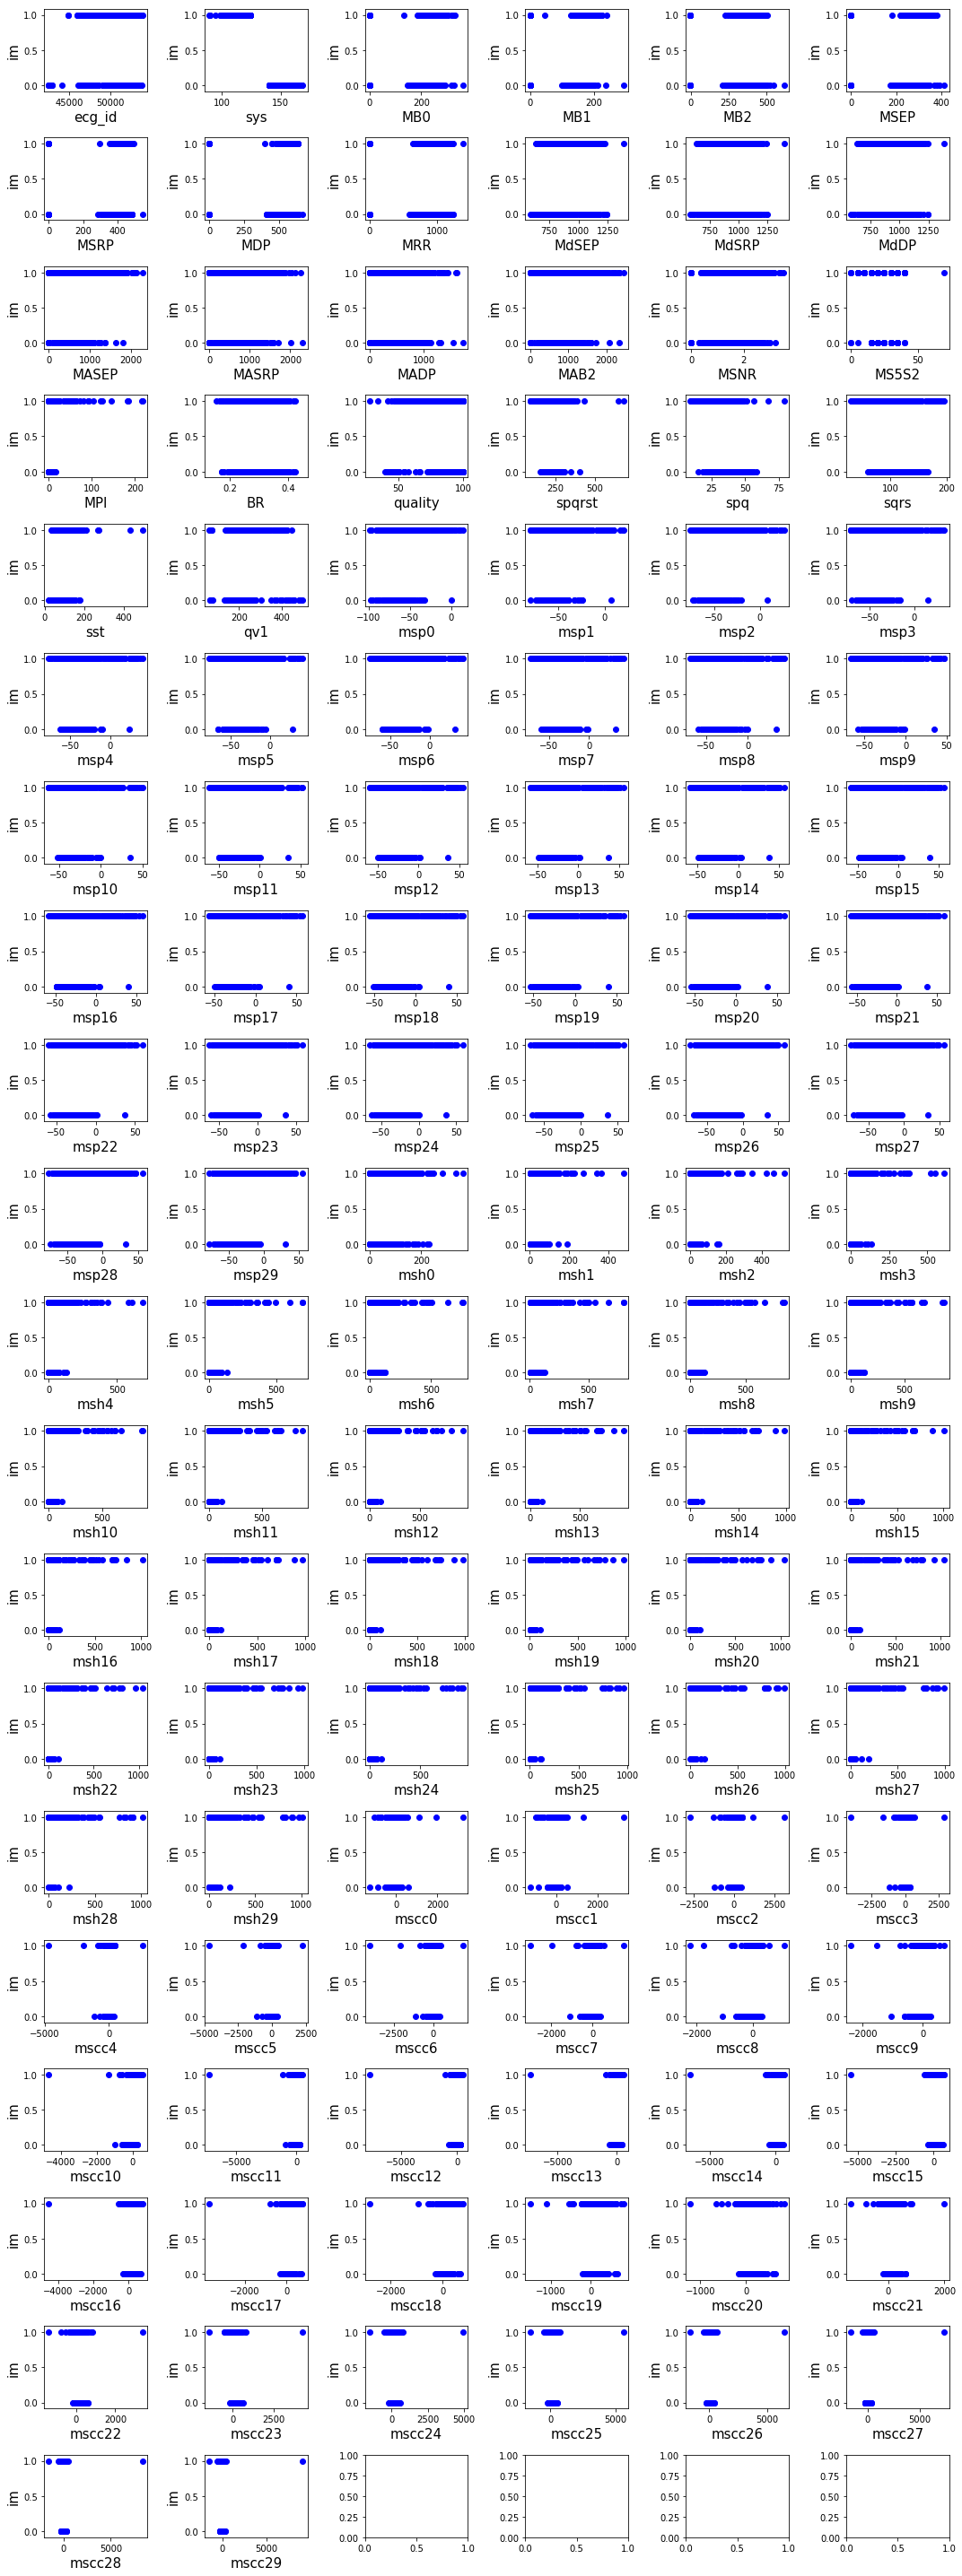

In [631]:
plots(X_train, y_train, figsize=(15, 40))

In [632]:
check_corrupted(X_train, 30)

sys corrupted: 124 -> 99
sys corrupted: 122 -> 69
sys corrupted: 120 -> 67
sys corrupted: 118 -> 66
sys corrupted: 123 -> 42
sys corrupted: 116 -> 37
sys corrupted: 140 -> 31
MB0 corrupted: 0 -> 60
MB1 corrupted: 0 -> 60
MB1 corrupted: 173 -> 37
MB2 corrupted: -1 -> 60
MSEP corrupted: 0 -> 60
MSRP corrupted: 0 -> 60
MDP corrupted: 0 -> 60
MRR corrupted: 0 -> 60
MASEP corrupted: 0.0 -> 60
MASRP corrupted: 0.0 -> 60
MADP corrupted: 0.0 -> 60
MAB2 corrupted: 0.0 -> 60
MSNR corrupted: 0.0 -> 60
MS5S2 corrupted: 30 -> 384
MS5S2 corrupted: 35 -> 171
MS5S2 corrupted: 25 -> 142
MS5S2 corrupted: 20 -> 60
MPI corrupted: 0.0 -> 60
BR corrupted: 0.238889 -> 36
BR corrupted: 0.255556 -> 34
BR corrupted: 0.25 -> 34
quality corrupted: 100 -> 185
quality corrupted: 99 -> 108
quality corrupted: 98 -> 54
quality corrupted: 96 -> 31
quality corrupted: 91 -> 31


In [633]:
X_train.drop(['sys', 'ecg_id'], axis=1, inplace=True)
X_test.drop(['sys', 'ecg_id'], axis=1, inplace=True)

In [634]:
X_train_cur, X_test_cur, y_train_cur, y_test_cur = preprocess_data(X_train, X_test, y_train, y_test)

/home/nikolai.korolev/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [685]:
net_1 = single_net(X_train_cur, y_train_cur, iterations=10000)

Iteration 0: Loss: 0.25802403688430786 MSE: 0.25802403688430786
Iteration 500: Loss: 0.07567615807056427 MSE: 0.07567615807056427
Iteration 1000: Loss: 0.042000968009233475 MSE: 0.042000968009233475
Iteration 1500: Loss: 0.03220883384346962 MSE: 0.03220883384346962
Iteration 2000: Loss: 0.02460215426981449 MSE: 0.02460215426981449
Iteration 2500: Loss: 0.02200259454548359 MSE: 0.02200259454548359
Iteration 3000: Loss: 0.021000202745199203 MSE: 0.021000202745199203
Iteration 3500: Loss: 0.019882798194885254 MSE: 0.019882798194885254
Iteration 4000: Loss: 0.0195551048964262 MSE: 0.0195551048964262
Iteration 4500: Loss: 0.01937279850244522 MSE: 0.01937279850244522
Iteration 5000: Loss: 0.2859908640384674 MSE: 0.2859908640384674
Iteration 5500: Loss: 0.20422905683517456 MSE: 0.20422905683517456
Iteration 6000: Loss: 0.20422880351543427 MSE: 0.20422880351543427
Iteration 6500: Loss: 0.20422877371311188 MSE: 0.20422877371311188
Iteration 7000: Loss: 0.20422880351543427 MSE: 0.204228803515434

In [686]:
summary(net_1, X_train_cur, X_test_cur, y_train_cur, y_test_cur)

Train data:
	ROC AUC:	0.9724485753897518
	MSE:		0.01918604038655758
	Accuracy:	0.9807692307692307
	Correct:	816
	Incorrect:	16
Test data:
	ROC AUC:	0.7845816186556926
	MSE:		0.17162223160266876
	Accuracy:	0.804040404040404
	Correct:	398
	Incorrect:	97


In [659]:
net_2 = multi_net(X_train_cur, y_train_cur,
                  nets=100,
                  iterations_single=1001,
                  iterations_ensemble=10000,
                  hidden_size_ensemble=80,
                  heterogeneity=1e-6)

Iteration 0: Loss: 0.33174529671669006 MSE: 0.33174529671669006
Iteration 500: Loss: 0.20422840118408203 MSE: 0.20422840118408203
Iteration 1000: Loss: 0.20422711968421936 MSE: 0.20422711968421936


Iteration 0: Loss: 0.20452843606472015 MSE: 0.20452937483787537
Iteration 500: Loss: 0.07465343922376633 MSE: 0.07466880977153778
Iteration 1000: Loss: 0.07213887572288513 MSE: 0.07216323167085648


Iteration 0: Loss: 0.3530266582965851 MSE: 0.35303884744644165
Iteration 500: Loss: 0.09403792768716812 MSE: 0.09405975788831711
Iteration 1000: Loss: 0.03728664293885231 MSE: 0.037332676351070404


Iteration 0: Loss: 0.20506276190280914 MSE: 0.2050822377204895
Iteration 500: Loss: 0.05427608639001846 MSE: 0.05431223660707474
Iteration 1000: Loss: 0.04429672658443451 MSE: 0.04434124380350113


Iteration 0: Loss: 0.20700007677078247 MSE: 0.2070210576057434
Iteration 500: Loss: 0.05697533115744591 MSE: 0.05701109394431114
Iteration 1000: Loss: 0.04482465237379074 MSE: 0.044867198914289474


Iteration 0: Loss: 0.2914971113204956 MSE: 0.29151856899261475
Iteration 500: Loss: 0.204200878739357 MSE: 0.20422309637069702
Iteration 1000: Loss: 0.04601757973432541 MSE: 0.04606335982680321


Iteration 0: Loss: 0.20468762516975403 MSE: 0.20470944046974182
Iteration 500: Loss: 0.07362628728151321 MSE: 0.07366277277469635
Iteration 1000: Loss: 0.07197246700525284 MSE: 0.0720161572098732


Iteration 0: Loss: 0.2359849214553833 MSE: 0.2360069900751114
Iteration 500: Loss: 0.04615097865462303 MSE: 0.046189188957214355
Iteration 1000: Loss: 0.03460753336548805 MSE: 0.0346580408513546


Iteration 0: Loss: 0.2636661231517792 MSE: 0.2636893093585968
Iteration 500: Loss: 0.20419007539749146 MSE: 0.20421385765075684
Iteration 1000: Loss: 0.04134524613618851 MSE: 0.041396304965019226


Iteration 0: Loss: 0.22966790199279785 MSE: 0.22969157993793488
Iteration 500: Loss: 0.08264718949794769 MSE: 0.0826808288693428
Iteration 1000: Loss: 0.03979896754026413 MSE: 0.039851248264312744


Iteration 0: Loss: 0.20414504408836365 MSE: 0.2041691690683365
Iteration 500: Loss: 0.05575226992368698 MSE: 0.05579008162021637
Iteration 1000: Loss: 0.045321788638830185 MSE: 0.045366544276475906


Iteration 0: Loss: 0.23426638543605804 MSE: 0.23429033160209656
Iteration 500: Loss: 0.05317360907793045 MSE: 0.05321522057056427
Iteration 1000: Loss: 0.031131476163864136 MSE: 0.031187497079372406


Iteration 0: Loss: 0.2707810401916504 MSE: 0.2708057761192322
Iteration 500: Loss: 0.20420296490192413 MSE: 0.20422863960266113
Iteration 1000: Loss: 0.20420172810554504 MSE: 0.20422856509685516


Iteration 0: Loss: 0.2571219503879547 MSE: 0.25714489817619324
Iteration 500: Loss: 0.053967781364917755 MSE: 0.05400460585951805
Iteration 1000: Loss: 0.0375705324113369 MSE: 0.03761862963438034


Iteration 0: Loss: 0.20514041185379028 MSE: 0.20516368746757507
Iteration 500: Loss: 0.07670430839061737 MSE: 0.07674379646778107
Iteration 1000: Loss: 0.07047057151794434 MSE: 0.07051504403352737


Iteration 0: Loss: 0.27214789390563965 MSE: 0.27217093110084534
Iteration 500: Loss: 0.2042047530412674 MSE: 0.20422862470149994
Iteration 1000: Loss: 0.20420336723327637 MSE: 0.20422853529453278


Iteration 0: Loss: 0.33659303188323975 MSE: 0.336614727973938
Iteration 500: Loss: 0.20420613884925842 MSE: 0.20422855019569397
Iteration 1000: Loss: 0.2042052298784256 MSE: 0.20422810316085815


Iteration 0: Loss: 0.39381343126296997 MSE: 0.3938339650630951
Iteration 500: Loss: 0.20420755445957184 MSE: 0.20422862470149994
Iteration 1000: Loss: 0.20420733094215393 MSE: 0.20422855019569397


Iteration 0: Loss: 0.20785152912139893 MSE: 0.2078709602355957
Iteration 500: Loss: 0.050035882741212845 MSE: 0.05007397383451462
Iteration 1000: Loss: 0.040378063917160034 MSE: 0.040423862636089325


Iteration 0: Loss: 0.29313698410987854 MSE: 0.2931567430496216
Iteration 500: Loss: 0.07635770738124847 MSE: 0.07639086991548538
Iteration 1000: Loss: 0.06978048384189606 MSE: 0.0698217824101448


Iteration 0: Loss: 0.3895607888698578 MSE: 0.3895806670188904
Iteration 500: Loss: 0.20420758426189423 MSE: 0.2042279839515686
Iteration 1000: Loss: 0.2042037397623062 MSE: 0.20422443747520447


Iteration 0: Loss: 0.4300020933151245 MSE: 0.4300210773944855
Iteration 500: Loss: 0.2042090892791748 MSE: 0.20422866940498352
Iteration 1000: Loss: 0.20420894026756287 MSE: 0.20422866940498352


Iteration 0: Loss: 0.2629902958869934 MSE: 0.2630084455013275
Iteration 500: Loss: 0.15923979878425598 MSE: 0.15926197171211243
Iteration 1000: Loss: 0.04028536006808281 MSE: 0.040326181799173355


Iteration 0: Loss: 0.21168562769889832 MSE: 0.21170400083065033
Iteration 500: Loss: 0.04652591422200203 MSE: 0.04656551405787468
Iteration 1000: Loss: 0.029401414096355438 MSE: 0.029457280412316322


Iteration 0: Loss: 0.3750075399875641 MSE: 0.37502673268318176
Iteration 500: Loss: 0.20420876145362854 MSE: 0.20422857999801636
Iteration 1000: Loss: 0.20420826971530914 MSE: 0.20422837138175964


Iteration 0: Loss: 0.27550938725471497 MSE: 0.27552783489227295
Iteration 500: Loss: 0.20420949161052704 MSE: 0.20422862470149994
Iteration 1000: Loss: 0.2042088508605957 MSE: 0.20422856509685516


Iteration 0: Loss: 0.2819253206253052 MSE: 0.28194311261177063
Iteration 500: Loss: 0.2042100876569748 MSE: 0.2042284607887268
Iteration 1000: Loss: 0.20420779287815094 MSE: 0.2042265087366104


Iteration 0: Loss: 0.30668047070503235 MSE: 0.30669766664505005
Iteration 500: Loss: 0.20421084761619568 MSE: 0.2042284905910492
Iteration 1000: Loss: 0.20420880615711212 MSE: 0.20422659814357758


Iteration 0: Loss: 0.3486817479133606 MSE: 0.34869834780693054
Iteration 500: Loss: 0.20421138405799866 MSE: 0.20422856509685516
Iteration 1000: Loss: 0.20421086251735687 MSE: 0.2042282372713089


Iteration 0: Loss: 0.37116414308547974 MSE: 0.3711802065372467
Iteration 500: Loss: 0.20421183109283447 MSE: 0.204228475689888
Iteration 1000: Loss: 0.20421096682548523 MSE: 0.2042277455329895


Iteration 0: Loss: 0.21400469541549683 MSE: 0.2140202820301056
Iteration 500: Loss: 0.07215981185436249 MSE: 0.07219494879245758
Iteration 1000: Loss: 0.042082712054252625 MSE: 0.04213612526655197


Iteration 0: Loss: 0.20563971996307373 MSE: 0.2056560516357422
Iteration 500: Loss: 0.07366737723350525 MSE: 0.07369907945394516
Iteration 1000: Loss: 0.07182171195745468 MSE: 0.07186270505189896


Iteration 0: Loss: 0.24232731759548187 MSE: 0.24234390258789062
Iteration 500: Loss: 0.06414227187633514 MSE: 0.06417030841112137
Iteration 1000: Loss: 0.03998095914721489 MSE: 0.040020279586315155


Iteration 0: Loss: 0.21139775216579437 MSE: 0.21141456067562103
Iteration 500: Loss: 0.049980465322732925 MSE: 0.05001671612262726
Iteration 1000: Loss: 0.03671981394290924 MSE: 0.03677034750580788


Iteration 0: Loss: 0.25769710540771484 MSE: 0.2577144205570221
Iteration 500: Loss: 0.04676501452922821 MSE: 0.0468008853495121
Iteration 1000: Loss: 0.034748632460832596 MSE: 0.03479818254709244


Iteration 0: Loss: 0.2529893219470978 MSE: 0.25300711393356323
Iteration 500: Loss: 0.2042098492383957 MSE: 0.20422853529453278
Iteration 1000: Loss: 0.09597381204366684 MSE: 0.09600010514259338


Iteration 0: Loss: 0.28040432929992676 MSE: 0.2804218828678131
Iteration 500: Loss: 0.2042090743780136 MSE: 0.20422710478305817
Iteration 1000: Loss: 0.08008865267038345 MSE: 0.08011726289987564


Iteration 0: Loss: 0.5021767616271973 MSE: 0.5021941661834717
Iteration 500: Loss: 0.20421059429645538 MSE: 0.20422866940498352
Iteration 1000: Loss: 0.20421040058135986 MSE: 0.20422856509685516


Iteration 0: Loss: 0.21580341458320618 MSE: 0.21582038700580597
Iteration 500: Loss: 0.0662936195731163 MSE: 0.06633170694112778
Iteration 1000: Loss: 0.032738447189331055 MSE: 0.032798588275909424


Iteration 0: Loss: 0.26068976521492004 MSE: 0.26070740818977356
Iteration 500: Loss: 0.20420558750629425 MSE: 0.20422373712062836
Iteration 1000: Loss: 0.04146629944443703 MSE: 0.041507892310619354


Iteration 0: Loss: 0.32349300384521484 MSE: 0.3235108256340027
Iteration 500: Loss: 0.20420929789543152 MSE: 0.20422767102718353
Iteration 1000: Loss: 0.08217109739780426 MSE: 0.08219783753156662


Iteration 0: Loss: 0.2077770233154297 MSE: 0.2077946662902832
Iteration 500: Loss: 0.07232935726642609 MSE: 0.07236535847187042
Iteration 1000: Loss: 0.04950973764061928 MSE: 0.04956624284386635


Iteration 0: Loss: 0.248039111495018 MSE: 0.2480572611093521
Iteration 500: Loss: 0.05566397309303284 MSE: 0.055698320269584656
Iteration 1000: Loss: 0.036421116441488266 MSE: 0.03647319972515106


Iteration 0: Loss: 0.3434421718120575 MSE: 0.34346070885658264
Iteration 500: Loss: 0.20420916378498077 MSE: 0.2042282521724701
Iteration 1000: Loss: 0.20420771837234497 MSE: 0.20422697067260742


Iteration 0: Loss: 0.20420950651168823 MSE: 0.20422767102718353
Iteration 500: Loss: 0.07640320062637329 MSE: 0.07643422484397888
Iteration 1000: Loss: 0.07507652789354324 MSE: 0.07511533051729202


Iteration 0: Loss: 0.23203864693641663 MSE: 0.2320568859577179
Iteration 500: Loss: 0.05761084333062172 MSE: 0.057645149528980255
Iteration 1000: Loss: 0.034092191606760025 MSE: 0.03414010629057884


Iteration 0: Loss: 0.33917027711868286 MSE: 0.3391887843608856
Iteration 500: Loss: 0.20420949161052704 MSE: 0.20422862470149994
Iteration 1000: Loss: 0.2042090743780136 MSE: 0.20422843098640442


Iteration 0: Loss: 0.2655009329319 MSE: 0.26551908254623413
Iteration 500: Loss: 0.20420977473258972 MSE: 0.20422855019569397
Iteration 1000: Loss: 0.1577415019273758 MSE: 0.1577645093202591


Iteration 0: Loss: 0.22050033509731293 MSE: 0.22051820158958435
Iteration 500: Loss: 0.043245043605566025 MSE: 0.04328237101435661
Iteration 1000: Loss: 0.030984459444880486 MSE: 0.031032979488372803


Iteration 0: Loss: 0.23520725965499878 MSE: 0.23522542417049408
Iteration 500: Loss: 0.05623803287744522 MSE: 0.0562727116048336
Iteration 1000: Loss: 0.0357842817902565 MSE: 0.03583500534296036


Iteration 0: Loss: 0.24515336751937866 MSE: 0.24517187476158142
Iteration 500: Loss: 0.08380116522312164 MSE: 0.08383341133594513
Iteration 1000: Loss: 0.07054246217012405 MSE: 0.07057979702949524


Iteration 0: Loss: 0.21784284710884094 MSE: 0.2178613543510437
Iteration 500: Loss: 0.10393335670232773 MSE: 0.10397201031446457
Iteration 1000: Loss: 0.050141822546720505 MSE: 0.0501897968351841


Iteration 0: Loss: 0.2081843763589859 MSE: 0.20820313692092896
Iteration 500: Loss: 0.05119208246469498 MSE: 0.05122939124703407
Iteration 1000: Loss: 0.03607581555843353 MSE: 0.03612289950251579


Iteration 0: Loss: 0.2622752785682678 MSE: 0.2622942328453064
Iteration 500: Loss: 0.204209104180336 MSE: 0.20422862470149994
Iteration 1000: Loss: 0.2042081654071808 MSE: 0.204228475689888


Iteration 0: Loss: 0.38278278708457947 MSE: 0.3828014135360718
Iteration 500: Loss: 0.20420922338962555 MSE: 0.2042286992073059
Iteration 1000: Loss: 0.2042081207036972 MSE: 0.2042286992073059


Iteration 0: Loss: 0.23511481285095215 MSE: 0.23513314127922058
Iteration 500: Loss: 0.20420970022678375 MSE: 0.20422862470149994
Iteration 1000: Loss: 0.09362693130970001 MSE: 0.09365364909172058


Iteration 0: Loss: 0.329130083322525 MSE: 0.32914823293685913
Iteration 500: Loss: 0.20420993864536285 MSE: 0.20422862470149994
Iteration 1000: Loss: 0.2042095810174942 MSE: 0.2042284607887268


Iteration 0: Loss: 0.2817280888557434 MSE: 0.28174594044685364
Iteration 500: Loss: 0.2042100876569748 MSE: 0.2042284905910492
Iteration 1000: Loss: 0.20420898497104645 MSE: 0.2042275369167328


Iteration 0: Loss: 0.2729097604751587 MSE: 0.27292731404304504
Iteration 500: Loss: 0.2042098492383957 MSE: 0.20422786474227905
Iteration 1000: Loss: 0.07879514247179031 MSE: 0.07882580161094666


Iteration 0: Loss: 0.20438681542873383 MSE: 0.2044043242931366
Iteration 500: Loss: 0.07387394458055496 MSE: 0.07390661537647247
Iteration 1000: Loss: 0.07226983457803726 MSE: 0.0723096951842308


Iteration 0: Loss: 0.44612830877304077 MSE: 0.4461458921432495
Iteration 500: Loss: 0.20421043038368225 MSE: 0.20422866940498352
Iteration 1000: Loss: 0.2042103260755539 MSE: 0.20422863960266113


Iteration 0: Loss: 0.23453514277935028 MSE: 0.23455245792865753
Iteration 500: Loss: 0.07677411288022995 MSE: 0.07680848985910416
Iteration 1000: Loss: 0.04871199280023575 MSE: 0.04876619949936867


Iteration 0: Loss: 0.21061576902866364 MSE: 0.21063338220119476
Iteration 500: Loss: 0.0749751627445221 MSE: 0.07501343637704849
Iteration 1000: Loss: 0.038048818707466125 MSE: 0.03809913992881775


Iteration 0: Loss: 0.2789019048213959 MSE: 0.2789197862148285
Iteration 500: Loss: 0.0951913371682167 MSE: 0.09521716088056564
Iteration 1000: Loss: 0.034501515328884125 MSE: 0.034551993012428284


Iteration 0: Loss: 0.20983460545539856 MSE: 0.20985275506973267
Iteration 500: Loss: 0.07281138002872467 MSE: 0.07285041362047195
Iteration 1000: Loss: 0.04752129688858986 MSE: 0.04758182913064957


Iteration 0: Loss: 0.30286502838134766 MSE: 0.3028835654258728
Iteration 500: Loss: 0.20420882105827332 MSE: 0.20422789454460144
Iteration 1000: Loss: 0.0804738774895668 MSE: 0.08050220459699631


Iteration 0: Loss: 0.38212767243385315 MSE: 0.38214609026908875
Iteration 500: Loss: 0.20420955121517181 MSE: 0.20422856509685516
Iteration 1000: Loss: 0.20420920848846436 MSE: 0.20422832667827606


Iteration 0: Loss: 0.38250112533569336 MSE: 0.38251927495002747
Iteration 500: Loss: 0.20420978963375092 MSE: 0.20422853529453278
Iteration 1000: Loss: 0.20420882105827332 MSE: 0.2042277455329895


Iteration 0: Loss: 0.2911442220211029 MSE: 0.2911621332168579
Iteration 500: Loss: 0.20420967042446136 MSE: 0.2042279988527298
Iteration 1000: Loss: 0.2042047530412674 MSE: 0.204223170876503


Iteration 0: Loss: 0.21503102779388428 MSE: 0.215048685669899
Iteration 500: Loss: 0.04656272381544113 MSE: 0.046602532267570496
Iteration 1000: Loss: 0.029280737042427063 MSE: 0.029335204511880875


Iteration 0: Loss: 0.24617576599121094 MSE: 0.24619373679161072
Iteration 500: Loss: 0.20420745015144348 MSE: 0.20422641932964325
Iteration 1000: Loss: 0.07274385541677475 MSE: 0.07279439270496368


Iteration 0: Loss: 0.2087186723947525 MSE: 0.2087368369102478
Iteration 500: Loss: 0.04960406944155693 MSE: 0.04964251071214676
Iteration 1000: Loss: 0.0406494215130806 MSE: 0.04069866985082626


Iteration 0: Loss: 0.28000888228416443 MSE: 0.28002724051475525
Iteration 500: Loss: 0.20420600473880768 MSE: 0.20422568917274475
Iteration 1000: Loss: 0.07188096642494202 MSE: 0.07192567735910416


Iteration 0: Loss: 0.2059527039527893 MSE: 0.2059711515903473
Iteration 500: Loss: 0.07384975254535675 MSE: 0.07388603687286377
Iteration 1000: Loss: 0.07193069905042648 MSE: 0.07197994738817215


Iteration 0: Loss: 0.42658236622810364 MSE: 0.42660096287727356
Iteration 500: Loss: 0.08468383550643921 MSE: 0.08471508324146271
Iteration 1000: Loss: 0.0729585513472557 MSE: 0.07300256192684174


Iteration 0: Loss: 0.20534242689609528 MSE: 0.20536111295223236
Iteration 500: Loss: 0.08652059733867645 MSE: 0.08655388653278351
Iteration 1000: Loss: 0.07435226440429688 MSE: 0.07439053803682327


Iteration 0: Loss: 0.22575290501117706 MSE: 0.22577160596847534
Iteration 500: Loss: 0.08245576173067093 MSE: 0.08248303830623627
Iteration 1000: Loss: 0.03664184734225273 MSE: 0.036690883338451385


Iteration 0: Loss: 0.22908419370651245 MSE: 0.22910305857658386
Iteration 500: Loss: 0.10565121471881866 MSE: 0.10567759722471237
Iteration 1000: Loss: 0.03482966870069504 MSE: 0.03487785533070564


Iteration 0: Loss: 0.2052052915096283 MSE: 0.20522430539131165
Iteration 500: Loss: 0.05294712260365486 MSE: 0.052982788532972336
Iteration 1000: Loss: 0.04370835795998573 MSE: 0.04375201463699341


Iteration 0: Loss: 0.2916143834590912 MSE: 0.2916334867477417
Iteration 500: Loss: 0.20416654646396637 MSE: 0.20418623089790344
Iteration 1000: Loss: 0.04141579195857048 MSE: 0.0414620116353035


Iteration 0: Loss: 0.23726674914360046 MSE: 0.23728595674037933
Iteration 500: Loss: 0.20420856773853302 MSE: 0.20422838628292084
Iteration 1000: Loss: 0.07575216144323349 MSE: 0.07579129934310913


Iteration 0: Loss: 0.20441699028015137 MSE: 0.20443619787693024
Iteration 500: Loss: 0.056453440338373184 MSE: 0.056486621499061584
Iteration 1000: Loss: 0.04737016558647156 MSE: 0.04740991070866585


Iteration 0: Loss: 0.395122766494751 MSE: 0.3951420187950134
Iteration 500: Loss: 0.2042086124420166 MSE: 0.20422865450382233
Iteration 1000: Loss: 0.2042049914598465 MSE: 0.2042279988527298


Iteration 0: Loss: 0.20734237134456635 MSE: 0.20736144483089447
Iteration 500: Loss: 0.049613479524850845 MSE: 0.04965249449014664
Iteration 1000: Loss: 0.03787767514586449 MSE: 0.03792987018823624


Iteration 0: Loss: 0.2871042788028717 MSE: 0.28712350130081177
Iteration 500: Loss: 0.20420847833156586 MSE: 0.20422838628292084
Iteration 1000: Loss: 0.1069379523396492 MSE: 0.10696571320295334


Iteration 0: Loss: 0.23489469289779663 MSE: 0.23491381108760834
Iteration 500: Loss: 0.07640857249498367 MSE: 0.07644230872392654
Iteration 1000: Loss: 0.03838115558028221 MSE: 0.038428906351327896


Iteration 0: Loss: 0.4814627766609192 MSE: 0.48148199915885925
Iteration 500: Loss: 0.20420879125595093 MSE: 0.20422856509685516
Iteration 1000: Loss: 0.20420844852924347 MSE: 0.2042282670736313


Iteration 0: Loss: 0.2721616327762604 MSE: 0.2721806466579437
Iteration 500: Loss: 0.2042088359594345 MSE: 0.20422856509685516
Iteration 1000: Loss: 0.20420223474502563 MSE: 0.20422282814979553


Iteration 0: Loss: 0.3841231167316437 MSE: 0.3841419219970703
Iteration 500: Loss: 0.20420925319194794 MSE: 0.20422862470149994
Iteration 1000: Loss: 0.2042088806629181 MSE: 0.20422841608524323


Iteration 0: Loss: 0.4116569459438324 MSE: 0.4116755723953247
Iteration 500: Loss: 0.20420946180820465 MSE: 0.20422860980033875
Iteration 1000: Loss: 0.20420919358730316 MSE: 0.20422838628292084


Iteration 0: Loss: 0.20561280846595764 MSE: 0.20563122630119324
Iteration 500: Loss: 0.07419130206108093 MSE: 0.07422436028718948
Iteration 1000: Loss: 0.07157107442617416 MSE: 0.07161372154951096


Iteration 0: Loss: 0.20721998810768127 MSE: 0.20723846554756165
Iteration 500: Loss: 0.0737796351313591 MSE: 0.07381746172904968
Iteration 1000: Loss: 0.07272208482027054 MSE: 0.07277257740497589


Iteration 0: Loss: 0.4790892004966736 MSE: 0.4791078567504883
Iteration 500: Loss: 0.20420938730239868 MSE: 0.20422866940498352
Iteration 1000: Loss: 0.20420929789543152 MSE: 0.20422866940498352


Iteration 0: Loss: 0.3066220283508301 MSE: 0.30664047598838806
Iteration 500: Loss: 0.20419275760650635 MSE: 0.20421172678470612
Iteration 1000: Loss: 0.043954573571681976 MSE: 0.043992821127176285


Iteration 0: Loss: 0.20421040058135986 MSE: 0.20422887802124023
Iteration 500: Loss: 0.05716894939541817 MSE: 0.057201940566301346
Iteration 1000: Loss: 0.046402014791965485 MSE: 0.046442195773124695


Iteration 0: Loss: 0.20899714529514313 MSE: 0.20901566743850708
Iteration 500: Loss: 0.0721944123506546 MSE: 0.0722275897860527
Iteration 1000: Loss: 0.06629618257284164 MSE: 0.06633640825748444


Iteration 0: Loss: 0.20788782835006714 MSE: 0.20790639519691467
Iteration 500: Loss: 0.048906110227108 MSE: 0.048943500965833664
Iteration 1000: Loss: 0.04067106544971466 MSE: 0.04071681201457977


Iteration 0: Loss: 0.20723795890808105 MSE: 0.20725661516189575
Iteration 500: Loss: 0.0710953027009964 MSE: 0.07112853974103928
Iteration 1000: Loss: 0.06558701395988464 MSE: 0.06562589854001999


Iteration 0: Loss: 0.22944366931915283 MSE: 0.2294623702764511
Iteration 500: Loss: 0.04080120474100113 MSE: 0.040840230882167816
Iteration 1000: Loss: 0.025660468265414238 MSE: 0.025711756199598312


Iteration 0: Loss: 0.20772092044353485 MSE: 0.20773977041244507
Iteration 500: Loss: 0.0727151557803154 MSE: 0.07275383919477463
Iteration 1000: Loss: 0.0396651066839695 MSE: 0.039717383682727814


Iteration 0: Loss: 0.2039821296930313 MSE: 0.2039821296930313
Iteration 500: Loss: 0.01713988557457924 MSE: 0.01713988557457924
Iteration 1000: Loss: 0.016629625111818314 MSE: 0.016629625111818314
Iteration 1500: Loss: 0.01653868891298771 MSE: 0.01653868891298771
Iteration 2000: Loss: 0.01651010289788246 MSE: 0.01651010289788246
Iteration 2500: Loss: 0.01649845577776432 MSE: 0.01649845577776432
Iteration 3000: Loss: 0.016492940485477448 MSE: 0.016492940485477448
Iteration 3500: Loss: 0.016490085050463676 MSE: 0.016490085050463676
Iteration 4000: Loss: 0.016488518565893173 MSE: 0.016488518565893173
Iteration 4500: Loss: 0.016487641260027885 MSE: 0.016487641260027885
Iteration 5000: Loss: 0.01648714207112789 MSE: 0.01648714207112789
Iteration 5500: Loss: 0.016486862674355507 MSE: 0.016486862674355507
Iteration 6000: Loss: 0.016486704349517822 MSE: 0.016486704349517822
Iteration 6500: Loss: 0.01648661307990551 MSE: 0.01648661307990551
Iteration 7000: Loss: 0.01648656278848648 MSE: 0.01648

In [660]:
summary(net_2, X_train_cur, X_test_cur, y_train_cur, y_test_cur)

Train data:
	ROC AUC:	0.970590003678239
	MSE:		0.016486454755067825
	Accuracy:	0.9831730769230769
	Correct:	818
	Incorrect:	14
Test data:
	ROC AUC:	0.7858230452674897
	MSE:		0.19170637428760529
	Accuracy:	0.802020202020202
	Correct:	397
	Incorrect:	98


In [661]:
net_3 = multi_net(X_train_cur, y_train_cur,
                  nets=100,
                  iterations_single=1001,
                  iterations_ensemble=10000,
                  hidden_size_ensemble=80,
                  heterogeneity=1e-5)

Iteration 0: Loss: 0.33488479256629944 MSE: 0.33488479256629944
Iteration 500: Loss: 0.2042282372713089 MSE: 0.2042282372713089
Iteration 1000: Loss: 0.20422203838825226 MSE: 0.20422203838825226


Iteration 0: Loss: 0.2209700644016266 MSE: 0.22098104655742645
Iteration 500: Loss: 0.06251320242881775 MSE: 0.06276866793632507
Iteration 1000: Loss: 0.03545791283249855 MSE: 0.03585262969136238


Iteration 0: Loss: 0.34446775913238525 MSE: 0.344663143157959
Iteration 500: Loss: 0.20331327617168427 MSE: 0.2042289525270462
Iteration 1000: Loss: 0.19593383371829987 MSE: 0.20422889292240143


Iteration 0: Loss: 0.33592140674591064 MSE: 0.33840370178222656
Iteration 500: Loss: 0.2001868635416031 MSE: 0.20422960817813873
Iteration 1000: Loss: 0.19151540100574493 MSE: 0.20423005521297455


Iteration 0: Loss: 0.20177465677261353 MSE: 0.20543155074119568
Iteration 500: Loss: 0.04702487960457802 MSE: 0.0509001761674881
Iteration 1000: Loss: 0.03859618306159973 MSE: 0.042617060244083405


Iteration 0: Loss: 0.24259108304977417 MSE: 0.24557195603847504
Iteration 500: Loss: 0.19970156252384186 MSE: 0.2042275369167328
Iteration 1000: Loss: 0.02339755743741989 MSE: 0.03732124716043472


Iteration 0: Loss: 0.35562676191329956 MSE: 0.3596746325492859
Iteration 500: Loss: 0.199981227517128 MSE: 0.20422881841659546
Iteration 1000: Loss: 0.1981746107339859 MSE: 0.204227477312088


Iteration 0: Loss: 0.21220563352108002 MSE: 0.2158868908882141
Iteration 500: Loss: 0.04279039427638054 MSE: 0.046757910400629044
Iteration 1000: Loss: 0.03479166328907013 MSE: 0.03895413130521774


Iteration 0: Loss: 0.21357306838035583 MSE: 0.21684995293617249
Iteration 500: Loss: 0.03965410217642784 MSE: 0.043802354484796524
Iteration 1000: Loss: 0.024635812267661095 MSE: 0.03369992598891258


Iteration 0: Loss: 0.22015845775604248 MSE: 0.2236804962158203
Iteration 500: Loss: 0.04156659170985222 MSE: 0.04533957690000534
Iteration 1000: Loss: 0.029914818704128265 MSE: 0.03412044793367386


Iteration 0: Loss: 0.4080297350883484 MSE: 0.4112604558467865
Iteration 500: Loss: 0.20091915130615234 MSE: 0.20422841608524323
Iteration 1000: Loss: 0.20015811920166016 MSE: 0.20422744750976562


Iteration 0: Loss: 0.29480791091918945 MSE: 0.29780352115631104
Iteration 500: Loss: 0.20115245878696442 MSE: 0.20422856509685516
Iteration 1000: Loss: 0.19374914467334747 MSE: 0.19800026714801788


Iteration 0: Loss: 0.2589135766029358 MSE: 0.2617492079734802
Iteration 500: Loss: 0.19871367514133453 MSE: 0.2016507238149643
Iteration 1000: Loss: 0.036980561912059784 MSE: 0.04052260145545006


Iteration 0: Loss: 0.20157267153263092 MSE: 0.20423786342144012
Iteration 500: Loss: 0.053533535450696945 MSE: 0.056353215128183365
Iteration 1000: Loss: 0.043987952172756195 MSE: 0.04687974601984024


Iteration 0: Loss: 0.22640514373779297 MSE: 0.22889576852321625
Iteration 500: Loss: 0.04004102572798729 MSE: 0.04278945177793503
Iteration 1000: Loss: 0.022111594676971436 MSE: 0.02530459687113762


Iteration 0: Loss: 0.2800065577030182 MSE: 0.2823750078678131
Iteration 500: Loss: 0.20182721316814423 MSE: 0.20422658324241638
Iteration 1000: Loss: 0.050968948751688004 MSE: 0.05387449264526367


Iteration 0: Loss: 0.44890737533569336 MSE: 0.45115816593170166
Iteration 500: Loss: 0.20195645093917847 MSE: 0.2042287141084671
Iteration 1000: Loss: 0.20162872970104218 MSE: 0.20422878861427307


Iteration 0: Loss: 0.32718831300735474 MSE: 0.32932499051094055
Iteration 500: Loss: 0.20188204944133759 MSE: 0.20422866940498352
Iteration 1000: Loss: 0.19792580604553223 MSE: 0.2042282223701477


Iteration 0: Loss: 0.2128801941871643 MSE: 0.21512439846992493
Iteration 500: Loss: 0.04077150300145149 MSE: 0.04356604814529419
Iteration 1000: Loss: 0.027398673817515373 MSE: 0.03406457230448723


Iteration 0: Loss: 0.30399805307388306 MSE: 0.3063506782054901
Iteration 500: Loss: 0.20179866254329681 MSE: 0.2042282223701477
Iteration 1000: Loss: 0.19992800056934357 MSE: 0.20422451198101044


Iteration 0: Loss: 0.45192912220954895 MSE: 0.4542539715766907
Iteration 500: Loss: 0.20188051462173462 MSE: 0.20422862470149994
Iteration 1000: Loss: 0.20154543220996857 MSE: 0.20422837138175964


Iteration 0: Loss: 0.20228737592697144 MSE: 0.2045166790485382
Iteration 500: Loss: 0.07133784145116806 MSE: 0.07375481724739075
Iteration 1000: Loss: 0.06984154134988785 MSE: 0.07239831238985062


Iteration 0: Loss: 0.22124461829662323 MSE: 0.22338733077049255
Iteration 500: Loss: 0.04100479558110237 MSE: 0.04344552010297775
Iteration 1000: Loss: 0.026296060532331467 MSE: 0.029857255518436432


Iteration 0: Loss: 0.2597678601741791 MSE: 0.26187723875045776
Iteration 500: Loss: 0.2020711749792099 MSE: 0.20422524213790894
Iteration 1000: Loss: 0.047491129487752914 MSE: 0.05025394260883331


Iteration 0: Loss: 0.21306173503398895 MSE: 0.21510857343673706
Iteration 500: Loss: 0.04221603646874428 MSE: 0.04451286420226097
Iteration 1000: Loss: 0.030286986380815506 MSE: 0.033534131944179535


Iteration 0: Loss: 0.36172112822532654 MSE: 0.36373335123062134
Iteration 500: Loss: 0.20219890773296356 MSE: 0.20422840118408203
Iteration 1000: Loss: 0.20184765756130219 MSE: 0.20422762632369995


Iteration 0: Loss: 0.3842950761318207 MSE: 0.3862433135509491
Iteration 500: Loss: 0.20224519073963165 MSE: 0.20422866940498352
Iteration 1000: Loss: 0.20132046937942505 MSE: 0.2042287141084671


Iteration 0: Loss: 0.2517375946044922 MSE: 0.25364744663238525
Iteration 500: Loss: 0.20223897695541382 MSE: 0.2042268067598343
Iteration 1000: Loss: 0.0486634261906147 MSE: 0.05182061716914177


Iteration 0: Loss: 0.24574318528175354 MSE: 0.24762824177742004
Iteration 500: Loss: 0.20209653675556183 MSE: 0.20422853529453278
Iteration 1000: Loss: 0.058816201984882355 MSE: 0.06685008108615875


Iteration 0: Loss: 0.2350447177886963 MSE: 0.23707301914691925
Iteration 500: Loss: 0.07571607828140259 MSE: 0.07787717878818512
Iteration 1000: Loss: 0.048079200088977814 MSE: 0.050612423568964005


Iteration 0: Loss: 0.217169851064682 MSE: 0.21914640069007874
Iteration 500: Loss: 0.07341224700212479 MSE: 0.07576146721839905
Iteration 1000: Loss: 0.024639537557959557 MSE: 0.030393077060580254


Iteration 0: Loss: 0.26543721556663513 MSE: 0.2674695551395416
Iteration 500: Loss: 0.20122487843036652 MSE: 0.20422770082950592
Iteration 1000: Loss: 0.02201552875339985 MSE: 0.037844959646463394


Iteration 0: Loss: 0.21290186047554016 MSE: 0.215293750166893
Iteration 500: Loss: 0.04328177124261856 MSE: 0.045955851674079895
Iteration 1000: Loss: 0.036515429615974426 MSE: 0.04000905528664589


Iteration 0: Loss: 0.23594389855861664 MSE: 0.23829613626003265
Iteration 500: Loss: 0.049618467688560486 MSE: 0.05216233432292938
Iteration 1000: Loss: 0.027108948677778244 MSE: 0.030025366693735123


Iteration 0: Loss: 0.28749650716781616 MSE: 0.2897956967353821
Iteration 500: Loss: 0.055263716727495193 MSE: 0.057730529457330704
Iteration 1000: Loss: 0.03095385991036892 MSE: 0.03365834802389145


Iteration 0: Loss: 0.2020404040813446 MSE: 0.20428532361984253
Iteration 500: Loss: 0.04894901439547539 MSE: 0.051361482590436935
Iteration 1000: Loss: 0.039745405316352844 MSE: 0.04226415976881981


Iteration 0: Loss: 0.20487798750400543 MSE: 0.20706799626350403
Iteration 500: Loss: 0.047462575137615204 MSE: 0.04982718080282211
Iteration 1000: Loss: 0.0397099032998085 MSE: 0.042166195809841156


Iteration 0: Loss: 0.24095408618450165 MSE: 0.24309231340885162
Iteration 500: Loss: 0.04403223842382431 MSE: 0.0464291051030159
Iteration 1000: Loss: 0.027402617037296295 MSE: 0.03024793416261673


Iteration 0: Loss: 0.2599109709262848 MSE: 0.262010782957077
Iteration 500: Loss: 0.19864004850387573 MSE: 0.20078499615192413
Iteration 1000: Loss: 0.038935381919145584 MSE: 0.04156126081943512


Iteration 0: Loss: 0.4301021099090576 MSE: 0.432160884141922
Iteration 500: Loss: 0.20212291181087494 MSE: 0.20422856509685516
Iteration 1000: Loss: 0.2007208615541458 MSE: 0.20421361923217773


Iteration 0: Loss: 0.34811410307884216 MSE: 0.35015571117401123
Iteration 500: Loss: 0.20211242139339447 MSE: 0.2042286992073059
Iteration 1000: Loss: 0.19985981285572052 MSE: 0.20422886312007904


Iteration 0: Loss: 0.2026946246623993 MSE: 0.20474186539649963
Iteration 500: Loss: 0.05477260425686836 MSE: 0.0569637194275856
Iteration 1000: Loss: 0.04440924525260925 MSE: 0.04667658358812332


Iteration 0: Loss: 0.204087495803833 MSE: 0.20609140396118164
Iteration 500: Loss: 0.05002925544977188 MSE: 0.05221403017640114
Iteration 1000: Loss: 0.03930402174592018 MSE: 0.04156876355409622


Iteration 0: Loss: 0.2794041037559509 MSE: 0.28136757016181946
Iteration 500: Loss: 0.202229842543602 MSE: 0.20422546565532684
Iteration 1000: Loss: 0.06972237676382065 MSE: 0.07257800549268723


Iteration 0: Loss: 0.2023814171552658 MSE: 0.20432010293006897
Iteration 500: Loss: 0.0719466283917427 MSE: 0.07404207438230515
Iteration 1000: Loss: 0.06986018270254135 MSE: 0.0720749944448471


Iteration 0: Loss: 0.2119375616312027 MSE: 0.21383899450302124
Iteration 500: Loss: 0.04461048170924187 MSE: 0.046786461025476456
Iteration 1000: Loss: 0.03317857161164284 MSE: 0.035936228930950165


Iteration 0: Loss: 0.47745153307914734 MSE: 0.47933027148246765
Iteration 500: Loss: 0.20233801007270813 MSE: 0.20422856509685516
Iteration 1000: Loss: 0.20221881568431854 MSE: 0.20422744750976562


Iteration 0: Loss: 0.3055490553379059 MSE: 0.3073905408382416
Iteration 500: Loss: 0.2023746371269226 MSE: 0.2042285054922104
Iteration 1000: Loss: 0.20212386548519135 MSE: 0.2042272388935089


Iteration 0: Loss: 0.21309350430965424 MSE: 0.2149019092321396
Iteration 500: Loss: 0.04132336005568504 MSE: 0.043421950191259384
Iteration 1000: Loss: 0.022161250934004784 MSE: 0.02635495737195015


Iteration 0: Loss: 0.26487651467323303 MSE: 0.26669609546661377
Iteration 500: Loss: 0.20238442718982697 MSE: 0.2042190432548523
Iteration 1000: Loss: 0.041662417352199554 MSE: 0.04382617771625519


Iteration 0: Loss: 0.20253001153469086 MSE: 0.20432010293006897
Iteration 500: Loss: 0.07172054797410965 MSE: 0.07370613515377045
Iteration 1000: Loss: 0.06953760981559753 MSE: 0.0716913640499115


Iteration 0: Loss: 0.26641151309013367 MSE: 0.26817378401756287
Iteration 500: Loss: 0.20244288444519043 MSE: 0.20422370731830597
Iteration 1000: Loss: 0.043619342148303986 MSE: 0.045855309814214706


Iteration 0: Loss: 0.21245793998241425 MSE: 0.21419523656368256
Iteration 500: Loss: 0.044062867760658264 MSE: 0.04651973769068718
Iteration 1000: Loss: 0.02412424609065056 MSE: 0.031627267599105835


Iteration 0: Loss: 0.3735470473766327 MSE: 0.3753594756126404
Iteration 500: Loss: 0.2023964822292328 MSE: 0.20422866940498352
Iteration 1000: Loss: 0.201899453997612 MSE: 0.20422863960266113


Iteration 0: Loss: 0.23186901211738586 MSE: 0.23365718126296997
Iteration 500: Loss: 0.07442656904459 MSE: 0.07658744603395462
Iteration 1000: Loss: 0.027205783873796463 MSE: 0.034191861748695374


Iteration 0: Loss: 0.2129073441028595 MSE: 0.21475651860237122
Iteration 500: Loss: 0.043475501239299774 MSE: 0.045551616698503494
Iteration 1000: Loss: 0.026731546968221664 MSE: 0.02918081171810627


Iteration 0: Loss: 0.31808149814605713 MSE: 0.3199084401130676
Iteration 500: Loss: 0.20239172875881195 MSE: 0.20422838628292084
Iteration 1000: Loss: 0.2022831290960312 MSE: 0.20422765612602234


Iteration 0: Loss: 0.3391418159008026 MSE: 0.3409385681152344
Iteration 500: Loss: 0.20237931609153748 MSE: 0.20420661568641663
Iteration 1000: Loss: 0.04560784250497818 MSE: 0.047673698514699936


Iteration 0: Loss: 0.26075974106788635 MSE: 0.26253029704093933
Iteration 500: Loss: 0.07321932166814804 MSE: 0.07517281174659729
Iteration 1000: Loss: 0.03967123106122017 MSE: 0.04199236258864403


Iteration 0: Loss: 0.22279557585716248 MSE: 0.22454532980918884
Iteration 500: Loss: 0.07852803170681 MSE: 0.0805802270770073
Iteration 1000: Loss: 0.030136318877339363 MSE: 0.036834508180618286


Iteration 0: Loss: 0.35551708936691284 MSE: 0.3573196232318878
Iteration 500: Loss: 0.20232954621315002 MSE: 0.20422866940498352
Iteration 1000: Loss: 0.1989244818687439 MSE: 0.20422865450382233


Iteration 0: Loss: 0.3542691171169281 MSE: 0.3560987114906311
Iteration 500: Loss: 0.10372773557901382 MSE: 0.10565418750047684
Iteration 1000: Loss: 0.04207826033234596 MSE: 0.04428396001458168


Iteration 0: Loss: 0.2571800947189331 MSE: 0.2589860260486603
Iteration 500: Loss: 0.08949226886034012 MSE: 0.09140817821025848
Iteration 1000: Loss: 0.03776245564222336 MSE: 0.040113117545843124


Iteration 0: Loss: 0.27271977066993713 MSE: 0.27450552582740784
Iteration 500: Loss: 0.2023593932390213 MSE: 0.20422841608524323
Iteration 1000: Loss: 0.2006572186946869 MSE: 0.20422601699829102


Iteration 0: Loss: 0.20249731838703156 MSE: 0.2042827308177948
Iteration 500: Loss: 0.07194933295249939 MSE: 0.07389406114816666
Iteration 1000: Loss: 0.07023388147354126 MSE: 0.07226251810789108


Iteration 0: Loss: 0.3302820920944214 MSE: 0.33204376697540283
Iteration 500: Loss: 0.2023552507162094 MSE: 0.20422866940498352
Iteration 1000: Loss: 0.19984857738018036 MSE: 0.20422841608524323


Iteration 0: Loss: 0.2362009882926941 MSE: 0.23797528445720673
Iteration 500: Loss: 0.07658647000789642 MSE: 0.07848380506038666
Iteration 1000: Loss: 0.031340599060058594 MSE: 0.033532220870256424


Iteration 0: Loss: 0.22918392717838287 MSE: 0.23093804717063904
Iteration 500: Loss: 0.049803271889686584 MSE: 0.05175218731164932
Iteration 1000: Loss: 0.032649926841259 MSE: 0.034979697316884995


Iteration 0: Loss: 0.21314652264118195 MSE: 0.21488340198993683
Iteration 500: Loss: 0.04307900369167328 MSE: 0.04510587826371193
Iteration 1000: Loss: 0.02524355798959732 MSE: 0.028115002438426018


Iteration 0: Loss: 0.36464595794677734 MSE: 0.3663742244243622
Iteration 500: Loss: 0.20247450470924377 MSE: 0.20422866940498352
Iteration 1000: Loss: 0.2011563777923584 MSE: 0.20422856509685516


Iteration 0: Loss: 0.22201630473136902 MSE: 0.22373884916305542
Iteration 500: Loss: 0.04279886558651924 MSE: 0.04474036395549774
Iteration 1000: Loss: 0.028106195852160454 MSE: 0.03041984513401985


Iteration 0: Loss: 0.45183756947517395 MSE: 0.4535442590713501
Iteration 500: Loss: 0.20250539481639862 MSE: 0.20422866940498352
Iteration 1000: Loss: 0.20194827020168304 MSE: 0.2042286992073059


Iteration 0: Loss: 0.23813442885875702 MSE: 0.2398253232240677
Iteration 500: Loss: 0.20198406279087067 MSE: 0.20422866940498352
Iteration 1000: Loss: 0.19099068641662598 MSE: 0.2042286992073059


Iteration 0: Loss: 0.2024967521429062 MSE: 0.2043217569589615
Iteration 500: Loss: 0.0552387498319149 MSE: 0.057213228195905685
Iteration 1000: Loss: 0.04347560554742813 MSE: 0.04553329199552536


Iteration 0: Loss: 0.4595318138599396 MSE: 0.4613354802131653
Iteration 500: Loss: 0.20241184532642365 MSE: 0.20422866940498352
Iteration 1000: Loss: 0.202042356133461 MSE: 0.20422866940498352


Iteration 0: Loss: 0.2030533254146576 MSE: 0.20483776926994324
Iteration 500: Loss: 0.07362191379070282 MSE: 0.07555276155471802
Iteration 1000: Loss: 0.06779017299413681 MSE: 0.06979410350322723


Iteration 0: Loss: 0.3538151681423187 MSE: 0.3555792272090912
Iteration 500: Loss: 0.20242080092430115 MSE: 0.2042287290096283
Iteration 1000: Loss: 0.20049919188022614 MSE: 0.2042287439107895


Iteration 0: Loss: 0.23646338284015656 MSE: 0.23822957277297974
Iteration 500: Loss: 0.044273048639297485 MSE: 0.04623814672231674
Iteration 1000: Loss: 0.027589961886405945 MSE: 0.029751788824796677


Iteration 0: Loss: 0.2666723430156708 MSE: 0.26842111349105835
Iteration 500: Loss: 0.05189218744635582 MSE: 0.053834326565265656
Iteration 1000: Loss: 0.03632774204015732 MSE: 0.03871328383684158


Iteration 0: Loss: 0.20360051095485687 MSE: 0.20533514022827148
Iteration 500: Loss: 0.07464717328548431 MSE: 0.07653209567070007
Iteration 1000: Loss: 0.0728839859366417 MSE: 0.07484113425016403


Iteration 0: Loss: 0.3770447075366974 MSE: 0.37876030802726746
Iteration 500: Loss: 0.2024824172258377 MSE: 0.20422866940498352
Iteration 1000: Loss: 0.2013416737318039 MSE: 0.20422866940498352


Iteration 0: Loss: 0.20253846049308777 MSE: 0.20424725115299225
Iteration 500: Loss: 0.0549810416996479 MSE: 0.05683611333370209
Iteration 1000: Loss: 0.04499572142958641 MSE: 0.0469341017305851


Iteration 0: Loss: 0.43291354179382324 MSE: 0.4346044957637787
Iteration 500: Loss: 0.20252902805805206 MSE: 0.20422860980033875
Iteration 1000: Loss: 0.20240944623947144 MSE: 0.20422808825969696


Iteration 0: Loss: 0.21877722442150116 MSE: 0.22044937312602997
Iteration 500: Loss: 0.07999509572982788 MSE: 0.08208612352609634
Iteration 1000: Loss: 0.03383301943540573 MSE: 0.04249044135212898


Iteration 0: Loss: 0.21393568813800812 MSE: 0.21567073464393616
Iteration 500: Loss: 0.04783027991652489 MSE: 0.04977959394454956
Iteration 1000: Loss: 0.03324490040540695 MSE: 0.0357382595539093


Iteration 0: Loss: 0.20545770227909088 MSE: 0.20718127489089966
Iteration 500: Loss: 0.0727120041847229 MSE: 0.07468343526124954
Iteration 1000: Loss: 0.06944838911294937 MSE: 0.07207003235816956


Iteration 0: Loss: 0.28943121433258057 MSE: 0.2911450266838074
Iteration 500: Loss: 0.2022106647491455 MSE: 0.2042286992073059
Iteration 1000: Loss: 0.19533845782279968 MSE: 0.2042286992073059


Iteration 0: Loss: 0.20997650921344757 MSE: 0.21175263822078705
Iteration 500: Loss: 0.0420365072786808 MSE: 0.04410388693213463
Iteration 1000: Loss: 0.02820519171655178 MSE: 0.030567755922675133


Iteration 0: Loss: 0.33518028259277344 MSE: 0.33694279193878174
Iteration 500: Loss: 0.20242173969745636 MSE: 0.20422856509685516
Iteration 1000: Loss: 0.20168007910251617 MSE: 0.2042282670736313


Iteration 0: Loss: 0.28280967473983765 MSE: 0.2845611870288849
Iteration 500: Loss: 0.20246057212352753 MSE: 0.20422856509685516
Iteration 1000: Loss: 0.20193377137184143 MSE: 0.20422832667827606


Iteration 0: Loss: 0.24071556329727173 MSE: 0.2424536794424057
Iteration 500: Loss: 0.07723195850849152 MSE: 0.07909837365150452
Iteration 1000: Loss: 0.05550504848361015 MSE: 0.0577281191945076


Iteration 0: Loss: 0.24032221734523773 MSE: 0.24204646050930023
Iteration 500: Loss: 0.20172609388828278 MSE: 0.20422817766666412
Iteration 1000: Loss: 0.028400126844644547 MSE: 0.04212544485926628


Iteration 0: Loss: 0.4506773054599762 MSE: 0.4525126814842224
Iteration 500: Loss: 0.2023783028125763 MSE: 0.20422860980033875
Iteration 1000: Loss: 0.20187672972679138 MSE: 0.2042282670736313


Iteration 0: Loss: 0.20847290754318237 MSE: 0.2102941870689392
Iteration 500: Loss: 0.039872244000434875 MSE: 0.04199124872684479
Iteration 1000: Loss: 0.024182401597499847 MSE: 0.02749113366007805


Iteration 0: Loss: 0.20244565606117249 MSE: 0.2042633444070816
Iteration 500: Loss: 0.0727970153093338 MSE: 0.07471390068531036
Iteration 1000: Loss: 0.04862865060567856 MSE: 0.05064159259200096


Iteration 0: Loss: 0.38854554295539856 MSE: 0.3903461992740631
Iteration 500: Loss: 0.2023470401763916 MSE: 0.2042286992073059
Iteration 1000: Loss: 0.1995525062084198 MSE: 0.20422862470149994


Iteration 0: Loss: 0.2441902458667755 MSE: 0.2460019439458847
Iteration 500: Loss: 0.05237061157822609 MSE: 0.05434876307845116
Iteration 1000: Loss: 0.029545433819293976 MSE: 0.031724974513053894


Iteration 0: Loss: 0.2382884919643402 MSE: 0.24008522927761078
Iteration 500: Loss: 0.042190294712781906 MSE: 0.04420771822333336
Iteration 1000: Loss: 0.02216799557209015 MSE: 0.02441779151558876


Iteration 0: Loss: 0.25517359375953674 MSE: 0.2569568157196045
Iteration 500: Loss: 0.20239727199077606 MSE: 0.20419614017009735
Iteration 1000: Loss: 0.03693074733018875 MSE: 0.039088327437639236


Iteration 0: Loss: 0.2457662671804428 MSE: 0.24753515422344208
Iteration 500: Loss: 0.20241156220436096 MSE: 0.20421870052814484
Iteration 1000: Loss: 0.03997072950005531 MSE: 0.0425872765481472


Iteration 0: Loss: 0.20434805750846863 MSE: 0.20434805750846863
Iteration 500: Loss: 0.019388042390346527 MSE: 0.019388042390346527
Iteration 1000: Loss: 0.018930647522211075 MSE: 0.018930647522211075
Iteration 1500: Loss: 0.01885547861456871 MSE: 0.01885547861456871
Iteration 2000: Loss: 0.01883406937122345 MSE: 0.01883406937122345
Iteration 2500: Loss: 0.01882634311914444 MSE: 0.01882634311914444
Iteration 3000: Loss: 0.01882321387529373 MSE: 0.01882321387529373
Iteration 3500: Loss: 0.018821893259882927 MSE: 0.018821893259882927
Iteration 4000: Loss: 0.01882132701575756 MSE: 0.01882132701575756
Iteration 4500: Loss: 0.018821097910404205 MSE: 0.018821097910404205
Iteration 5000: Loss: 0.01882099360227585 MSE: 0.01882099360227585
Iteration 5500: Loss: 0.01882093772292137 MSE: 0.01882093772292137
Iteration 6000: Loss: 0.018820898607373238 MSE: 0.018820898607373238
Iteration 6500: Loss: 0.01882086507976055 MSE: 0.01882086507976055
Iteration 7000: Loss: 0.01882084831595421 MSE: 0.0188208

In [662]:
summary(net_3, X_train_cur, X_test_cur, y_train_cur, y_test_cur)

Train data:
	ROC AUC:	0.970508658008658
	MSE:		0.01882077567279339
	Accuracy:	0.9807692307692307
	Correct:	816
	Incorrect:	16
Test data:
	ROC AUC:	0.7717969821673525
	MSE:		0.18938039243221283
	Accuracy:	0.804040404040404
	Correct:	398
	Incorrect:	97


In [667]:
net_3 = multi_net(X_train_cur, y_train_cur,
                  nets=4,
                  iterations_single=10000,
                  iterations_ensemble=10000,
                  hidden_size_ensemble=3,
                  verbose_iterations=100,
                  heterogeneity=1e-5)

Iteration 0: Loss: 0.30295249819755554 MSE: 0.30295249819755554
Iteration 100: Loss: 0.20422880351543427 MSE: 0.20422880351543427
Iteration 200: Loss: 0.20422783493995667 MSE: 0.20422783493995667
Iteration 300: Loss: 0.20422714948654175 MSE: 0.20422714948654175
Iteration 400: Loss: 0.20422585308551788 MSE: 0.20422585308551788
Iteration 500: Loss: 0.204222172498703 MSE: 0.204222172498703
Iteration 600: Loss: 0.20419400930404663 MSE: 0.20419400930404663
Iteration 700: Loss: 0.09794611483812332 MSE: 0.09794611483812332
Iteration 800: Loss: 0.08089663088321686 MSE: 0.08089663088321686
Iteration 900: Loss: 0.0740998238325119 MSE: 0.0740998238325119
Iteration 1000: Loss: 0.0538228303194046 MSE: 0.0538228303194046
Iteration 1100: Loss: 0.046308040618896484 MSE: 0.046308040618896484
Iteration 1200: Loss: 0.04212188720703125 MSE: 0.04212188720703125
Iteration 1300: Loss: 0.03942200914025307 MSE: 0.03942200914025307
Iteration 1400: Loss: 0.037005916237831116 MSE: 0.037005916237831116
Iteration 1

Iteration 0: Loss: 0.3181394040584564 MSE: 0.3191477358341217
Iteration 100: Loss: 0.20314428210258484 MSE: 0.20423071086406708
Iteration 200: Loss: 0.20298875868320465 MSE: 0.20422862470149994
Iteration 300: Loss: 0.2027580738067627 MSE: 0.20422857999801636
Iteration 400: Loss: 0.20242701470851898 MSE: 0.20422855019569397
Iteration 500: Loss: 0.20196066796779633 MSE: 0.20422843098640442
Iteration 600: Loss: 0.20131435990333557 MSE: 0.20422817766666412
Iteration 700: Loss: 0.2004368007183075 MSE: 0.20422765612602234
Iteration 800: Loss: 0.19927193224430084 MSE: 0.20422622561454773
Iteration 900: Loss: 0.1976887583732605 MSE: 0.20414982736110687
Iteration 1000: Loss: 0.060015711933374405 MSE: 0.06817801296710968
Iteration 1100: Loss: 0.03966370224952698 MSE: 0.049482863396406174
Iteration 1200: Loss: 0.030307959765195847 MSE: 0.042006317526102066
Iteration 1300: Loss: 0.021681886166334152 MSE: 0.035553548485040665
Iteration 1400: Loss: 0.013206448405981064 MSE: 0.02949306182563305
Itera

Iteration 0: Loss: -1.0792388916015625 MSE: 0.20431724190711975
Iteration 100: Loss: -1.215440273284912 MSE: 0.08639263361692429
Iteration 200: Loss: -1.2422654628753662 MSE: 0.0771738812327385
Iteration 300: Loss: -1.2730703353881836 MSE: 0.06111681088805199
Iteration 400: Loss: -1.3012253046035767 MSE: 0.0485059954226017
Iteration 500: Loss: -1.322078824043274 MSE: 0.04389379173517227
Iteration 600: Loss: -1.3432623147964478 MSE: 0.039488766342401505
Iteration 700: Loss: -1.3629381656646729 MSE: 0.037103138864040375
Iteration 800: Loss: -1.383028507232666 MSE: 0.03483758121728897
Iteration 900: Loss: -1.403000831604004 MSE: 0.033288776874542236
Iteration 1000: Loss: -1.423444151878357 MSE: 0.03189355880022049
Iteration 1100: Loss: -1.4449331760406494 MSE: 0.030031902715563774
Iteration 1200: Loss: -1.4659291505813599 MSE: 0.02918192744255066
Iteration 1300: Loss: -1.4846374988555908 MSE: 0.03038868121802807
Iteration 1400: Loss: -1.505932331085205 MSE: 0.027837220579385757
Iteration 

Iteration 0: Loss: -1.3149603605270386 MSE: 0.21044881641864777
Iteration 100: Loss: -1.4401695728302002 MSE: 0.0867684930562973
Iteration 200: Loss: -1.4495357275009155 MSE: 0.07908737659454346
Iteration 300: Loss: -1.453985333442688 MSE: 0.0764010101556778
Iteration 400: Loss: -1.4580705165863037 MSE: 0.07394179701805115
Iteration 500: Loss: -1.4656274318695068 MSE: 0.06809823960065842
Iteration 600: Loss: -1.4822524785995483 MSE: 0.053211014717817307
Iteration 700: Loss: -1.4945062398910522 MSE: 0.0428059846162796
Iteration 800: Loss: -1.5013034343719482 MSE: 0.03794118016958237
Iteration 900: Loss: -1.5078535079956055 MSE: 0.033453285694122314
Iteration 1000: Loss: -1.5131235122680664 MSE: 0.030373265966773033
Iteration 1100: Loss: -1.5175472497940063 MSE: 0.02819044329226017
Iteration 1200: Loss: -1.521755576133728 MSE: 0.026303164660930634
Iteration 1300: Loss: -1.525733232498169 MSE: 0.02480274625122547
Iteration 1400: Loss: -1.5297267436981201 MSE: 0.023441961035132408
Iteratio

Iteration 0: Loss: 0.24094203114509583 MSE: 0.24094203114509583
Iteration 100: Loss: 0.09498389065265656 MSE: 0.09498389065265656
Iteration 200: Loss: 0.01312269363552332 MSE: 0.01312269363552332
Iteration 300: Loss: 0.007320881355553865 MSE: 0.007320881355553865
Iteration 400: Loss: 0.005991531070321798 MSE: 0.005991531070321798
Iteration 500: Loss: 0.005502196028828621 MSE: 0.005502196028828621
Iteration 600: Loss: 0.005263346713036299 MSE: 0.005263346713036299
Iteration 700: Loss: 0.005126954056322575 MSE: 0.005126954056322575
Iteration 800: Loss: 0.0050410134717822075 MSE: 0.0050410134717822075
Iteration 900: Loss: 0.0049830893985927105 MSE: 0.0049830893985927105
Iteration 1000: Loss: 0.0049420916475355625 MSE: 0.0049420916475355625
Iteration 1100: Loss: 0.004911974538117647 MSE: 0.004911974538117647
Iteration 1200: Loss: 0.004889198578894138 MSE: 0.004889198578894138
Iteration 1300: Loss: 0.004871563985943794 MSE: 0.004871563985943794
Iteration 1400: Loss: 0.004857644904404879 MSE

In [668]:
summary(net_3, X_train_cur, X_test_cur, y_train_cur, y_test_cur)

Train data:
	ROC AUC:	0.9891827943298531
	MSE:		0.004784790799021721
	Accuracy:	0.9951923076923077
	Correct:	828
	Incorrect:	4
Test data:
	ROC AUC:	0.764320987654321
	MSE:		0.1982460618019104
	Accuracy:	0.797979797979798
	Correct:	395
	Incorrect:	100


In [681]:
net_4 = multi_net(X_train_cur, y_train_cur,
                  nets=4,
                  iterations_single=10000,
                  iterations_ensemble=10000,
                  hidden_size_ensemble=3,
                  verbose_iterations=500,
                  heterogeneity=1e-6)

Iteration 0: Loss: 0.2973819375038147 MSE: 0.2973819375038147
Iteration 500: Loss: 0.204228475689888 MSE: 0.204228475689888
Iteration 1000: Loss: 0.20422755181789398 MSE: 0.20422755181789398
Iteration 1500: Loss: 0.07643750309944153 MSE: 0.07643750309944153
Iteration 2000: Loss: 0.036536142230033875 MSE: 0.036536142230033875
Iteration 2500: Loss: 0.02726978063583374 MSE: 0.02726978063583374
Iteration 3000: Loss: 0.022018345072865486 MSE: 0.022018345072865486
Iteration 3500: Loss: 0.019792674109339714 MSE: 0.019792674109339714
Iteration 4000: Loss: 0.018855895847082138 MSE: 0.018855895847082138
Iteration 4500: Loss: 0.01841716654598713 MSE: 0.01841716654598713
Iteration 5000: Loss: 0.01822017692029476 MSE: 0.01822017692029476
Iteration 5500: Loss: 0.017409473657608032 MSE: 0.017409473657608032
Iteration 6000: Loss: 0.04762087017297745 MSE: 0.04762087017297745
Iteration 6500: Loss: 0.031559936702251434 MSE: 0.031559936702251434
Iteration 7000: Loss: 0.02528475597500801 MSE: 0.02528475597

Iteration 0: Loss: 0.2932480275630951 MSE: 0.2933668792247772
Iteration 500: Loss: 0.2040972262620926 MSE: 0.2042263150215149
Iteration 1000: Loss: 0.0623752661049366 MSE: 0.0625346302986145
Iteration 1500: Loss: 0.03577346354722977 MSE: 0.0359579399228096
Iteration 2000: Loss: 0.02518034353852272 MSE: 0.025401761755347252
Iteration 2500: Loss: 0.020097097381949425 MSE: 0.0203730259090662
Iteration 3000: Loss: 0.01859378069639206 MSE: 0.018930643796920776
Iteration 3500: Loss: 0.07328813523054123 MSE: 0.0737084299325943
Iteration 4000: Loss: 0.015956873074173927 MSE: 0.016458872705698013
Iteration 4500: Loss: 0.015392489731311798 MSE: 0.016000326722860336
Iteration 5000: Loss: 0.015088093467056751 MSE: 0.015837091952562332
Iteration 5500: Loss: 0.014812546782195568 MSE: 0.01575462892651558
Iteration 6000: Loss: 0.0144973024725914 MSE: 0.01570717804133892
Iteration 6500: Loss: 0.014099686406552792 MSE: 0.015677716583013535
Iteration 7000: Loss: 0.013586167246103287 MSE: 0.01565786078572

Iteration 0: Loss: 0.25192713737487793 MSE: 0.25490623712539673
Iteration 500: Loss: 0.07936464250087738 MSE: 0.08250821381807327
Iteration 1000: Loss: 0.035236869007349014 MSE: 0.038501884788274765
Iteration 1500: Loss: 0.02528751641511917 MSE: 0.028608666732907295
Iteration 2000: Loss: 0.025813521817326546 MSE: 0.029177013784646988
Iteration 2500: Loss: 0.017226921394467354 MSE: 0.02062876895070076
Iteration 3000: Loss: 0.014672081917524338 MSE: 0.018115822225809097
Iteration 3500: Loss: 0.013937925919890404 MSE: 0.017436746507883072
Iteration 4000: Loss: 0.013548461720347404 MSE: 0.01712965779006481
Iteration 4500: Loss: 0.013262811116874218 MSE: 0.01696227863430977
Iteration 5000: Loss: 0.2003713995218277 MSE: 0.20422929525375366
Iteration 5500: Loss: 0.2002064734697342 MSE: 0.20422877371311188
Iteration 6000: Loss: 0.19998760521411896 MSE: 0.2042287141084671
Iteration 6500: Loss: 0.1997019648551941 MSE: 0.20422860980033875
Iteration 7000: Loss: 0.0448363833129406 MSE: 0.0497011877

Iteration 0: Loss: 0.2092706263065338 MSE: 0.2125055491924286
Iteration 500: Loss: 0.05504179745912552 MSE: 0.058350566774606705
Iteration 1000: Loss: 0.02665593847632408 MSE: 0.03002951666712761
Iteration 1500: Loss: 0.019465913996100426 MSE: 0.02292031981050968
Iteration 2000: Loss: 0.015852246433496475 MSE: 0.01939207687973976
Iteration 2500: Loss: 0.027975469827651978 MSE: 0.031668610870838165
Iteration 3000: Loss: 0.013430333696305752 MSE: 0.017355985939502716
Iteration 3500: Loss: 0.012774505652487278 MSE: 0.017066700384020805
Iteration 4000: Loss: 0.012116355821490288 MSE: 0.016954680904746056
Iteration 4500: Loss: 0.01129073090851307 MSE: 0.016900576651096344
Iteration 5000: Loss: 0.010238396003842354 MSE: 0.016872236505150795
Iteration 5500: Loss: 0.008934994228184223 MSE: 0.016856057569384575
Iteration 6000: Loss: 0.007362833246588707 MSE: 0.016846217215061188
Iteration 6500: Loss: 0.0055009471252560616 MSE: 0.016840161755681038
Iteration 7000: Loss: 0.003330359235405922 MSE:

Iteration 0: Loss: 0.3095262348651886 MSE: 0.3095262348651886
Iteration 500: Loss: 0.01652499847114086 MSE: 0.01652499847114086
Iteration 1000: Loss: 0.012153178453445435 MSE: 0.012153178453445435
Iteration 1500: Loss: 0.010659780353307724 MSE: 0.010659780353307724
Iteration 2000: Loss: 0.01050632819533348 MSE: 0.01050632819533348
Iteration 2500: Loss: 0.010427284985780716 MSE: 0.010427284985780716
Iteration 3000: Loss: 0.010366180911660194 MSE: 0.010366180911660194
Iteration 3500: Loss: 0.01032113004475832 MSE: 0.01032113004475832
Iteration 4000: Loss: 0.01029141154140234 MSE: 0.01029141154140234
Iteration 4500: Loss: 0.010269449092447758 MSE: 0.010269449092447758
Iteration 5000: Loss: 0.01025079283863306 MSE: 0.01025079283863306
Iteration 5500: Loss: 0.010232464410364628 MSE: 0.010232464410364628
Iteration 6000: Loss: 0.010204900056123734 MSE: 0.010204900056123734
Iteration 6500: Loss: 0.010163859464228153 MSE: 0.010163859464228153
Iteration 7000: Loss: 0.010137107223272324 MSE: 0.01

In [682]:
summary(net_4, X_train_cur, X_test_cur, y_train_cur, y_test_cur)

Train data:
	ROC AUC:	0.9838405058993294
	MSE:		0.010094290599226952
	Accuracy:	0.9879807692307693
	Correct:	822
	Incorrect:	10
Test data:
	ROC AUC:	0.8154663923182441
	MSE:		0.22513915598392487
	Accuracy:	0.7696969696969697
	Correct:	381
	Incorrect:	114


In [687]:
net_5 = single_net(X_train_cur, y_train_cur, iterations=50000)

Iteration 0: Loss: 0.2642762064933777 MSE: 0.2642762064933777
Iteration 500: Loss: 0.20422527194023132 MSE: 0.20422527194023132
Iteration 1000: Loss: 0.04891383275389671 MSE: 0.04891383275389671
Iteration 1500: Loss: 0.025942262262105942 MSE: 0.025942262262105942
Iteration 2000: Loss: 0.02249196171760559 MSE: 0.02249196171760559
Iteration 2500: Loss: 0.017063139006495476 MSE: 0.017063139006495476
Iteration 3000: Loss: 0.029082225635647774 MSE: 0.029082225635647774
Iteration 3500: Loss: 0.015210175886750221 MSE: 0.015210175886750221
Iteration 4000: Loss: 0.014810027554631233 MSE: 0.014810027554631233
Iteration 4500: Loss: 0.014635181985795498 MSE: 0.014635181985795498
Iteration 5000: Loss: 0.014549067243933678 MSE: 0.014549067243933678
Iteration 5500: Loss: 0.014502138830721378 MSE: 0.014502138830721378
Iteration 6000: Loss: 0.014474544674158096 MSE: 0.014474544674158096
Iteration 6500: Loss: 0.014457368291914463 MSE: 0.014457368291914463
Iteration 7000: Loss: 0.014446175657212734 MSE: 

In [688]:
summary(net_5, X_train_cur, X_test_cur, y_train_cur, y_test_cur)

Train data:
	ROC AUC:	0.9661407492289846
	MSE:		0.014426047913730145
	Accuracy:	0.9855769230769231
	Correct:	820
	Incorrect:	12
Test data:
	ROC AUC:	0.7753703703703704
	MSE:		0.21061477065086365
	Accuracy:	0.7717171717171717
	Correct:	382
	Incorrect:	113


In [689]:
net_6 = multi_net(X_train_cur, y_train_cur,
                  nets=10,
                  iterations_single=5000,
                  iterations_ensemble=10000,
                  hidden_size_ensemble=3,
                  verbose_iterations=500,
                  heterogeneity=1e-6)

Iteration 0: Loss: 0.30720725655555725 MSE: 0.30720725655555725
Iteration 500: Loss: 0.20422838628292084 MSE: 0.20422838628292084
Iteration 1000: Loss: 0.20422473549842834 MSE: 0.20422473549842834
Iteration 1500: Loss: 0.049007855355739594 MSE: 0.049007855355739594
Iteration 2000: Loss: 0.029325243085622787 MSE: 0.029325243085622787
Iteration 2500: Loss: 0.021978747099637985 MSE: 0.021978747099637985
Iteration 3000: Loss: 0.018652714788913727 MSE: 0.018652714788913727
Iteration 3500: Loss: 0.01690797694027424 MSE: 0.01690797694027424
Iteration 4000: Loss: 0.01615232415497303 MSE: 0.01615232415497303
Iteration 4500: Loss: 0.015875469893217087 MSE: 0.015875469893217087
End of learning. Best loss: 0.015766385942697525


Iteration 0: Loss: 0.24259133636951447 MSE: 0.24265256524085999
Iteration 500: Loss: 0.2041463404893875 MSE: 0.20422762632369995
Iteration 1000: Loss: 0.046377941966056824 MSE: 0.046526987105607986
Iteration 1500: Loss: 0.028993122279644012 MSE: 0.029186176136136055
Iteration 2000: Loss: 0.02315632253885269 MSE: 0.023397790268063545
Iteration 2500: Loss: 0.020418651401996613 MSE: 0.020714212208986282
Iteration 3000: Loss: 0.018850287422537804 MSE: 0.019226176664233208
Iteration 3500: Loss: 0.01807086542248726 MSE: 0.01854902133345604
Iteration 4000: Loss: 0.26912328600883484 MSE: 0.2697466015815735
Iteration 4500: Loss: 0.019340096041560173 MSE: 0.020158279687166214
End of learning. Best loss: 0.01629548892378807


Iteration 0: Loss: 0.24676820635795593 MSE: 0.24720896780490875
Iteration 500: Loss: 0.04471462219953537 MSE: 0.04518303647637367
Iteration 1000: Loss: 0.029798472300171852 MSE: 0.03028595633804798
Iteration 1500: Loss: 0.023455455899238586 MSE: 0.023953255265951157
Iteration 2000: Loss: 0.02131607197225094 MSE: 0.021823056042194366
Iteration 2500: Loss: 0.020664658397436142 MSE: 0.02118469402194023
Iteration 3000: Loss: 0.0202806256711483 MSE: 0.02081868425011635
Iteration 3500: Loss: 0.02007254958152771 MSE: 0.02064596489071846
Iteration 4000: Loss: 0.019907666370272636 MSE: 0.020556382834911346
Iteration 4500: Loss: 0.019698388874530792 MSE: 0.020507367327809334
End of learning. Best loss: 0.019357502460479736


Iteration 0: Loss: 0.26981398463249207 MSE: 0.2702907919883728
Iteration 500: Loss: 0.09704961627721786 MSE: 0.09753807634115219
Iteration 1000: Loss: 0.0393814854323864 MSE: 0.039901044219732285
Iteration 1500: Loss: 0.029486078768968582 MSE: 0.03002948872745037
Iteration 2000: Loss: 0.023146269842982292 MSE: 0.023712847381830215
Iteration 2500: Loss: 0.019928183406591415 MSE: 0.020519781857728958
Iteration 3000: Loss: 0.020928313955664635 MSE: 0.021555867046117783
Iteration 3500: Loss: 0.017357876524329185 MSE: 0.01802895776927471
Iteration 4000: Loss: 0.01654583029448986 MSE: 0.017289312556385994
Iteration 4500: Loss: 0.20337368547916412 MSE: 0.20423732697963715
End of learning. Best loss: 0.012352511286735535


Iteration 0: Loss: 0.207191601395607 MSE: 0.20757055282592773
Iteration 500: Loss: 0.06319103389978409 MSE: 0.06358838826417923
Iteration 1000: Loss: 0.03980278968811035 MSE: 0.04021097719669342
Iteration 1500: Loss: 0.03177771717309952 MSE: 0.03219816833734512
Iteration 2000: Loss: 0.030093636363744736 MSE: 0.03052256815135479
Iteration 2500: Loss: 0.02914663776755333 MSE: 0.02958003804087639
Iteration 3000: Loss: 0.028739606961607933 MSE: 0.029177116230130196
Iteration 3500: Loss: 0.028556518256664276 MSE: 0.0289979949593544
Iteration 4000: Loss: 0.028630129992961884 MSE: 0.02907884493470192
Iteration 4500: Loss: 0.025644661858677864 MSE: 0.026096541434526443
End of learning. Best loss: 0.02496495470404625


Iteration 0: Loss: 0.4943467676639557 MSE: 0.4946635961532593
Iteration 500: Loss: 0.2039095163345337 MSE: 0.20422866940498352
Iteration 1000: Loss: 0.20390619337558746 MSE: 0.20422862470149994
Iteration 1500: Loss: 0.20389996469020844 MSE: 0.2042284607887268
Iteration 2000: Loss: 0.20388716459274292 MSE: 0.2042277604341507
Iteration 2500: Loss: 0.07347472012042999 MSE: 0.07385040819644928
Iteration 3000: Loss: 0.030944757163524628 MSE: 0.031349144876003265
Iteration 3500: Loss: 0.02533358335494995 MSE: 0.02577015571296215
Iteration 4000: Loss: 0.022452646866440773 MSE: 0.022936807945370674
Iteration 4500: Loss: 0.02052006684243679 MSE: 0.02108556404709816
End of learning. Best loss: 0.018829042091965675


Iteration 0: Loss: 0.22452126443386078 MSE: 0.22483974695205688
Iteration 500: Loss: 0.050503209233284 MSE: 0.0508451908826828
Iteration 1000: Loss: 0.03011658415198326 MSE: 0.03047509305179119
Iteration 1500: Loss: 0.022243108600378036 MSE: 0.0226135291159153
Iteration 2000: Loss: 0.020146433264017105 MSE: 0.020524736493825912
Iteration 2500: Loss: 0.2854725420475006 MSE: 0.28586673736572266
Iteration 3000: Loss: 0.021844403818249702 MSE: 0.02227998897433281
Iteration 3500: Loss: 0.01806470938026905 MSE: 0.01860121637582779
Iteration 4000: Loss: 0.016052285209298134 MSE: 0.016790905967354774
Iteration 4500: Loss: 0.014635680243372917 MSE: 0.015729160979390144
End of learning. Best loss: 0.013102485798299313


Iteration 0: Loss: 0.21196803450584412 MSE: 0.21242636442184448
Iteration 500: Loss: 0.04422302171587944 MSE: 0.044702522456645966
Iteration 1000: Loss: 0.03395944461226463 MSE: 0.03445516526699066
Iteration 1500: Loss: 0.025926372036337852 MSE: 0.026435822248458862
Iteration 2000: Loss: 0.023521341383457184 MSE: 0.024043766781687737
Iteration 2500: Loss: 0.022757254540920258 MSE: 0.023307770490646362
Iteration 3000: Loss: 0.022330239415168762 MSE: 0.022947032004594803
Iteration 3500: Loss: 0.021079400554299355 MSE: 0.02182590588927269
Iteration 4000: Loss: 0.02073359675705433 MSE: 0.02170983888208866
Iteration 4500: Loss: 0.020332345739006996 MSE: 0.0216752327978611
End of learning. Best loss: 0.019788146018981934


Iteration 0: Loss: 0.3290320038795471 MSE: 0.32960158586502075
Iteration 500: Loss: 0.203653022646904 MSE: 0.2042282223701477
Iteration 1000: Loss: 0.09165173768997192 MSE: 0.09224963188171387
Iteration 1500: Loss: 0.06973617523908615 MSE: 0.07036474347114563
Iteration 2000: Loss: 0.06762945652008057 MSE: 0.06830337643623352
Iteration 2500: Loss: 0.10104314237833023 MSE: 0.10180444270372391
Iteration 3000: Loss: 0.0649595633149147 MSE: 0.06582923233509064
Iteration 3500: Loss: 0.06455165892839432 MSE: 0.06562389433383942
Iteration 4000: Loss: 0.06218729168176651 MSE: 0.06362978368997574
Iteration 4500: Loss: 0.05957069247961044 MSE: 0.06159941852092743
End of learning. Best loss: 0.0505286380648613


Iteration 0: Loss: 0.2145039141178131 MSE: 0.215225949883461
Iteration 500: Loss: 0.04798493534326553 MSE: 0.0487273670732975
Iteration 1000: Loss: 0.03214593231678009 MSE: 0.03290446102619171
Iteration 1500: Loss: 0.024333488196134567 MSE: 0.025107385590672493
Iteration 2000: Loss: 0.06015748903155327 MSE: 0.060946766287088394
Iteration 2500: Loss: 0.016464026644825935 MSE: 0.01727958209812641
Iteration 3000: Loss: 0.015407352708280087 MSE: 0.016265591606497765
Iteration 3500: Loss: 0.01500396616756916 MSE: 0.015930384397506714
Iteration 4000: Loss: 0.01475360058248043 MSE: 0.015787364915013313
Iteration 4500: Loss: 0.014522003941237926 MSE: 0.015719285234808922
End of learning. Best loss: 0.014251496642827988


Iteration 0: Loss: 0.2180800437927246 MSE: 0.2180800437927246
Iteration 500: Loss: 0.008496519178152084 MSE: 0.008496519178152084
Iteration 1000: Loss: 0.007458696141839027 MSE: 0.007458696141839027
Iteration 1500: Loss: 0.007285803556442261 MSE: 0.007285803556442261
Iteration 2000: Loss: 0.007225158624351025 MSE: 0.007225158624351025
Iteration 2500: Loss: 0.007197474129498005 MSE: 0.007197474129498005
Iteration 3000: Loss: 0.00718278530985117 MSE: 0.00718278530985117
Iteration 3500: Loss: 0.007174208294600248 MSE: 0.007174208294600248
Iteration 4000: Loss: 0.0071688685566186905 MSE: 0.0071688685566186905
Iteration 4500: Loss: 0.007165395189076662 MSE: 0.007165395189076662
Iteration 5000: Loss: 0.007163061760365963 MSE: 0.007163061760365963
Iteration 5500: Loss: 0.007161452900618315 MSE: 0.007161452900618315
Iteration 6000: Loss: 0.007160321343690157 MSE: 0.007160321343690157
Iteration 6500: Loss: 0.007159512024372816 MSE: 0.007159512024372816
Iteration 7000: Loss: 0.007158920168876648

In [690]:
summary(net_6, X_train_cur, X_test_cur, y_train_cur, y_test_cur)

Train data:
	ROC AUC:	0.9864364937894349
	MSE:		0.00715720746666193
	Accuracy:	0.9927884615384616
	Correct:	826
	Incorrect:	6
Test data:
	ROC AUC:	0.7254458161865569
	MSE:		0.21419657766819
	Accuracy:	0.7818181818181819
	Correct:	387
	Incorrect:	108
